<a href="https://colab.research.google.com/github/MateusRsousa/Estimativa_Glicose_ECG/blob/main/ECGmateus_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas


In [ ]:
!pip install neurokit2
!pip install xgboost
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from scipy.signal import filtfilt, find_peaks
from scipy.signal import butter, lfilter, lfilter_zi, savgol_filter
import neurokit2 as nk
import plotly.graph_objects as go
import pandas as pd
import ast
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor







#Arquivos

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset

In [ ]:
caminho = '/content/drive/MyDrive/data/group_B_v3/sessions_df.csv'
#caminho = '/content/drive/MyDrive/data/group_B/sessions_df.csv'


df = pd.read_csv(caminho)
df

participant_id session_id          datetime  GLC  BP_SYS  BP_DIA  BP_HR  \
0              B1         S1  2025-07-29_14-17  125     116      63     75   
1              B1         S2  2025-08-05_09-04   94     106      66     83   
2              B1         S3  2025-08-05_09-18  120     118      62     86   
3              B1         S4  2025-08-05_15-35  115     104      67     86   
4              B1         S5  2025-08-29_13-47  122     103      61     79   
5              B1         S6  2025-10-14_10-07   96     118      69     70   
6              B2        S10  2025-10-14_12-13   93     122      86     70   
7              B2         S1  2025-07-31_08-15  103     114      80     78   
8              B2         S2  2025-07-31_10-32  124     129      90     85   
9              B2         S3  2025-07-31_11-38  123     120      91     82   
10             B2         S4  2025-08-04_10-07   94     119      89     70   
11             B2         S5  2025-09-09_10-38   92     120      89     72   
12             B2         S6  2025-09-09_00-00  110     105      72     83   
13             B2         S7  2025-09-09_16-22  107     114      75     76   
14             B2         S8  2025-10-14_09-27  108     109      80     68   
15             B2         S9  2025-10-14_10-32  108     107      80     65   
16             B3         S1  2025-08-04_10-59   83     106      74     54   
17             B3         S2  2025-08-04_15-45  116     120      71     84   
18             B3         S3  2025-08-05_13-01   95     109      71     66   
19             B4         S1  2025-08-04_06-52  120     130      87     65   
20             B4         S2  2025-08-04_07-57  141     135      85     63   
21             B4         S3  2025-08-04_12-13   97     141      86     64   
22             B4         S4  2025-08-04_13-18  100     146      93     64   
23             B5         S1  2025-08-04_12-42   84     148      95     62   
24             B6         S1  2025-08-27_14-35   94     111      72     79   
25             B7         S1  2025-09-09_11-12   93     111      69     77   
26             B8         S1  2025-10-14_16-20   88     115      79     64   
27             B8         S2  2025-10-14_17-13  165     111      72     60   

                                            ECG_files  \
0   ['B1\\S1_2025-07-29_14-17\\ecg\\ecg_125mgdL.csv']   
1   ['B1\\S2_2025-08-05_09-04\\ecg\\ecg_94mgdL_1.c...   
2   ['B1\\S3_2025-08-25_09-48\\ecg\\ecg_120mgdL_1....   
3   ['B1\\S4_2025-08-05_15-35\\ecg\\ecg_115mgdL_1....   
4   ['B1\\S5_2025-08-29_13-47\\ecg\\ecg_122mgdL_1....   
5   ['B1\\S6_2025-10-14_10-07\\ecg\\ecg_96mgdL_1.c...   
6   ['B2\\S10_2025-10-14_12-13\\ecg\\ecg_93mgdL_1....   
7   ['B2\\S1_2025-07-31_08-15\\ecg\\ecg_103mgdL_1....   
8   ['B2\\S2_2025-07-31_10-32\\ecg\\ecg_124mgdL_1....   
9   ['B2\\S3_2025-08-04_11-38\\ecg\\ecg_123mgdL_1....   
10  ['B2\\S4_2025-08-04_10-07\\ecg\\ecg_94mgdL_1.c...   
11  ['B2\\S5_2025-09-09_10-38\\ecg\\ecg_92mgdL_1.c...   
12  ['B2\\S6_2025-09-09_14-40\\ecg\\ecg_110mgdL_1....   
13  ['B2\\S7_2025-09-09_16-22\\ecg\\ecg_107mgdL_1....   
14  ['B2\\S8_2025-10-14_09-27\\ecg\\ecg_98mgdL_1.c...   
15  ['B2\\S9_2025-10-14_10-32\\ecg\\ecg_108mgdL_1....   
16  ['B3\\S1_2025-08-04_10-59\\ecg\\ecg_83mgdL_1.c...   
17  ['B3\\S2_2025-08-04_15-45\\ecg\\ecg_116mgdL_1....   
18  ['B3\\S3_2025-08-05_13-01\\ecg\\ecg_95mgdL_1.c...   
19  ['B4\\S1_2025-08-04_06-52\\ecg\\ecg_120mgdL_1....   
20  ['B4\\S2_2025-08-04_07-57\\ecg\\ecg_141mgdL_1....   
21  ['B4\\S3_2025-08-04_12-13\\ecg\\ecg_97mgdL_1.c...   
22  ['B4\\S4_2025-08-04_13-18\\ecg\\ecg_100mgdL_1....   
23  ['B5\\S1_2025-08-04_12-42\\ecg\\ecg_84mgdL_1.c...   
24  ['B6\\S1_2025-08-27_14-35\\ecg\\ecg_94mgdL_1.c...   
25  ['B7\\S1_2025-09-09_11-12\\ecg\\ecg_93mgdL_1.c...   
26  ['B8\\S1_2025-10-14_16-20\\ecg\\ecg_88mgdL_1.c...   
27  ['B8\\S2_2025-10-14_17-13\\ecg\\ecg_165mgdL_1....   

                                            PPG_files  \
0   ['B1\\S1_2025-07-29_14-17

In [ ]:

# Função para garantir que cada célula seja uma lista de strings
def ensure_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except:
        return [x]

df["ECG_files"] = df["ECG_files"].apply(ensure_list)

# Explode criando 1 linha por arquivo
df = df.explode("ECG_files").reset_index(drop=True)

# Re-transforma cada valor em lista novamente, para manter o formato ['arquivo.csv']
df["ECG_files"] = df["ECG_files"].apply(lambda x: [x] if not isinstance(x, list) else x)

# Garante que GLC seja inteiro
import re
df["GLC"] = df["ECG_files"].apply(lambda x: int(re.search(r'(\d+)\s*mg', x[0].lower()).group(1)))

df


participant_id session_id          datetime  GLC  BP_SYS  BP_DIA  BP_HR  \
0              B1         S1  2025-07-29_14-17  125     116      63     75   
1              B1         S2  2025-08-05_09-04   94     106      66     83   
2              B1         S2  2025-08-05_09-04   94     106      66     83   
3              B1         S3  2025-08-05_09-18  120     118      62     86   
4              B1         S3  2025-08-05_09-18  120     118      62     86   
5              B1         S4  2025-08-05_15-35  115     104      67     86   
6              B1         S4  2025-08-05_15-35  115     104      67     86   
7              B1         S5  2025-08-29_13-47  122     103      61     79   
8              B1         S5  2025-08-29_13-47  122     103      61     79   
9              B1         S6  2025-10-14_10-07   96     118      69     70   
10             B1         S6  2025-10-14_10-07   96     118      69     70   
11             B2        S10  2025-10-14_12-13   93     122      86     70   
12             B2        S10  2025-10-14_12-13   93     122      86     70   
13             B2         S1  2025-07-31_08-15  103     114      80     78   
14             B2         S1  2025-07-31_08-15  103     114      80     78   
15             B2         S2  2025-07-31_10-32  124     129      90     85   
16             B2         S2  2025-07-31_10-32  124     129      90     85   
17             B2         S3  2025-07-31_11-38  123     120      91     82   
18             B2         S3  2025-07-31_11-38  123     120      91     82   
19             B2         S4  2025-08-04_10-07   94     119      89     70   
20             B2         S4  2025-08-04_10-07   94     119      89     70   
21             B2         S5  2025-09-09_10-38   92     120      89     72   
22             B2         S5  2025-09-09_10-38   92     120      89     72   
23             B2         S6  2025-09-09_00-00  110     105      72     83   
24             B2         S6  2025-09-09_00-00  110     105      72     83   
25             B2         S7  2025-09-09_16-22  107     114      75     76   
26             B2         S7  2025-09-09_16-22  107     114      75     76   
27             B2         S8  2025-10-14_09-27   98     109      80     68   
28             B2         S8  2025-10-14_09-27   98     109      80     68   
29             B2         S8  2025-10-14_09-27   98     109      80     68   
30             B2         S9  2025-10-14_10-32  108     107      80     65   
31             B2         S9  2025-10-14_10-32  108     107      80     65   
32             B3         S1  2025-08-04_10-59   83     106      74     54   
33             B3         S1  2025-08-04_10-59   83     106      74     54   
34             B3         S2  2025-08-04_15-45  116     120      71     84   
35             B3         S2  2025-08-04_15-45  116     120      71     84   
36             B3         S3  2025-08-05_13-01   95     109      71     66   
37             B3         S3  2025-08-05_13-01   95     109      71     66   
38             B4         S1  2025-08-04_06-52  120     130      87     65   
39             B4         S1  2025-08-04_06-52  120     130      87     65   
40             B4         S2  2025-08-04_07-57  141     135      85     63   
41             B4         S2  2025-08-04_07-57  141     135      85     63   
42             B4         S3  2025-08-04_12-13   97     141      86     64   
43             B4         S3  2025-08-04_12-13   97     141      86     64   
44             B4         S4  2025-08-04_13-18  100     146      93     64   
45             B4         S4  2025-08-04_13-18  100     146      93     64   
46             B5         S1  2025-08-04_12-42   84     148      95     62   
47             B5         S1  2025-08-04_12-42   84     148      95     62   
48             B6         S1  2025-08-27_14-35   94     111      72     79   
49             B6         S1  2025-08-27_14-35   94     111      72     79   
50             B7        

In [ ]:


base_path = "/content/drive/MyDrive/data/group_B_v3/group_B"
#base_path = '/content/drive/MyDrive/data/group_B'

data = []


for idx, row in df.iterrows():
    participant_folder = row["participant_id"]
    session_folder = row["session_id"]
    glucose_value = int(row["GLC"])


    ecg_files = row["ECG_files"]

    for ecg_rel_path in ecg_files:
        full_path = os.path.join(base_path, ecg_rel_path.replace("\\", "/"))

        try:
            sig = pd.read_csv(full_path, skiprows=14, header=None, on_bad_lines='skip')
            ecg_signal = sig.iloc[:, 0].values.tolist()  # pega só a primeira coluna
        except Exception as e:
            print(f"⚠ Erro ao ler {full_path}: {e}")
            continue

        data.append({
            "participant_id": participant_folder,
            "session_id": session_folder,
            "GLC": glucose_value,
            "ECG_file": [ecg_rel_path],
            "ECG_signal": [ecg_signal]
        })


df = pd.DataFrame(data)


df["GLC"] = df["GLC"].astype("int64")

print("✅ Processamento concluído")
df


✅ Processamento concluído


participant_id session_id  GLC  \
0              B1         S1  125   
1              B1         S2   94   
2              B1         S2   94   
3              B1         S3  120   
4              B1         S3  120   
5              B1         S4  115   
6              B1         S4  115   
7              B1         S5  122   
8              B1         S5  122   
9              B1         S6   96   
10             B1         S6   96   
11             B2        S10   93   
12             B2        S10   93   
13             B2         S1  103   
14             B2         S1  103   
15             B2         S2  124   
16             B2         S2  124   
17             B2         S3  123   
18             B2         S3  123   
19             B2         S4   94   
20             B2         S4   94   
21             B2         S5   92   
22             B2         S5   92   
23             B2         S6  110   
24             B2         S6  110   
25             B2         S7  107   
26             B2         S7  107   
27             B2         S8   98   
28             B2         S8   98   
29             B2         S8   98   
30             B2         S9  108   
31             B2         S9  108   
32             B3         S1   83   
33             B3         S1   83   
34             B3         S2  116   
35             B3         S2  116   
36             B3         S3   95   
37             B3         S3   95   
38             B4         S1  120   
39             B4         S1  120   
40             B4         S2  141   
41             B4         S2  141   
42             B4         S3   97   
43             B4         S3   97   
44             B4         S4  100   
45             B4         S4  100   
46             B5         S1   84   
47             B5         S1   84   
48             B6         S1   94   
49             B6         S1   94   
50             B7         S1   93   
51             B7         S1   93   
52             B8         S1   88   
53             B8         S1   88   
54             B8         S1   88   
55             B8         S2  165   
56             B8         S2  165   
57             B8         S2  165   

                                          ECG_file  \
0     [B1\S1_2025-07-29_14-17\ecg\ecg_125mgdL.csv]   
1    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_1.csv]   
2    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_2.csv]   
3   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_1.csv]   
4   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_2.csv]   
5   [B1\S4_2025-08-05_15-35\ecg\ecg_115mgdL_1.csv]   
6   [B1\S4_2025-08-05_15-35\ecg\ecg_115mgdL_2.csv]   
7   [B1\S5_2025-08-29_13-47\ecg\ecg_122mgdL_1.csv]   
8   [B1\S5_2025-08-29_13-47\ecg\ecg_122mgdL_2.csv]   
9    [B1\S6_2025-10-14_10-07\ecg\ecg_96mgdL_1.csv]   
10   [B1\S6_2025-10-14_10-07\ecg\ecg_96mgdL_2.csv]   
11  [B2\S10_2025-10-14_12-13\ecg\ecg_93mgdL_1.csv]   
12  [B2\S10_2025-10-14_12-13\ecg\ecg_93mgdL_2.csv]   
13  [B2\S1_2025-07-31_08-15\ecg\ecg_103mgdL_1.csv]   
14  [B2\S1_2025-07-31_08-15\ecg\ecg_103mgdL_2.csv]   
15  [B2\S2_2025-07-31_10-32\ecg\ecg_124mgdL_1.csv]   
16  [B2\S2_2025-07-31_10-32\ecg\ecg_124mgdL_2.csv]   
17  [B2\S3_2025-08-04_11-38\ecg\ecg_123mgdL_1.csv]   
18  [B2\S3_2025-08-04_11-38\ecg\ecg_123mgdL_2.csv]   
19   [B2\S4_2025-08-04_10-07\ecg\ecg_94mgdL_1.csv]   
20   [B2\S4_2025-08-04_10-07\ecg\ecg_94mgdL_2.csv]   
21   [B2\S5_2025-09-09_10-38\ecg\ecg_92mgdL_1.csv]   
22   [B2\S5_2025-09-09_10-38\ecg\ecg_92mgdL_2.csv]   
23  [B2\S6_2025-09-09_14-40\ecg\ecg_110mgdL_1.csv]   
24  [B2\S6_2025-09-09_14-40\ecg\ecg_110mgdL_2.csv]   
25  [B2\S7_2025-09-09_16-22\ecg\ecg_107mgdL_1.csv]   
26  [B2\S7_2025-09-09_16-22\ecg\ecg_107mgdL_2.csv]   
27   [B2\S8_2025-10-14_09-27\ecg\ecg_98mgdL_1.csv]   
28   [B2\S8_2025-10-14_09-27\ecg\ecg_98mgdL_2.csv]   
29   [B2\S8_2025-10-14_09-27\ecg\ecg_98mgdL_3.csv]   
30  [B2\S9_2025-10-14_10-32\ecg\ecg_108mgdL_1.csv]   
31  [B2\S9_2025-10-14_10-32\ecg\ecg_108mgdL_2.csv]   
32   [B3\S1_2025-08-04_10-59\ecg\ecg_

In [ ]:


base_path = "/content/drive/MyDrive/Mateussessao2"
data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)

    if not os.path.isdir(folder_path):
        continue

    # Extrai valor de glicose da pasta (ex: "148mg_dL" → 148)
    match = re.search(r'(\d+)\s*mg', folder.lower())
    if not match:
        print(f"⚠️ Ignorando pasta (sem mg_dL): {folder}")
        continue

    glucose_value = int(match.group(1))  # já converto para INT direto ✅

    # Pega TODOS os CSVs dentro da pasta
    ecg_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    print(f"📂 Pasta: {folder} | arquivos encontrados: {ecg_files}")

    if len(ecg_files) == 0:
        print(f"⚠️ Nenhum arquivo CSV em {folder}, ignorando.")
        continue

    # Para cada arquivo ECG, cria uma NOVA LINHA
    for file in ecg_files:
        full_path = os.path.join(folder_path, file)

        # Lê com segurança (ignora linhas corrompidas)
        sig = pd.read_csv(full_path, skiprows=14, header=None, on_bad_lines="skip")

        # Verifica quantas colunas existem
        if sig.shape[1] >= 2:
            ecg_data = sig.iloc[:, 1].values.tolist()  # pega coluna 1
        else:
            ecg_data = sig.iloc[:, 0].values.tolist()  # pega coluna 0 fallback

        data.append({
            "GLC": glucose_value,
            "ECG_signal": [ecg_data]  # mantém lista de listas igual ao df2
        })

df2 = pd.DataFrame(data)
df2


📂 Pasta: 94mg_dL | arquivos encontrados: ['ecg_94mgdL_1.csv', 'ecg_94mgdL_2.csv', 'ecg_94mgdL_3.csv', 'ecg_94mgdL_4.csv', 'ecg_94mgdL_5.csv', 'ecg_94mgdL_6.csv']


GLC                                         ECG_signal
0   94  [[220789.0, 23039.0, 238992.0, 245244.0, 24839...
1   94  [[321153.0, 318064.0, 314115.0, 30995.0, 30639...
2   94  [[174913.0, 17281.0, 171171.0, 171333.0, 17475...
3   94  [[305215.0, 303211.0, 300872.0, 298905.0, 2979...
4   94  [[32224.0, 325513.0, 329833.0, 334431.0, 33832...
5   94  [[99553.0, 203258.0, 245935.0, 28557.0, 390154...

In [ ]:


base_path = "/content/drive/MyDrive/Cesar"
data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)

    if not os.path.isdir(folder_path):
        continue

    # Extrai valor de glicose da pasta (ex: "148mg_dL" → 148)
    match = re.search(r'(\d+)\s*mg', folder.lower())
    if not match:
        print(f"⚠️ Ignorando pasta (sem mg_dL): {folder}")
        continue

    glucose_value = int(match.group(1))  # já converto para INT direto ✅

    # Pega TODOS os CSVs dentro da pasta
    ecg_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    print(f"📂 Pasta: {folder} | arquivos encontrados: {ecg_files}")

    if len(ecg_files) == 0:
        print(f"⚠️ Nenhum arquivo CSV em {folder}, ignorando.")
        continue

    # Para cada arquivo ECG, cria uma NOVA LINHA
    for file in ecg_files:
        full_path = os.path.join(folder_path, file)

        # Lê com segurança (ignora linhas corrompidas)
        sig = pd.read_csv(full_path, skiprows=14, header=None, on_bad_lines="skip")

        # Verifica quantas colunas existem
        if sig.shape[1] >= 2:
            ecg_data = sig.iloc[:, 1].values.tolist()  # pega coluna 1
        else:
            ecg_data = sig.iloc[:, 0].values.tolist()  # pega coluna 0 fallback

        data.append({
            "GLC": glucose_value,
            "ECG_signal": [ecg_data]  # mantém lista de listas ✅ igual ao df2
        })

df3 = pd.DataFrame(data)
df3


📂 Pasta: 117mg_dL | arquivos encontrados: ['20251015205124.csv', '20251015204916.csv', '20251015204955.csv', '20251015205036.csv']
📂 Pasta: 94mg_dL | arquivos encontrados: ['20251015160614.csv', '20251015160658.csv', '20251015160533.csv']
📂 Pasta: 121mg_dL | arquivos encontrados: ['20251015204540.csv', '20251015204619.csv', '20251015204421.csv', '20251015204501.csv']
📂 Pasta: 58mg_dL | arquivos encontrados: ['20251015185355.csv', '20251015185155.csv']
📂 Pasta: 95mg_dL | arquivos encontrados: ['20251015133055.csv', '20251015133138.csv', '20251015132612.csv', '20251015133430.csv']
📂 Pasta: 68mg_dL | arquivos encontrados: ['20251015181402.csv', '20251015172640.csv', '20251015181444.csv', '20251015181537.csv']
📂 Pasta: 99mg_dL | arquivos encontrados: ['20251015210930.csv', '20251015210851.csv', '20251015210809.csv']
📂 Pasta: 103mg_dL | arquivos encontrados: ['20251015210851.csv', '20251015210809.csv', '20251015210930.csv']
📂 Pasta: 200mg_dL | arquivos encontrados: ['20251018090041.csv']
⚠️

GLC                                         ECG_signal
0   117  [[499126.0, 517903.0, 534553.0, 575436.0, 6348...
1   117  [[201564.0, 177018.0, 152791.0, 131068.0, 1135...
2   117  [[33142.0, 328699.0, 325235.0, 320797.0, 31548...
3   117  [[7786.0, 75955.0, 78794.0, 53176.0, 99049.0, ...
4    94  [[26448.0, 18664.0, 12372.0, 9425.0, 10955.0, ...
5    94  [[91091.0, 89883.0, 91189.0, 94969.0, 100247.0...
6    94  [[65609.0, 48717.0, 24446.0, 6781.0, 43082.0, ...
7   121  [[489384.0, 473257.0, 454736.0, 437488.0, 4255...
8   121  [[45853.0, 65028.0, 47366.0, 46195.0, 155512.0...
9   121  [[727784.0, 740058.0, 752374.0, 762874.0, 7699...
10  121  [[223781.0, 281534.0, 369425.0, 413124.0, 3975...
11   58  [[61467.0, 57341.0, 52307.0, 4706.0, 4264.0, 4...
12   58  [[265764.0, 291116.0, 317724.0, 34201.0, 36000...
13   95  [[183014.0, 18694.0, 190854.0, 19397.0, 195524...
14   95  [[91839.0, 94234.0, 97211.0, 100667.0, 10431.0...
15   95  [[6837.0, 3623.0, 272.0, 3053.0, 6181.0, 8932....
16   95  [[126362.0, 125453.0, 123936.0, 121952.0, 1197...
17   68  [[474088.0, 47787.0, 482634.0, 488134.0, 49406...
18   68  [[270493.0, 266868.0, 262986.0, 259414.0, 2564...
19   68  [[122175.0, 11994.0, 117075.0, 113895.0, 11103...
20   68  [[145923.0, 147882.0, 149731.0, 151249.0, 1524...
21   99  [[182042.0, 181357.0, 182904.0, 186648.0, 1920...
22   99  [[14051.0, 17345.0, 23188.0, 30802.0, 38757.0,...
23   99  [[608144.0, 599462.0, 590961.0, 585165.0, 5842...
24  103  [[14051.0, 17345.0, 23188.0, 30802.0, 38757.0,...
25  103  [[608144.0, 599462.0, 590961.0, 585165.0, 5842...
26  103  [[182042.0, 181357.0, 182904.0, 186648.0, 1920...
27  200  [[224465.0, 241517.0, 253951.0, 329165.0, 3279...

In [ ]:
df3["GLC"] = df3["GLC"] + 18


In [ ]:


base_path = "/content/drive/MyDrive/Cesar/Pos_Cal"
data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)

    if not os.path.isdir(folder_path):
        continue

    # Extrai valor de glicose da pasta (ex: "148mg_dL" → 148)
    match = re.search(r'(\d+)\s*mg', folder.lower())
    if not match:
        print(f"⚠️ Ignorando pasta (sem mg_dL): {folder}")
        continue

    glucose_value = int(match.group(1))

    # Pega TODOS os CSVs dentro da pasta
    ecg_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    print(f" Pasta: {folder} | arquivos encontrados: {ecg_files}")

    if len(ecg_files) == 0:
        print(f"⚠️ Nenhum arquivo CSV em {folder}, ignorando.")
        continue

    # Para cada arquivo ECG, cria uma NOVA LINHA
    for file in ecg_files:
        full_path = os.path.join(folder_path, file)

        # Lê com segurança (ignora linhas corrompidas)
        sig = pd.read_csv(full_path, skiprows=14, header=None, on_bad_lines="skip")

        # Verifica quantas colunas existem
        if sig.shape[1] >= 2:
            ecg_data = sig.iloc[:, 1].values.tolist()  # pega coluna 1
        else:
            ecg_data = sig.iloc[:, 0].values.tolist()  # pega coluna 0 fallback

        data.append({
            "GLC": glucose_value,
            "ECG_signal": [ecg_data]
        })

df4 = pd.DataFrame(data)
df4


📂 Pasta: 159mg_dL (1) | arquivos encontrados: ['20251020202754.csv', '20251020202917.csv', '20251020202840.csv']
📂 Pasta: 128mg_dL | arquivos encontrados: ['20251018090121.csv', '20251018090041.csv', '20251018090158.csv']
📂 Pasta: 138mg_dL | arquivos encontrados: ['20251018082451.csv', '20251018082534.csv', '20251018082405.csv']
📂 Pasta: 139mg_dL | arquivos encontrados: ['20251018081708.csv', '20251018081629.csv', '20251018081746.csv']
📂 Pasta: 154mg_dL | arquivos encontrados: []
⚠️ Nenhum arquivo CSV em 154mg_dL, ignorando.
📂 Pasta: 158mg_dL | arquivos encontrados: ['20251017172425.csv', '20251017172507.csv', '20251017172345.csv']
📂 Pasta: 159mg_dL | arquivos encontrados: ['20251017174549.csv', '20251017174148.csv', '20251017174035.csv', '20251017174111.csv', '20251017174702.csv', '20251017174625.csv']
📂 Pasta: 160mg_dL | arquivos encontrados: []
⚠️ Nenhum arquivo CSV em 160mg_dL, ignorando.
📂 Pasta: 162mg_dL | arquivos encontrados: ['20251020131631.csv', '20251020131710.csv', '202510

GLC                                         ECG_signal
0   159  [[887022.0, 869304.0, 854907.0, 777007.0, 7668...
1   159  [[226945.0, 295818.0, 357639.0, 334171.0, 2366...
2   159  [[5605.0, 110748.0, 180196.0, 325151.0, 347976...
3   128  [[27384.0, 24964.0, 126.0, 35405.0, 122.0, 101...
4   128  [[224465.0, 241517.0, 253951.0, 329165.0, 3279...
..  ...                                                ...
65  211  [[148239.0, 155854.0, 165546.0, 176846.0, 1890...
66  211  [[161978.0, 16007.0, 157356.0, 153974.0, 15019...
67  220  [[145337.0, 93374.0, 140309.0, 81888.0, 50943....
68  220  [[152477.0, 88498.0, 557838.0, 373357.0, 63893...
69  220  [[422628.0, 858846.0, 367868.0, 363405.0, 2991...

[70 rows x 2 columns]

In [ ]:
df4["GLC"] = df4["GLC"] - 56

In [ ]:


base_path = "/content/drive/MyDrive/Jefferson"
data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)

    if not os.path.isdir(folder_path):
        continue

    # Extrai valor de glicose da pasta (ex: "148mg_dL" → 148)
    match = re.search(r'(\d+)\s*mg', folder.lower())
    if not match:
        print(f"⚠️ Ignorando pasta (sem mg_dL): {folder}")
        continue

    glucose_value = int(match.group(1))

    # Pega TODOS os CSVs dentro da pasta
    ecg_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    print(f"📂 Pasta: {folder} | arquivos encontrados: {ecg_files}")

    if len(ecg_files) == 0:
        print(f"⚠️ Nenhum arquivo CSV em {folder}, ignorando.")
        continue

    # Para cada arquivo ECG, cria uma NOVA LINHA
    for file in ecg_files:
        full_path = os.path.join(folder_path, file)

        # Lê com segurança (ignora linhas corrompidas)
        sig = pd.read_csv(full_path, skiprows=14, header=None, on_bad_lines="skip")

        # Verifica quantas colunas existem
        if sig.shape[1] >= 2:
            ecg_data = sig.iloc[:, 1].values.tolist()  # pega coluna 1
        else:
            ecg_data = sig.iloc[:, 0].values.tolist()  # pega coluna 0 fallback

        data.append({
            "GLC": glucose_value,
            "ECG_signal": [ecg_data]
        })

df5 = pd.DataFrame(data)
df5


📂 Pasta: 148mg_dL | arquivos encontrados: ['20251014124657.csv', '20251014124927.csv', '20251014124846.csv']


GLC                                         ECG_signal
0  148  [[0.519297, 0.518267, 0.516156, 0.512868, 0.50...
1  148  [[0.234028, 0.238773, 0.248807, 0.26507, 0.288...
2  148  [[0.353802, 0.351175, 0.34693, 0.342821, 0.340...

In [ ]:
df

participant_id session_id  GLC  \
0              B1         S1  125   
1              B1         S2   94   
2              B1         S2   94   
3              B1         S3  120   
4              B1         S3  120   
5              B1         S4  115   
6              B1         S4  115   
7              B1         S5  122   
8              B1         S5  122   
9              B1         S6   96   
10             B1         S6   96   
11             B2        S10   93   
12             B2        S10   93   
13             B2         S1  103   
14             B2         S1  103   
15             B2         S2  124   
16             B2         S2  124   
17             B2         S3  123   
18             B2         S3  123   
19             B2         S4   94   
20             B2         S4   94   
21             B2         S5   92   
22             B2         S5   92   
23             B2         S6  110   
24             B2         S6  110   
25             B2         S7  107   
26             B2         S7  107   
27             B2         S8   98   
28             B2         S8   98   
29             B2         S8   98   
30             B2         S9  108   
31             B2         S9  108   
32             B3         S1   83   
33             B3         S1   83   
34             B3         S2  116   
35             B3         S2  116   
36             B3         S3   95   
37             B3         S3   95   
38             B4         S1  120   
39             B4         S1  120   
40             B4         S2  141   
41             B4         S2  141   
42             B4         S3   97   
43             B4         S3   97   
44             B4         S4  100   
45             B4         S4  100   
46             B5         S1   84   
47             B5         S1   84   
48             B6         S1   94   
49             B6         S1   94   
50             B7         S1   93   
51             B7         S1   93   
52             B8         S1   88   
53             B8         S1   88   
54             B8         S1   88   
55             B8         S2  165   
56             B8         S2  165   
57             B8         S2  165   

                                          ECG_file  \
0     [B1\S1_2025-07-29_14-17\ecg\ecg_125mgdL.csv]   
1    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_1.csv]   
2    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_2.csv]   
3   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_1.csv]   
4   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_2.csv]   
5   [B1\S4_2025-08-05_15-35\ecg\ecg_115mgdL_1.csv]   
6   [B1\S4_2025-08-05_15-35\ecg\ecg_115mgdL_2.csv]   
7   [B1\S5_2025-08-29_13-47\ecg\ecg_122mgdL_1.csv]   
8   [B1\S5_2025-08-29_13-47\ecg\ecg_122mgdL_2.csv]   
9    [B1\S6_2025-10-14_10-07\ecg\ecg_96mgdL_1.csv]   
10   [B1\S6_2025-10-14_10-07\ecg\ecg_96mgdL_2.csv]   
11  [B2\S10_2025-10-14_12-13\ecg\ecg_93mgdL_1.csv]   
12  [B2\S10_2025-10-14_12-13\ecg\ecg_93mgdL_2.csv]   
13  [B2\S1_2025-07-31_08-15\ecg\ecg_103mgdL_1.csv]   
14  [B2\S1_2025-07-31_08-15\ecg\ecg_103mgdL_2.csv]   
15  [B2\S2_2025-07-31_10-32\ecg\ecg_124mgdL_1.csv]   
16  [B2\S2_2025-07-31_10-32\ecg\ecg_124mgdL_2.csv]   
17  [B2\S3_2025-08-04_11-38\ecg\ecg_123mgdL_1.csv]   
18  [B2\S3_2025-08-04_11-38\ecg\ecg_123mgdL_2.csv]   
19   [B2\S4_2025-08-04_10-07\ecg\ecg_94mgdL_1.csv]   
20   [B2\S4_2025-08-04_10-07\ecg\ecg_94mgdL_2.csv]   
21   [B2\S5_2025-09-09_10-38\ecg\ecg_92mgdL_1.csv]   
22   [B2\S5_2025-09-09_10-38\ecg\ecg_92mgdL_2.csv]   
23  [B2\S6_2025-09-09_14-40\ecg\ecg_110mgdL_1.csv]   
24  [B2\S6_2025-09-09_14-40\ecg\ecg_110mgdL_2.csv]   
25  [B2\S7_2025-09-09_16-22\ecg\ecg_107mgdL_1.csv]   
26  [B2\S7_2025-09-09_16-22\ecg\ecg_107mgdL_2.csv]   
27   [B2\S8_2025-10-14_09-27\ecg\ecg_98mgdL_1.csv]   
28   [B2\S8_2025-10-14_09-27\ecg\ecg_98mgdL_2.csv]   
29   [B2\S8_2025-10-14_09-27\ecg\ecg_98mgdL_3.csv]   
30  [B2\S9_2025-10-14_10-32\ecg\ecg_108mgdL_1.csv]   
31  [B2\S9_2025-10-14_10-32\ecg\ecg_108mgdL_2.csv]   
32   [B3\S1_2025-08-04_10-59\ecg\ecg_

In [ ]:


# Adiciona a coluna participant_id com valor "B6"
df2['participant_id'] = 'B7'

# Opcional: criar outras colunas que existam em df, mas que não estão em df2
for col in df.columns:
    if col not in df2.columns:
        df2[col] = pd.NA  # ou np.nan

# Agora concatena os DataFrames
df = pd.concat([df, df2], ignore_index=True, sort=False)

df


participant_id session_id  GLC  \
0              B1         S1  125   
1              B1         S2   94   
2              B1         S2   94   
3              B1         S3  120   
4              B1         S3  120   
..            ...        ...  ...   
59             B7        NaN   94   
60             B7        NaN   94   
61             B7        NaN   94   
62             B7        NaN   94   
63             B7        NaN   94   

                                          ECG_file  \
0     [B1\S1_2025-07-29_14-17\ecg\ecg_125mgdL.csv]   
1    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_1.csv]   
2    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_2.csv]   
3   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_1.csv]   
4   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_2.csv]   
..                                             ...   
59                                             NaN   
60                                             NaN   
61                                             NaN   
62                                             NaN   
63                                             NaN   

                                           ECG_signal  
0   [[-0.598095, -0.58951, -0.573013, -0.549905, -...  
1   [[-0.098872, -0.098251, -0.096742, -0.093984, ...  
2   [[-0.759491, -0.761252, -0.763791, -0.765712, ...  
3   [[-0.102132, -0.106073, -0.107042, -0.106414, ...  
4   [[-0.52166, -0.533615, -0.543109, -0.549337, -...  
..                                                ...  
59  [[321153.0, 318064.0, 314115.0, 30995.0, 30639...  
60  [[174913.0, 17281.0, 171171.0, 171333.0, 17475...  
61  [[305215.0, 303211.0, 300872.0, 298905.0, 2979...  
62  [[32224.0, 325513.0, 329833.0, 334431.0, 33832...  
63  [[99553.0, 203258.0, 245935.0, 28557.0, 390154...  

[64 rows x 5 columns]

In [ ]:


# Adiciona a coluna participant_id com valor "B6"
df3['participant_id'] = 'B2'

# Opcional: criar outras colunas que existam em df, mas que não estão em df2
for col in df.columns:
    if col not in df3.columns:
        df3[col] = pd.NA  # ou np.nan

# Agora concatena os DataFrames
df = pd.concat([df, df3], ignore_index=True, sort=False)

df


participant_id session_id  GLC  \
0              B1         S1  125   
1              B1         S2   94   
2              B1         S2   94   
3              B1         S3  120   
4              B1         S3  120   
..            ...        ...  ...   
87             B2        NaN  117   
88             B2        NaN  121   
89             B2        NaN  121   
90             B2        NaN  121   
91             B2        NaN  218   

                                          ECG_file  \
0     [B1\S1_2025-07-29_14-17\ecg\ecg_125mgdL.csv]   
1    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_1.csv]   
2    [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_2.csv]   
3   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_1.csv]   
4   [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_2.csv]   
..                                             ...   
87                                             NaN   
88                                             NaN   
89                                             NaN   
90                                             NaN   
91                                             NaN   

                                           ECG_signal  
0   [[-0.598095, -0.58951, -0.573013, -0.549905, -...  
1   [[-0.098872, -0.098251, -0.096742, -0.093984, ...  
2   [[-0.759491, -0.761252, -0.763791, -0.765712, ...  
3   [[-0.102132, -0.106073, -0.107042, -0.106414, ...  
4   [[-0.52166, -0.533615, -0.543109, -0.549337, -...  
..                                                ...  
87  [[608144.0, 599462.0, 590961.0, 585165.0, 5842...  
88  [[14051.0, 17345.0, 23188.0, 30802.0, 38757.0,...  
89  [[608144.0, 599462.0, 590961.0, 585165.0, 5842...  
90  [[182042.0, 181357.0, 182904.0, 186648.0, 1920...  
91  [[224465.0, 241517.0, 253951.0, 329165.0, 3279...  

[92 rows x 5 columns]

In [ ]:
df4['participant_id'] = 'B2'

# Opcional: criar outras colunas que existam em df, mas que não estão em df2
for col in df.columns:
    if col not in df4.columns:
        df4[col] = pd.NA  # ou np.nan

# Agora concatena os DataFrames
df = pd.concat([df, df4], ignore_index=True, sort=False)

df

participant_id session_id  GLC  \
0               B1         S1  125   
1               B1         S2   94   
2               B1         S2   94   
3               B1         S3  120   
4               B1         S3  120   
..             ...        ...  ...   
157             B2        NaN  155   
158             B2        NaN  155   
159             B2        NaN  164   
160             B2        NaN  164   
161             B2        NaN  164   

                                           ECG_file  \
0      [B1\S1_2025-07-29_14-17\ecg\ecg_125mgdL.csv]   
1     [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_1.csv]   
2     [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_2.csv]   
3    [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_1.csv]   
4    [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_2.csv]   
..                                              ...   
157                                             NaN   
158                                             NaN   
159                                             NaN   
160                                             NaN   
161                                             NaN   

                                            ECG_signal  
0    [[-0.598095, -0.58951, -0.573013, -0.549905, -...  
1    [[-0.098872, -0.098251, -0.096742, -0.093984, ...  
2    [[-0.759491, -0.761252, -0.763791, -0.765712, ...  
3    [[-0.102132, -0.106073, -0.107042, -0.106414, ...  
4    [[-0.52166, -0.533615, -0.543109, -0.549337, -...  
..                                                 ...  
157  [[148239.0, 155854.0, 165546.0, 176846.0, 1890...  
158  [[161978.0, 16007.0, 157356.0, 153974.0, 15019...  
159  [[145337.0, 93374.0, 140309.0, 81888.0, 50943....  
160  [[152477.0, 88498.0, 557838.0, 373357.0, 63893...  
161  [[422628.0, 858846.0, 367868.0, 363405.0, 2991...  

[162 rows x 5 columns]

In [ ]:
df5['participant_id'] = 'B9'

# Opcional: criar outras colunas que existam em df, mas que não estão em df2
for col in df.columns:
    if col not in df5.columns:
        df5[col] = pd.NA  # ou np.nan

# Agora concatena os DataFrames
df = pd.concat([df, df5], ignore_index=True, sort=False)

df

participant_id session_id  GLC  \
0               B1         S1  125   
1               B1         S2   94   
2               B1         S2   94   
3               B1         S3  120   
4               B1         S3  120   
..             ...        ...  ...   
160             B2        NaN  164   
161             B2        NaN  164   
162             B9        NaN  148   
163             B9        NaN  148   
164             B9        NaN  148   

                                           ECG_file  \
0      [B1\S1_2025-07-29_14-17\ecg\ecg_125mgdL.csv]   
1     [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_1.csv]   
2     [B1\S2_2025-08-05_09-04\ecg\ecg_94mgdL_2.csv]   
3    [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_1.csv]   
4    [B1\S3_2025-08-25_09-48\ecg\ecg_120mgdL_2.csv]   
..                                              ...   
160                                             NaN   
161                                             NaN   
162                                             NaN   
163                                             NaN   
164                                             NaN   

                                            ECG_signal  
0    [[-0.598095, -0.58951, -0.573013, -0.549905, -...  
1    [[-0.098872, -0.098251, -0.096742, -0.093984, ...  
2    [[-0.759491, -0.761252, -0.763791, -0.765712, ...  
3    [[-0.102132, -0.106073, -0.107042, -0.106414, ...  
4    [[-0.52166, -0.533615, -0.543109, -0.549337, -...  
..                                                 ...  
160  [[152477.0, 88498.0, 557838.0, 373357.0, 63893...  
161  [[422628.0, 858846.0, 367868.0, 363405.0, 2991...  
162  [[0.519297, 0.518267, 0.516156, 0.512868, 0.50...  
163  [[0.234028, 0.238773, 0.248807, 0.26507, 0.288...  
164  [[0.353802, 0.351175, 0.34693, 0.342821, 0.340...  

[165 rows x 5 columns]

In [ ]:
df = df.drop(columns=["ECG_file", "session_id"])


#Dataset completo

In [ ]:
df

participant_id  GLC                                         ECG_signal
0               B1  125  [[-0.598095, -0.58951, -0.573013, -0.549905, -...
1               B1   94  [[-0.098872, -0.098251, -0.096742, -0.093984, ...
2               B1   94  [[-0.759491, -0.761252, -0.763791, -0.765712, ...
3               B1  120  [[-0.102132, -0.106073, -0.107042, -0.106414, ...
4               B1  120  [[-0.52166, -0.533615, -0.543109, -0.549337, -...
..             ...  ...                                                ...
160             B2  164  [[152477.0, 88498.0, 557838.0, 373357.0, 63893...
161             B2  164  [[422628.0, 858846.0, 367868.0, 363405.0, 2991...
162             B9  148  [[0.519297, 0.518267, 0.516156, 0.512868, 0.50...
163             B9  148  [[0.234028, 0.238773, 0.248807, 0.26507, 0.288...
164             B9  148  [[0.353802, 0.351175, 0.34693, 0.342821, 0.340...

[165 rows x 3 columns]

In [ ]:
df['GLC'].min(), df['GLC'].max()


(72, 218)

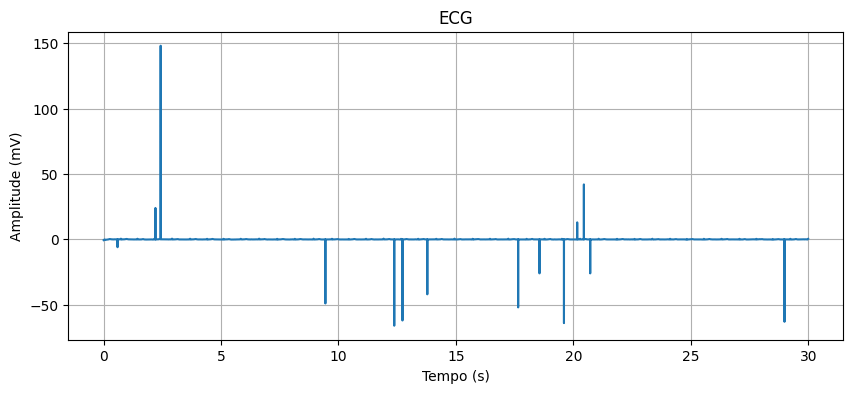

In [ ]:
# Acessa o primeiro sinal da primeira linha
example_signal = df.loc[0, "ECG_signal"][0]

# Frequência de amostragem
fs = 500  # Hz


time_axis = [i/fs for i in range(len(example_signal))]


plt.figure(figsize=(10, 4))
plt.plot(time_axis, example_signal)
plt.title("ECG")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()


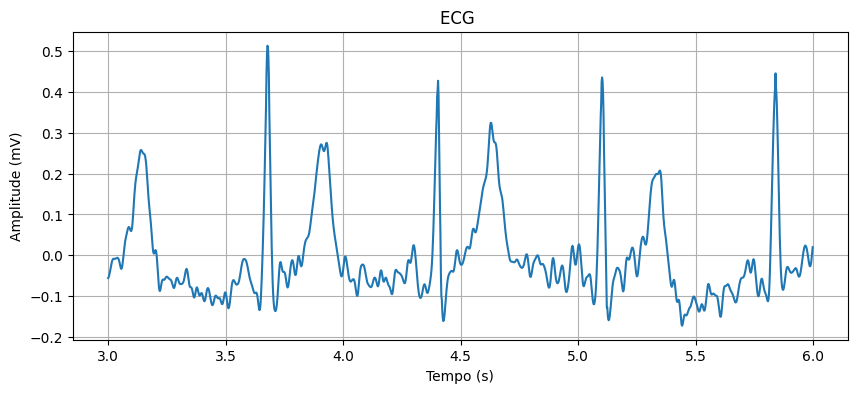

In [ ]:
# Seleciona o primeiro sinal da primeira linha do DF
example_signal = df.loc[0, "ECG_signal"][0]

# Frequência de amostragem
fs = 500  # Hz

# Definir janela em segundos
start_sec = 3
end_sec = 6

start_idx = int(start_sec * fs)
end_idx = int(end_sec * fs)


time_axis = [i/fs for i in range(start_idx, end_idx)]


window_signal = example_signal[start_idx:end_idx]


plt.figure(figsize=(10, 4))
plt.plot(time_axis, window_signal)
plt.title(f"ECG ")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()


##Filtro Savitzky-Golay

In [ ]:

# Savitzky-Golay filter
'''
@brief: This function creates a savitzky golay filter
@param: data is an array with the signal
@param: frame is the number of frames the filter will consider
@param: order is the filter's order
@return: the signal filtered
'''
def savitzky_golay_filter(data, frame, order):
    return savgol_filter(data, frame, order) # frame lenght, polynomial order

In [ ]:
# Parâmetros do filtro Savitzky-Golay
frame = 23  # tamanho da janela (ímpar e > ordem)
order = 3  # ordem do polinômio

# Aplica suavização a cada sinal da coluna ecg_filtered
df["ecg_smoothed"] = df["ECG_signal"].apply(
    lambda sig: savgol_filter(np.array(sig, dtype=float), window_length=frame, polyorder=order)
)

print(" Sinais suavizados adicionados ao DataFrame.")


 Sinais suavizados adicionados ao DataFrame.


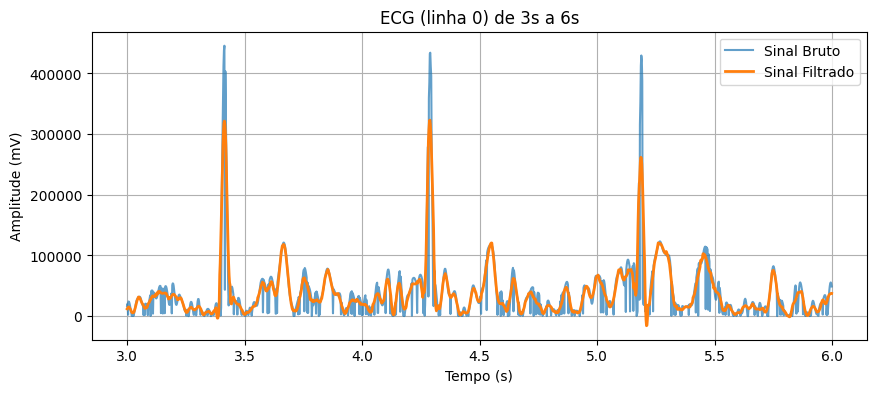

In [ ]:
# Seleciona os dois sinais da primeira linha do DF
raw_signal = df.loc[100, "ECG_signal"][0]
filtered_signal = df.loc[100, "ecg_smoothed"][0]

# Frequência de amostragem
fs = 500  # Hz


start_sec = 3
end_sec = 6   # janela entre 3s e 6s


start_idx = int(start_sec * fs)
end_idx = int(end_sec * fs)


time_axis = [i/fs for i in range(start_idx, end_idx)]


raw_window = raw_signal[start_idx:end_idx]
filtered_window = filtered_signal[start_idx:end_idx]


plt.figure(figsize=(10, 4))
plt.plot(time_axis, raw_window, label="Sinal Bruto", alpha=0.7)
plt.plot(time_axis, filtered_window, label="Sinal Filtrado", linewidth=2)
plt.title(f"ECG (linha 0) de {start_sec}s a {end_sec}s")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.show()


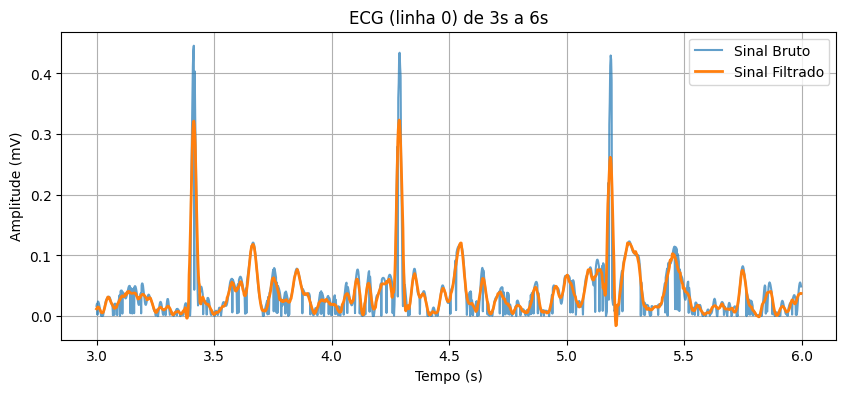

In [ ]:
import numpy as np

# Seleciona os dois sinais
raw_signal = np.array(df.loc[100, "ECG_signal"][0])
filtered_signal = np.array(df.loc[100, "ecg_smoothed"][0])

# Frequência de amostragem
fs = 500  # Hz

start_sec = 3
end_sec = 6

start_idx = int(start_sec * fs)
end_idx = int(end_sec * fs)

time_axis = np.arange(start_idx, end_idx) / fs

# Janela dos sinais (agora pode dividir)
raw_window = raw_signal[start_idx:end_idx] / 1000000
filtered_window = filtered_signal[start_idx:end_idx] / 1000000

plt.figure(figsize=(10, 4))
plt.plot(time_axis, raw_window, label="Sinal Bruto", alpha=0.7)
plt.plot(time_axis, filtered_window, label="Sinal Filtrado", linewidth=2)
plt.title(f"ECG (linha 0) de {start_sec}s a {end_sec}s")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.show()


#Dataset Após Savitzky-Golay

In [ ]:
df

participant_id  GLC  ECG_Quality janela_id  \
0                B1  125            1         0   
1                B1  125            1         0   
2                B1  125            1         0   
3                B1  125            1         0   
4                B1  125            1         0   
...             ...  ...          ...       ...   
2470             B9  148            0       164   
2471             B9  148            0       164   
2472             B9  148            0       164   
2473             B9  148            0       164   
2474             B9  148            0       164   

                                              ECG_Clean  \
0     [[-0.021023846685137626, -0.004693318950133486...   
1     [[-0.3217576138289678, -0.3245182089561419, -0...   
2     [[0.014633286993035887, 0.01561217231755444, 0...   
3     [[0.024710920610764197, 0.029863264464571982, ...   
4     [[-0.04364237210367896, -0.04306221588649323, ...   
...                                                 ...   
2470  [[-0.1431650381369575, -0.161983140356925, -0....   
2471  [[0.014509678455234713, 0.014927655468028512, ...   
2472  [[-0.09461506907587498, -0.0916850012076773, -...   
2473  [[-0.05144948712680476, -0.05049756779479622, ...   
2474  [[-0.1146912981047565, -0.11015483499653833, -...   

                                            ECG_R_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            ECG_P_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             ECG_Q_Wave  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2470  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2471  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2472  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2473  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2474  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            ECG_S_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0,

## Processamento com NeuroKit

In [ ]:



def detect_Q_wave(ecg_clean, R_onsets, R_peaks):
    """
    Retorna um array binário com 1 nos pontos Q e 0 no restante do sinal.
    Para cada R-peak, encontra o ponto mínimo entre o R-onset imediatamente anterior e o R-peak.
    """
    ecg_array = np.array(ecg_clean)
    Q_wave = np.zeros_like(ecg_array)

    if len(R_onsets) == 0 or len(R_peaks) == 0:
        return Q_wave

    for r_peak in R_peaks:
        # Seleciona o último R-onset antes do R-peak
        onset_candidates = R_onsets[R_onsets < r_peak]
        if len(onset_candidates) == 0:
            continue
        onset = onset_candidates[-1]

        # Ponto mínimo entre R-onset e R-peak
        q_point = onset + np.argmin(ecg_array[onset:r_peak+1])
        Q_wave[q_point] = 1

    return Q_wave

# Lista para armazenar resultados
results = []

for idx, row in df.iterrows():
    ecg_raw = row["ecg_smoothed"][0]

    # Processa o sinal com NeuroKit2
    signals, info = nk.ecg_process(ecg_raw, sampling_rate=500)
    signals_dict = signals.to_dict(orient="list")

    # Detectar ondas Q
    ecg_clean = signals_dict["ECG_Clean"]
    R_onsets = np.where(np.array(signals_dict["ECG_R_Onsets"])==1)[0]
    R_peaks = np.where(np.array(signals_dict["ECG_R_Peaks"])==1)[0]
    Q_wave = detect_Q_wave(ecg_clean, R_onsets, R_peaks)

    # Montar dicionário da linha do DataFrame
    row_dict = {
        "participant_id": row["participant_id"],

        "GLC": row["GLC"],
        "ECG_Q_Wave": Q_wave.tolist()  # adiciona Q wave como lista
    }

    # Adiciona todas as colunas do NeuroKit2
    row_dict.update(signals_dict)

    results.append(row_dict)

# Criar DataFrame final
df_ecg_processed = pd.DataFrame(results)

print(df_ecg_processed.head())


/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 12 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 12 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 12 missing data points in your signal. Fill

  participant_id  GLC                                         ECG_Q_Wave  \
0             B1  125  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1             B1   94  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2             B1   94  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3             B1  120  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4             B1  120  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             ECG_Raw  \
0  [-0.5733435153846151, -0.583032435056248, -0.5...   
1  [-0.10508069096989965, -0.09777327059896623, -...   
2  [-0.7647721401337788, -0.7639546838552748, -0....   
3  [-0.10902206923076926, -0.1060425852234722, -0...   
4  [-0.5247482264214043, -0.5341208009425354, -0....   

                                           ECG_Clean  \
0  [-0.021023846685137626, -0.004693318950133486,...   
1  [0.3070891958333802, 0.310692614021166, 0.3140...   
2  [-0.28007920575962375, -0.280605181

#Dataset ECG Após processamneto NeuroKit2

In [ ]:
df_ecg_processed

participant_id  GLC                                         ECG_Q_Wave  \
0               B1  125  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1               B1   94  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2               B1   94  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               B1  120  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               B1  120  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..             ...  ...                                                ...   
160             B2  164  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
161             B2  164  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
162             B9  148  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
163             B9  148  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
164             B9  148  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               ECG_Raw  \
0    [-0.5733435153846151, -0.583032435056248, -0.5...   
1    [-0.10508069096989965, -0.09777327059896623, -...   
2    [-0.7647721401337788, -0.7639546838552748, -0....   
3    [-0.10902206923076926, -0.1060425852234722, -0...   
4    [-0.5247482264214043, -0.5341208009425354, -0....   
..                                                 ...   
160  [276573.01839464874, 301654.83761021576, 32633...   
161  [660806.8090301006, 521910.84876862273, 408916...   
162  [0.51655411270903, 0.5178099611128002, 0.51705...   
163  [0.2643317478260877, 0.233106498023716, 0.2256...   
164  [0.3382949709030098, 0.34486582471875926, 0.35...   

                                             ECG_Clean  \
0    [-0.021023846685137626, -0.004693318950133486,...   
1    [0.3070891958333802, 0.310692614021166, 0.3140...   
2    [-0.28007920575962375, -0.2806051815258397, -0...   
3    [-0.006186749285063579, -0.006041972686845908,...   
4    [-0.16794537146427796, -0.1736517123856237, -0...   
..                                                 ...   
160  [86816.1248115634, 109135.08333231969, 131272....   
161  [-22689.363423310853, -98169.19740339844, -170...   
162  [0.17480909033094036, 0.1729657097351794, 0.17...   
163  [0.2928284344251011, 0.3121862890000687, 0.333...   
164  [0.12167287962477952, 0.12546610345079792, 0.1...   

                                              ECG_Rate  ECG_Quality  \
0    [81.10918544194107, 81.10918544194107, 81.1091...            1   
1    [84.09250175192712, 84.09250175192712, 84.0925...            1   
2    [85.02906976744187, 85.02906976744187, 85.0290...            1   
3    [79.00207900207901, 79.00207900207901, 79.0020...            1   
4    [83.31553086947234, 83.31553086947234, 83.3155...            1   
..                                                 ...          ...   
160  [76.02219026094103, 76.02219026094103, 76.0221...            0   
161  [75.56160653505788, 75.56160653505788, 75.5616...            1   
162  [73.09941520467837, 73.09941520467837, 73.0994...            0   
163  [74.84926190311178, 74.84926190311178, 74.8492...            0   
164  [73.37526205450735, 73.37526205450735, 73.3752...            0   

                                           ECG_R_Peaks  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
160  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
161  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
162  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
163  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
164  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                           ECG_P_Peaks  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0

##janelamento

In [ ]:
fs = 500
window_sec = 2
window_size = fs * window_sec  # 1500 amostras
overlap = 0  # sem sobreposição

columns_to_window = [
    "ECG_Clean",
    "ECG_R_Peaks",
    "ECG_P_Peaks",
    "ECG_Q_Wave",
    "ECG_S_Peaks",
    "ECG_T_Peaks",
    "ECG_R_Onsets",
    "ECG_R_Offsets",
    "ECG_T_Onsets",
    "ECG_T_Offsets",
    "ECG_Quality",
]

windowed_data = []

for idx, row in df_ecg_processed.iterrows():
    n_samples = len(row["ECG_Clean"]) if isinstance(row["ECG_Clean"], (list, np.ndarray)) else 0
    if n_samples == 0:
        continue

    # converte todos os sinais para array 1D
    signals_dict = {}
    for col in columns_to_window:
        signal = np.array(row[col])
        if signal.ndim > 1:
            signal = signal[0]  # caso seja lista dentro de lista
        signals_dict[col] = signal

    start = 0
    win_id = 0
    while start + window_size <= n_samples:
        window_row = {
            "participant_id": row["participant_id"],
            "GLC": row["GLC"],

            "janela_id": f"{idx}"
        }

        # extrai a janela de cada coluna
        for col in columns_to_window:
            window_row[col] = [signals_dict[col][start:start+window_size].tolist()]

        windowed_data.append(window_row)
        win_id += 1
        start += int(window_size * (1 - overlap))

df_windowed = pd.DataFrame(windowed_data)




#Média e valor mínimo de qualidade

In [ ]:


# Função para transformar cada célula da coluna em um número médio
def mean_quality(q_list):
    """
    Recebe uma lista (ou lista de listas) e retorna a média.
    """
    if isinstance(q_list, list):
        # Achatar listas internas
        flat = []
        for item in q_list:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)
        if len(flat) > 0:
            return np.mean(flat)
    return np.nan

# Criar nova coluna com a média da qualidade
df_windowed['ECG_Quality_Mean'] = df_windowed['ECG_Quality'].apply(mean_quality)

# Verificar resultado
print(df_windowed[['participant_id','janela_id','ECG_Quality_Mean']].head())

# Média geral de todas as janelas
overall_mean_quality = df_windowed['ECG_Quality_Mean'].mean()
print(f"Média geral da qualidade do ECG: {overall_mean_quality:.4f}")


  participant_id janela_id  ECG_Quality_Mean
0             B1         0          0.755105
1             B1         0          0.335111
2             B1         0          0.901620
3             B1         0          0.939417
4             B1         0          0.874986
Média geral da qualidade do ECG: 0.7466


In [ ]:


# Função para pegar o menor valor da qualidade
def min_quality(q_list):
    """
    Recebe uma lista (ou lista de listas) e retorna o menor valor (min).
    """
    if isinstance(q_list, list):
        # Achatar listas internas
        flat = []
        for item in q_list:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)
        if len(flat) > 0:
            return np.min(flat)
    return np.nan

# Criar nova coluna com o menor valor da qualidade
df_windowed['ECG_Quality_Min'] = df_windowed['ECG_Quality'].apply(min_quality)

# Verificar resultado
print(df_windowed[['participant_id','janela_id','ECG_Quality_Min']].head())

# Menor valor global em todas as janelas
overall_min_quality = df_windowed['ECG_Quality_Min'].min()
print(f"Menor valor encontrado de ECG_Quality em todas as janelas: {overall_min_quality:.4f}")


  participant_id janela_id  ECG_Quality_Min
0             B1         0         0.518862
1             B1         0         0.000000
2             B1         0         0.820200
3             B1         0         0.919235
4             B1         0         0.829909
Menor valor encontrado de ECG_Quality em todas as janelas: 0.0000


#Dataset após janelamento

In [ ]:
df_windowed

participant_id  GLC janela_id  \
0                B1  125         0   
1                B1  125         0   
2                B1  125         0   
3                B1  125         0   
4                B1  125         0   
...             ...  ...       ...   
2470             B9  148       164   
2471             B9  148       164   
2472             B9  148       164   
2473             B9  148       164   
2474             B9  148       164   

                                              ECG_Clean  \
0     [[0.43598581276911447, 0.45313604496498605, 0....   
1     [[0.034816470242489246, 0.03458759160922261, 0...   
2     [[0.3327282594456081, 0.33482754927764874, 0.3...   
3     [[0.3466155670542663, 0.3570217251879883, 0.36...   
4     [[0.891829594009616, 0.8919684646563335, 0.892...   
...                                                 ...   
2470  [[0.06090087249905069, 0.028975314453001742, 0...   
2471  [[0.32594621433577853, 0.32662859987863685, 0....   
2472  [[0.07940964201984688, 0.08452030614088364, 0....   
2473  [[0.22119882006434124, 0.2227592414362393, 0.2...   
2474  [[0.13059751954839727, 0.1376261303192209, 0.1...   

                                            ECG_R_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            ECG_P_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             ECG_Q_Wave  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2470  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2471  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2472  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2473  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2474  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            ECG_S_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

   

#normalização

In [ ]:


# Supondo que df_ecg_processed é seu DataFrame
df = df_windowed.copy()

# Lista de colunas que contêm amplitudes (valores contínuos)
amplitude_cols = [
    'ECG_Clean'
]

# Função para aplicar normalização min-max a uma lista numérica
def normalize_minmax(signal):
    signal = np.array(signal, dtype=float)
    if len(signal) == 0:
        return signal
    # Calcula min e max
    min_val, max_val = np.min(signal), np.max(signal)
    # Evita divisão por zero se o sinal for constante
    if min_val == max_val:
        return np.zeros_like(signal)
    # Normaliza para [0, 1]
    return (signal - min_val) / (max_val - min_val)

# Aplica a função a todas as colunas de amplitude
for col in amplitude_cols:
   df_windowed[col] = df_windowed[col].apply(normalize_minmax)

df_windowed


participant_id  GLC janela_id  \
0                B1  125         0   
1                B1  125         0   
2                B1  125         0   
3                B1  125         0   
4                B1  125         0   
...             ...  ...       ...   
2470             B9  148       164   
2471             B9  148       164   
2472             B9  148       164   
2473             B9  148       164   
2474             B9  148       164   

                                              ECG_Clean  \
0     [[0.43598581276911447, 0.45313604496498605, 0....   
1     [[0.034816470242489246, 0.03458759160922261, 0...   
2     [[0.3327282594456081, 0.33482754927764874, 0.3...   
3     [[0.3466155670542663, 0.3570217251879883, 0.36...   
4     [[0.891829594009616, 0.8919684646563335, 0.892...   
...                                                 ...   
2470  [[0.06090087249905069, 0.028975314453001742, 0...   
2471  [[0.32594621433577853, 0.32662859987863685, 0....   
2472  [[0.07940964201984688, 0.08452030614088364, 0....   
2473  [[0.22119882006434124, 0.2227592414362393, 0.2...   
2474  [[0.13059751954839727, 0.1376261303192209, 0.1...   

                                            ECG_R_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            ECG_P_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             ECG_Q_Wave  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2470  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2471  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2472  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2473  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2474  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            ECG_S_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

   

In [ ]:
df_windowed

participant_id  GLC janela_id  \
0                B1  125         0   
1                B1  125         0   
2                B1  125         0   
3                B1  125         0   
4                B1  125         0   
...             ...  ...       ...   
2470             B9  148       164   
2471             B9  148       164   
2472             B9  148       164   
2473             B9  148       164   
2474             B9  148       164   

                                              ECG_Clean  \
0     [[0.43598581276911447, 0.45313604496498605, 0....   
1     [[0.034816470242489246, 0.03458759160922261, 0...   
2     [[0.3327282594456081, 0.33482754927764874, 0.3...   
3     [[0.3466155670542663, 0.3570217251879883, 0.36...   
4     [[0.891829594009616, 0.8919684646563335, 0.892...   
...                                                 ...   
2470  [[0.06090087249905069, 0.028975314453001742, 0...   
2471  [[0.32594621433577853, 0.32662859987863685, 0....   
2472  [[0.07940964201984688, 0.08452030614088364, 0....   
2473  [[0.22119882006434124, 0.2227592414362393, 0.2...   
2474  [[0.13059751954839727, 0.1376261303192209, 0.1...   

                                            ECG_R_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            ECG_P_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                             ECG_Q_Wave  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2470  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2471  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2472  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2473  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2474  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                            ECG_S_Peaks  \
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                                                 ...   
2470  [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2471  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2472  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2474  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

   

##Plot janela

Qualidade média da janela: 0.9474
Qualidade mínima da janela: 0.9197


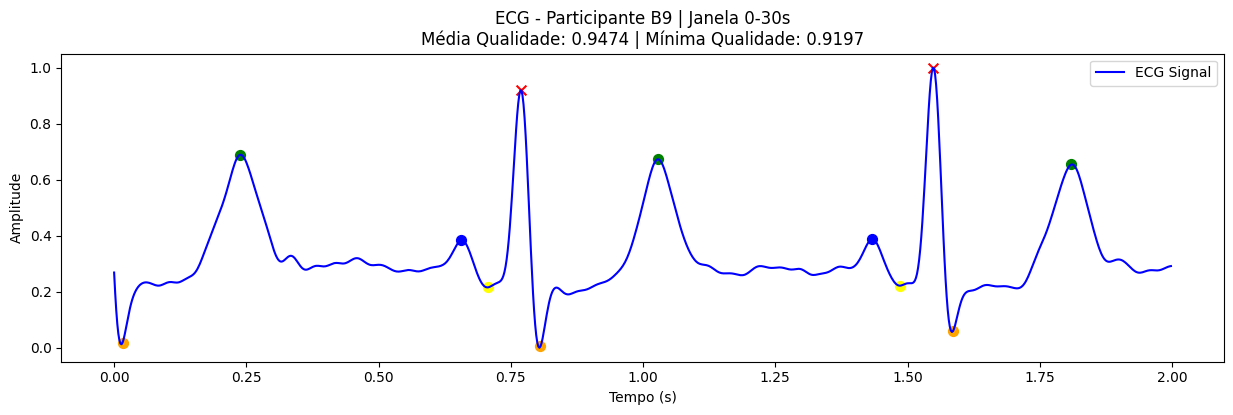

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ecg_window(df_row, start_sec=0, end_sec=2, fs=500, use_clean=True):
    """
    Plota uma janela do ECG com todas as features detectadas pelo NeuroKit2,
    incluindo a onda Q. Pico R será marcado com 'x'. Também mostra a qualidade da janela.
    """
    # Seleciona o sinal
    signal_name = "ECG_Clean" if use_clean else "ECG_Raw"
    ecg = np.array(df_row[signal_name])
    if ecg.ndim > 1:  # garante que seja 1D
        ecg = ecg[0]

    n_samples = len(ecg)
    start_idx = int(start_sec * fs)
    end_idx = int(end_sec * fs)
    end_idx = min(end_idx, n_samples)

    ecg_window = ecg[start_idx:end_idx]
    time_axis = np.arange(start_idx, end_idx) / fs

    # Calcula a qualidade média e mínima da janela
    ecg_quality_mean = np.nan
    ecg_quality_min = np.nan
    if "ECG_Quality" in df_row:
        q_list = df_row["ECG_Quality"]
        flat = []
        for item in q_list:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)
        if len(flat) > 0:
            ecg_quality_mean = np.mean(flat)
            ecg_quality_min = np.min(flat)

    print(f"Qualidade média da janela: {ecg_quality_mean:.4f}")
    print(f"Qualidade mínima da janela: {ecg_quality_min:.4f}")

    # Lista de features (R será X, S e T serão bolinhas)
    features = ["ECG_R_Peaks", "ECG_S_Peaks", "ECG_Q_Wave", "ECG_T_Peaks","ECG_P_Peaks"]
    colors   = ["red", "orange", "yellow", "green","blue"]  # escolha qualquer cor
    markers  = ["x", "o", "o", "o","o"]  # você pode manter todos "o", só o R fica 'x'

    plt.figure(figsize=(15, 4))
    plt.plot(time_axis, ecg_window, label=f"ECG {'Clean' if use_clean else 'Raw'}", color="blue")

    for feat, color, marker in zip(features, colors, markers):
        if feat in df_row:
            feat_arr = np.array(df_row[feat])
            if feat_arr.ndim > 1:
                feat_arr = feat_arr[0]
            feat_arr = np.pad(feat_arr, (0, max(0, len(ecg)-len(feat_arr))), 'constant')
            feat_idx_abs = np.where(feat_arr == 1)[0]
            feat_idx_window = feat_idx_abs[(feat_idx_abs >= start_idx) & (feat_idx_abs < end_idx)]
            feat_idx_rel = feat_idx_window - start_idx
            plt.scatter(time_axis[feat_idx_rel], ecg_window[feat_idx_rel], color=color, marker=marker, s=50)

    plt.title(f"ECG - Participante {df_row['participant_id']} | Janela {start_sec}-{end_sec}s\n"
              f"Média Qualidade: {ecg_quality_mean:.4f} | Mínima Qualidade: {ecg_quality_min:.4f}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.legend(["ECG Signal"])
    plt.show()


# EXEMPLO
plot_ecg_window(df_windowed.loc[2450], start_sec=0, end_sec=30, use_clean=True)


Qualidade média da janela: 0.9474
Qualidade mínima da janela: 0.9197


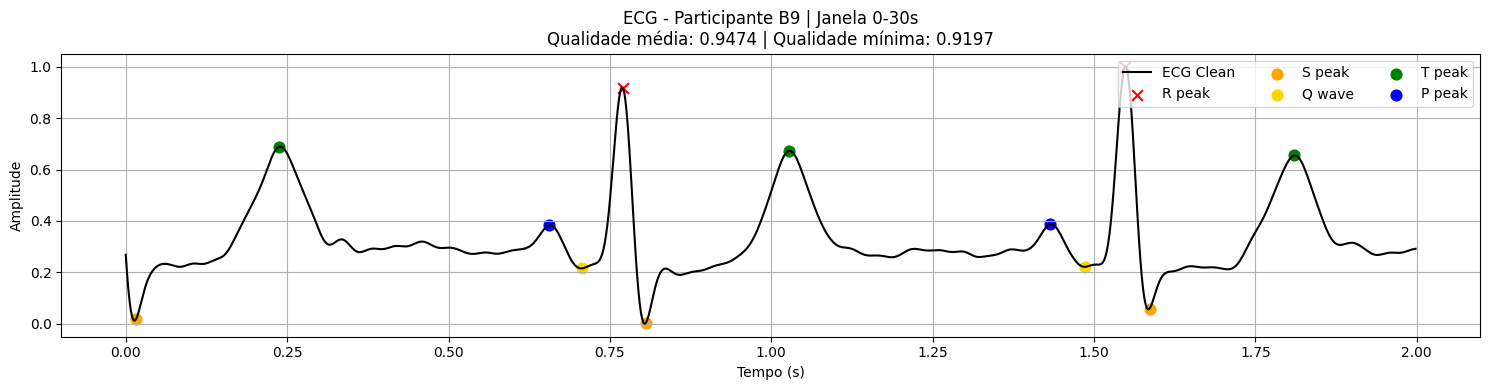

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ecg_window(df_row, start_sec=0, end_sec=2, fs=500, use_clean=True):
    """
    Plota uma janela do ECG com todas as features detectadas pelo NeuroKit2,
    incluindo Q, R, S, P e T.
    Pico R é marcado com 'x'.
    Também mostra a qualidade da janela.
    """

    # Seleciona o sinal
    signal_name = "ECG_Clean" if use_clean else "ECG_Raw"
    ecg = np.array(df_row[signal_name])
    if ecg.ndim > 1:
        ecg = ecg[0]

    n_samples = len(ecg)
    start_idx = int(start_sec * fs)
    end_idx = min(int(end_sec * fs), n_samples)

    ecg_window = ecg[start_idx:end_idx]
    time_axis = np.arange(start_idx, end_idx) / fs

    # Qualidade do ECG
    ecg_quality_mean = np.nan
    ecg_quality_min = np.nan

    if "ECG_Quality" in df_row:
        q_list = df_row["ECG_Quality"]
        flat = []
        for item in q_list:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)

        if len(flat) > 0:
            ecg_quality_mean = np.mean(flat)
            ecg_quality_min = np.min(flat)

    print(f"Qualidade média da janela: {ecg_quality_mean:.4f}")
    print(f"Qualidade mínima da janela: {ecg_quality_min:.4f}")

    # Features e estilos
    features = {
        "ECG_R_Peaks": "R peak",
        "ECG_S_Peaks": "S peak",
        "ECG_Q_Wave":  "Q wave",
        "ECG_T_Peaks": "T peak",
        "ECG_P_Peaks": "P peak"
    }

    colors  = ["red", "orange", "gold", "green", "blue"]
    markers = ["x", "o", "o", "o", "o"]

    plt.figure(figsize=(15, 4))

    # Sinal ECG
    plt.plot(
        time_axis,
        ecg_window,
        label=f"ECG {'Clean' if use_clean else 'Raw'}",
        color="black",
        linewidth=1.5
    )

    # Plot das features
    for (feat, label), color, marker in zip(features.items(), colors, markers):
        if feat in df_row:
            feat_arr = np.array(df_row[feat])
            if feat_arr.ndim > 1:
                feat_arr = feat_arr[0]

            # Garante mesmo tamanho do sinal
            feat_arr = np.pad(
                feat_arr,
                (0, max(0, len(ecg) - len(feat_arr))),
                'constant'
            )

            feat_idx_abs = np.where(feat_arr == 1)[0]
            feat_idx_window = feat_idx_abs[
                (feat_idx_abs >= start_idx) & (feat_idx_abs < end_idx)
            ]

            if len(feat_idx_window) > 0:
                feat_idx_rel = feat_idx_window - start_idx
                plt.scatter(
                    time_axis[feat_idx_rel],
                    ecg_window[feat_idx_rel],
                    color=color,
                    marker=marker,
                    s=60,
                    label=label
                )

    plt.title(
        f"ECG - Participante {df_row['participant_id']} | "
        f"Janela {start_sec}-{end_sec}s\n"
        f"Qualidade média: {ecg_quality_mean:.4f} | "
        f"Qualidade mínima: {ecg_quality_min:.4f}"
    )

    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.legend(loc="upper right", ncol=3)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# EXEMPLO DE USO
plot_ecg_window(df_windowed.loc[2450], start_sec=0, end_sec=30, use_clean=True)


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_ecg_window_interactive(df_row, start_sec=0, end_sec=2, fs=500, use_clean=True):
    """
    Plota uma janela do ECG com todas as features detectadas pelo NeuroKit2 de forma interativa,
    incluindo a onda Q. Pico R será marcado com 'x'. Também mostra a qualidade da janela.
    """
    # Seleciona o sinal
    signal_name = "ECG_Clean" if use_clean else "ECG_Raw"
    ecg = np.array(df_row[signal_name])
    if ecg.ndim > 1:
        ecg = ecg[0]

    n_samples = len(ecg)
    start_idx = int(start_sec * fs)
    end_idx = int(end_sec * fs)
    end_idx = min(end_idx, n_samples)

    ecg_window = ecg[start_idx:end_idx]
    time_axis = np.arange(start_idx, end_idx) / fs

    # Calcula a qualidade média da janela
    ecg_quality = np.nan
    if "ECG_Quality" in df_row:
        q_list = df_row["ECG_Quality"]
        flat = []
        for item in q_list:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)
        if len(flat) > 0:
            ecg_quality = np.mean(flat)
    print(f"Qualidade média da janela: {ecg_quality:.4f}")

    # Cria figura interativa
    fig = go.Figure()

    # ECG
    fig.add_trace(go.Scatter(x=time_axis, y=ecg_window, mode='lines', name='ECG', line=dict(color='blue')))

    # Lista de features
    features = ["ECG_R_Peaks", "ECG_S_Peaks", "ECG_T_Peaks"]
    colors = ["red", "orange", "green"]
    markers = ["x", "circle", "circle"]
    labels = ["R Peaks", "S Peaks", "T Peaks"]

    for feat, color, marker, label in zip(features, colors, markers, labels):
        if feat in df_row:
            feat_arr = np.array(df_row[feat])
            if feat_arr.ndim > 1:
                feat_arr = feat_arr[0]

            feat_arr = np.pad(feat_arr, (0, max(0, len(ecg)-len(feat_arr))), 'constant')
            feat_idx_abs = np.where(feat_arr == 1)[0]
            feat_idx_window = feat_idx_abs[(feat_idx_abs >= start_idx) & (feat_idx_abs < end_idx)]
            feat_idx_rel = feat_idx_window - start_idx

            fig.add_trace(go.Scatter(
                x=time_axis[feat_idx_rel],
                y=ecg_window[feat_idx_rel],
                mode='markers',
                marker=dict(color=color, symbol=marker, size=10),
                name=label
            ))

    # Onda Q
    if "ECG_Q_Wave" in df_row:
        Q_arr = np.array(df_row["ECG_Q_Wave"])
        if Q_arr.ndim > 1:
            Q_arr = Q_arr[0]
        Q_arr = np.pad(Q_arr, (0, max(0, len(ecg)-len(Q_arr))), 'constant')
        Q_idx_abs = np.where(Q_arr == 1)[0]
        Q_idx_window = Q_idx_abs[(Q_idx_abs >= start_idx) & (Q_idx_abs < end_idx)]
        Q_idx_rel = Q_idx_window - start_idx

        fig.add_trace(go.Scatter(
            x=time_axis[Q_idx_rel],
            y=ecg_window[Q_idx_rel],
            mode='markers',
            marker=dict(color='black', symbol='x', size=10),
            name='Q Wave'
        ))

    fig.update_layout(
        title=f"ECG com features - Participante {df_row['participant_id']}, Janela: {start_sec}-{end_sec}s | Qualidade média: {ecg_quality:.4f}",
        xaxis_title="Tempo (s)",
        yaxis_title="Amplitude",
        legend=dict(x=0.8, y=0.95)
    )

    fig.show()

# Exemplo: plotar 30 segundos do primeiro participante
plot_ecg_window_interactive(df_windowed.loc[650], start_sec=0, end_sec=30, use_clean=True)


Qualidade média da janela: 0.9780


Qualidade média da janela: 0.3700
Qualidade mínima da janela: 0.0578


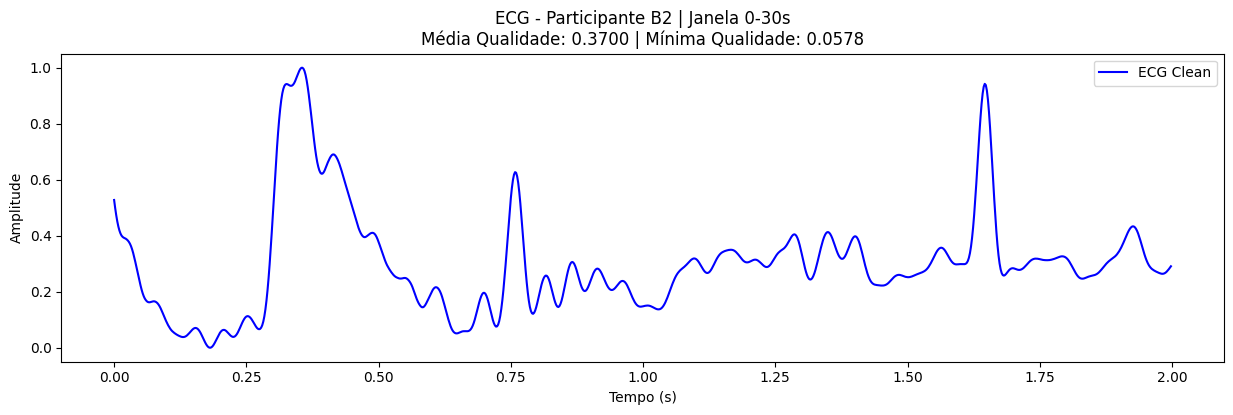

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ecg_window_apnea(df_row, start_sec=0, end_sec=30, fs=500, use_clean=True):
    """
    Plota uma janela do ECG mostrando o sinal, a presença de apneia e a qualidade da janela.
    Não exibe as ondas detectadas (R, S, Q, T, P).
    """
    # Seleciona o sinal
    signal_name = "ECG_Clean" if use_clean else "ECG_Raw"
    ecg = np.array(df_row[signal_name])
    if ecg.ndim > 1:
        ecg = ecg[0]

    n_samples = len(ecg)
    start_idx = int(start_sec * fs)
    end_idx = min(int(end_sec * fs), n_samples)

    ecg_window = ecg[start_idx:end_idx]
    time_axis = np.arange(start_idx, end_idx) / fs

    # Calcula a qualidade média e mínima da janela
    ecg_quality_mean = np.nan
    ecg_quality_min = np.nan
    if "ECG_Quality" in df_row:
        q_list = df_row["ECG_Quality"]
        flat = []
        for item in q_list:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)
        if len(flat) > 0:
            ecg_quality_mean = np.mean(flat)
            ecg_quality_min = np.min(flat)

    print(f"Qualidade média da janela: {ecg_quality_mean:.4f}")
    print(f"Qualidade mínima da janela: {ecg_quality_min:.4f}")

    plt.figure(figsize=(15, 4))
    plt.plot(time_axis, ecg_window, label=f"ECG {'Clean' if use_clean else 'Raw'}", color="blue")

    # Se houver sinal de apneia, desenha regiões sombreadas
    if "Apnea_Label" in df_row:
        apnea_signal = np.array(df_row["Apnea_Label"])
        if apnea_signal.ndim > 1:
            apnea_signal = apnea_signal[0]
        apnea_window = apnea_signal[start_idx:end_idx]

        apnea_regions = np.where(apnea_window == 1)[0]
        if len(apnea_regions) > 0:
            plt.fill_between(
                time_axis, min(ecg_window), max(ecg_window),
                where=(apnea_window == 1),
                color='red', alpha=0.3, label='Apneia'
            )

    plt.title(f"ECG - Participante {df_row['participant_id']} | Janela {start_sec}-{end_sec}s\n"
              f"Média Qualidade: {ecg_quality_mean:.4f} | Mínima Qualidade: {ecg_quality_min:.4f}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


# EXEMPLO DE USO
plot_ecg_window_apnea(df_windowed.loc[1400], start_sec=0, end_sec=30, use_clean=True)


In [ ]:
import pandas as pd
import numpy as np

# Função para achatar listas de listas
def flatten_list(cell):
    # Se for string representando lista, tenta converter
    if isinstance(cell, str):
        import ast
        try:
            cell = ast.literal_eval(cell)
        except:
            return cell

    # Se for lista ou array
    if isinstance(cell, (list, np.ndarray)):
        flat = []
        for item in cell:
            if isinstance(item, (list, np.ndarray)):
                flat.extend(item)
            else:
                flat.append(item)
        return flat
    return cell

# Colunas que precisam ser achatadas
cols_to_flatten = [
    "ECG_Clean", "ECG_Raw",
    "ECG_R_Peaks", "ECG_P_Peaks", "ECG_Q_Wave",
    "ECG_S_Peaks", "ECG_T_Peaks",
    "ECG_R_Onsets", "ECG_R_Offsets",
    "ECG_T_Onsets", "ECG_T_Offsets",
    "ECG_Quality"  # caso exista
]

# Criar um novo DataFrame achatado
df_flat = df_windowed.copy()

for col in cols_to_flatten:
    if col in df_flat.columns:
        df_flat[col] = df_flat[col].apply(flatten_list)

# Conferir o resultado
df_flat.head()
df_windowed = df_flat

In [ ]:
df_windowed

participant_id  GLC  ECG_Quality janela_id  \
0               B1  125            1         0   
1               B1  125            1         0   
2               B1  125            1         0   
3               B1  125            1         0   
4               B1  125            1         0   
..             ...  ...          ...       ...   
490             B6   94            1        32   
491             B6   94            1        32   
492             B6   94            1        32   
493             B6   94            1        32   
494             B6   94            1        32   

                                             ECG_Clean  \
0    [0.43598581276911447, 0.45313604496498605, 0.4...   
1    [0.034816470242489246, 0.03458759160922261, 0....   
2    [0.3327282594456081, 0.33482754927764874, 0.33...   
3    [0.3466155670542663, 0.3570217251879883, 0.367...   
4    [0.891829594009616, 0.8919684646563335, 0.8920...   
..                                                 ...   
490  [0.1950713787922336, 0.20304748531963038, 0.21...   
491  [0.1903156634870504, 0.1897451821591654, 0.188...   
492  [0.9629698242919361, 0.9630802018000074, 0.963...   
493  [0.889162595499763, 0.8774697875084198, 0.8669...   
494  [0.4072378974880412, 0.4080916112279644, 0.407...   

                                           ECG_R_Peaks  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
490  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
491  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
492  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
493  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
494  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                           ECG_P_Peaks  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
490  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
491  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
492  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
493  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
494  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            ECG_Q_Wave  \
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
490  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
491  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
492  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
493  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
494  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                           ECG_S_Peaks  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
490  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
491  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
492  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
493  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


##Cálculo Features

In [ ]:
fs = 500  # Hz

features_results = []

for idx, row in df_windowed.iterrows():
    ecg = np.array(row["ECG_Clean"])
    P_peaks = np.where(np.array(row.get("ECG_P_Peaks", [])) == 1)[0]  # P peaks
    Q_wave = np.where(np.array(row["ECG_Q_Wave"]) == 1)[0]
    R_peaks = np.where(np.array(row["ECG_R_Peaks"]) == 1)[0]
    S_peaks = np.where(np.array(row["ECG_S_Peaks"]) == 1)[0]
    T_peaks = np.where(np.array(row.get("ECG_T_Peaks", [])) == 1)[0]

    # Listas para armazenar features
    RR_intervals = []
    QRS_durations = []
    QT_segments = []
    ST_segments = []
    RT_segments = []
    PR_segments = []  # nova lista
    PT_segments = []  # nova lista
    R_amplitudes = []
    T_amplitudes = []
    P_amplitudes = []


    # RR intervals (entre Rs consecutivos)
    if len(R_peaks) > 1:
        RR_intervals = (np.diff(R_peaks) / fs).tolist()
    else:
        RR_intervals = [np.nan]

    for r in R_peaks:
        # Amplitude da onda R
        R_amplitudes.append(ecg[r] if r < len(ecg) else np.nan)

        # Q antes do R
        q_candidates = Q_wave[Q_wave < r]
        q = q_candidates[-1] if len(q_candidates) > 0 else None

        # S depois do R
        s_candidates = S_peaks[S_peaks > r]
        s = s_candidates[0] if len(s_candidates) > 0 else None

        # T depois do R
        t_candidates = T_peaks[T_peaks > r] if len(T_peaks) > 0 else []
        t = t_candidates[0] if len(t_candidates) > 0 else None
        T_amplitudes.append(ecg[t] if t is not None and t < len(ecg) else np.nan)

        # P antes do R
        p_candidates = P_peaks[P_peaks < r] if len(P_peaks) > 0 else []
        p = p_candidates[-1] if len(p_candidates) > 0 else None
        P_amplitudes.append(ecg[p] if p is not None and p < len(ecg) else np.nan)

        # QRS duration
        QRS_durations.append((s - q) / fs if (q is not None and s is not None) else np.nan)

        # QT segment (Q até T)
        QT_segments.append((t - q) / fs if (q is not None and t is not None) else np.nan)

        # ST segment (S até T)
        ST_segments.append((t - s) / fs if (s is not None and t is not None) else np.nan)

        # RT segment (R até T)
        RT_segments.append((t - r) / fs if (r is not None and t is not None) else np.nan)

        # PR segment (P até R)
        PR_segments.append((r - p) / fs if (p is not None and r is not None) else np.nan)

        # PT segment (P até T)
        PT_segments.append((t - p) / fs if (p is not None and t is not None) else np.nan)

    # Montar dicionário para essa linha
    row_features = {
        "participant_id": row["participant_id"],
        "ECG_Clean": row["ECG_Clean"],
        "GLC": row["GLC"],
        "janela_id": row["janela_id"],
        "ECG_Quality_Mean": row["ECG_Quality_Mean"],
        "ECG_Quality_Min": row["ECG_Quality_Min"],

        "QRS_durations": QRS_durations,
        "RR_intervals": RR_intervals,
        "QT_segments": QT_segments,
        "ST_segments": ST_segments,
        "RT_segments": RT_segments,
        "PR_segments": PR_segments,  # adiciona PR
        "PT_segments": PT_segments,  # adiciona PT
        "R_amplitudes": R_amplitudes,
        "T_amplitudes": T_amplitudes,

        "P_amplitudes": P_amplitudes  # amplitudes P



    }

    features_results.append(row_features)

# DataFrame final
df_qrs_features = pd.DataFrame(features_results)

print(df_qrs_features.head())


  participant_id                                          ECG_Clean  GLC  \
0             B1  [0.43598581276911447, 0.45313604496498605, 0.4...  125   
1             B1  [0.034816470242489246, 0.03458759160922261, 0....  125   
2             B1  [0.3327282594456081, 0.33482754927764874, 0.33...  125   
3             B1  [0.3466155670542663, 0.3570217251879883, 0.367...  125   
4             B1  [0.891829594009616, 0.8919684646563335, 0.8920...  125   

  janela_id  ECG_Quality_Mean  ECG_Quality_Min          QRS_durations  \
0         0          0.755105         0.518862         [0.104, 0.096]   
1         0          0.335111         0.000000  [0.064, 0.102, 0.078]   
2         0          0.901620         0.820200   [0.098, 0.074, 0.08]   
3         0          0.939417         0.919235         [0.078, 0.072]   
4         0          0.874986         0.829909  [0.078, 0.096, 0.054]   

     RR_intervals          QT_segments           ST_segments  \
0         [0.818]        [0.14, 0.274]  

#Dataset de Features

In [ ]:
df_qrs_features

participant_id                                          ECG_Clean  GLC  \
0               B1  [0.43598581276911447, 0.45313604496498605, 0.4...  125   
1               B1  [0.034816470242489246, 0.03458759160922261, 0....  125   
2               B1  [0.3327282594456081, 0.33482754927764874, 0.33...  125   
3               B1  [0.3466155670542663, 0.3570217251879883, 0.367...  125   
4               B1  [0.891829594009616, 0.8919684646563335, 0.8920...  125   
..             ...                                                ...  ...   
490             B6  [0.1950713787922336, 0.20304748531963038, 0.21...   94   
491             B6  [0.1903156634870504, 0.1897451821591654, 0.188...   94   
492             B6  [0.9629698242919361, 0.9630802018000074, 0.963...   94   
493             B6  [0.889162595499763, 0.8774697875084198, 0.8669...   94   
494             B6  [0.4072378974880412, 0.4080916112279644, 0.407...   94   

    janela_id  ECG_Quality_Mean  ECG_Quality_Min  ECG_Quality  \
0           0               NaN              NaN            1   
1           0               NaN              NaN            1   
2           0               NaN              NaN            1   
3           0               NaN              NaN            1   
4           0               NaN              NaN            1   
..        ...               ...              ...          ...   
490        32               NaN              NaN            1   
491        32               NaN              NaN            1   
492        32               NaN              NaN            1   
493        32               NaN              NaN            1   
494        32               NaN              NaN            1   

             QRS_durations    RR_intervals          QT_segments  \
0           [0.104, 0.096]         [0.818]        [0.14, 0.274]   
1    [0.064, 0.102, 0.078]  [0.482, 0.768]  [0.254, 0.3, 0.278]   
2     [0.098, 0.074, 0.08]     [0.7, 0.74]  [0.296, 0.272, nan]   
3           [0.078, 0.072]         [0.764]       [0.272, 0.274]   
4    [0.078, 0.096, 0.054]   [0.796, 0.54]  [0.28, 0.29, 0.274]   
..                     ...             ...                  ...   
490  [0.106, 0.116, 0.086]   [0.81, 0.788]  [0.324, 0.306, nan]   
491          [0.124, 0.08]         [0.822]       [0.322, 0.296]   
492      [nan, 0.102, nan]    [1.0, 0.854]    [nan, 0.288, nan]   
493          [0.098, 0.33]          [0.63]         [0.326, nan]   
494         [0.098, 0.074]         [0.818]       [0.296, 0.292]   

              ST_segments            RT_segments           PR_segments  \
0          [0.036, 0.178]         [0.108, 0.236]         [0.18, 0.112]   
1      [0.19, 0.198, 0.2]  [0.222, 0.234, 0.236]  [0.224, 0.11, 0.098]   
2     [0.198, 0.198, nan]    [0.232, 0.234, nan]  [0.106, 0.108, 0.11]   
3          [0.194, 0.202]         [0.234, 0.238]        [0.132, 0.102]   
4    [0.202, 0.194, 0.22]   [0.24, 0.234, 0.242]    [0.096, 0.1, 0.64]   
..                    ...                    ...                   ...   
490    [0.218, 0.19, nan]     [0.254, 0.25, nan]  [0.128, 0.12, 0.134]   
491        [0.198, 0.216]         [0.248, 0.252]        [0.118, 0.138]   
492   [0.186, 0.186, nan]     [0.218, 0.25, nan]   [nan, 0.144, 0.144]   
493          [0.228, nan]           [0.294, nan]        [0.122, 0.214]   
494        [0.198, 0.218]         [0.248, 0.252]        [0.126, 0.138]   

               PT_segments                                       R_amplitudes  \
0           [0.288, 0.348]           [0.5471407054463557, 0.7483858326108705]   
1    [0.446, 0.344, 0.334]    [1.0, 0.07269630879593189, 0.09441342994299366]   
2      [0.338, 0.342, nan]       [0.827550221488468, 0.8935895486266091, 1.0]   
3            [0.366, 0.34]                          [1.0, 0.8086804138700953]   
4    [0.336, 0.334, 0.882]  [0.964664626630334, 0.9938741004112258, 0.9486...   
..                     ...                                                ...   
490     [0.382, 0.37, nan

##Média

In [ ]:
# Função auxiliar para calcular média ignorando NaN
def safe_mean(x):
    if isinstance(x, list):
        arr = np.array(x, dtype=float)
        return np.nanmean(arr) if len(arr) > 0 else np.nan
    return np.nan

# Novo DataFrame apenas com médias
df_features_mean = pd.DataFrame({
    "participant_id": df_qrs_features["participant_id"],
    "ECG_Clean": df_qrs_features["ECG_Clean"],
    "GLC": df_qrs_features["GLC"],
    "janela_id": df_qrs_features["janela_id"],
    "ECG_Quality_Mean": df_qrs_features["ECG_Quality_Mean"],
    "ECG_Quality_Min": df_qrs_features["ECG_Quality_Min"],



    "QRS_duration_mean": df_qrs_features["QRS_durations"].apply(safe_mean),
    "RR_interval_mean": df_qrs_features["RR_intervals"].apply(safe_mean),
    "QT_segment_mean": df_qrs_features["QT_segments"].apply(safe_mean),
    "ST_segment_mean": df_qrs_features["ST_segments"].apply(safe_mean),
    "R_amplitude_mean": df_qrs_features["R_amplitudes"].apply(safe_mean),
    "T_amplitude_mean": df_qrs_features["T_amplitudes"].apply(safe_mean),
    "RT_segment_mean": df_qrs_features["RT_segments"].apply(safe_mean),
    "PR_segment_mean": df_qrs_features["PR_segments"].apply(safe_mean),
    "PT_segment_mean"	: df_qrs_features["PR_segments"].apply(safe_mean),
    "P_amplitude_mean": df_qrs_features["P_amplitudes"].apply(safe_mean),
})

df_features_mean


/tmp/ipython-input-1088837108.py:5: RuntimeWarning:

Mean of empty slice



participant_id                                          ECG_Clean  GLC  \
0                B1  [0.43598581276911447, 0.45313604496498605, 0.4...  125   
1                B1  [0.034816470242489246, 0.03458759160922261, 0....  125   
2                B1  [0.3327282594456081, 0.33482754927764874, 0.33...  125   
3                B1  [0.3466155670542663, 0.3570217251879883, 0.367...  125   
4                B1  [0.891829594009616, 0.8919684646563335, 0.8920...  125   
...             ...                                                ...  ...   
2470             B9  [0.06090087249905069, 0.028975314453001742, 0....  148   
2471             B9  [0.32594621433577853, 0.32662859987863685, 0.3...  148   
2472             B9  [0.07940964201984688, 0.08452030614088364, 0.0...  148   
2473             B9  [0.22119882006434124, 0.2227592414362393, 0.22...  148   
2474             B9  [0.13059751954839727, 0.1376261303192209, 0.14...  148   

     janela_id  ECG_Quality_Mean  ECG_Quality_Min  QRS_duration_mean  \
0            0          0.755105         0.518862           0.100000   
1            0          0.335111         0.000000           0.081333   
2            0          0.901620         0.820200           0.084000   
3            0          0.939417         0.919235           0.075000   
4            0          0.874986         0.829909           0.076000   
...        ...               ...              ...                ...   
2470       164          0.901841         0.893480           0.084000   
2471       164          0.918469         0.813811           0.087333   
2472       164          0.883029         0.813811           0.089000   
2473       164          0.864941         0.337035           0.092667   
2474       164          0.130432         0.000000           0.103000   

      RR_interval_mean  QT_segment_mean  ST_segment_mean  R_amplitude_mean  \
0                0.818         0.207000         0.107000          0.647763   
1                0.625         0.277333         0.196000          0.389037   
2                0.720         0.284000         0.198000          0.907047   
3                0.764         0.273000         0.198000          0.904340   
4                0.668         0.281333         0.205333          0.969051   
...                ...              ...              ...               ...   
2470             0.820         0.305000         0.221000          0.997604   
2471             0.750         0.313000         0.220000          0.942850   
2472             0.760         0.308000         0.219000          0.990646   
2473             0.849         0.321000         0.219000          0.952793   
2474             0.860         0.328000         0.225000          0.926458   

      T_amplitude_mean  RT_segment_mean  PR_segment_mean  PT_segment_mean  \
0             0.665277         0.172000         0.146000         0.146000   
1             0.064777         0.230667         0.144000         0.144000   
2             0.812848         0.233000         0.108000         0.108000   
3             0.813359         0.236000         0.117000         0.117000   
4             0.980960         0.238667         0.278667         0.278667   
...                ...              ...              ...              ...   
2470          0.605019         0.260000         0.114000         0.114000   
2471          0.629468         0.258000         0.117333         0.117333   
2472          0.554958         0.258000         0.118000         0.118000   
2473          0.656549         0.256000         0.118000         0.118000   
2474          0.625732         0.263000         0.117000         0.117000   

      P_amplitude_mean  
0             0.516897  
1             0.097286  
2             0.289713  
3             0.291502  
4             0.907427  
...                ...  
2470          0.396595  
2471          0.371505  
2472          0.306731  
2473          0.356669  
2474          0.353440  

[2475 rows x 16 columns]

In [ ]:
df_features_mean

participant_id                                          ECG_Clean  GLC  \
0                B1  [[0.43598581276911447, 0.45313604496498605, 0....  125   
1                B1  [[0.034816470242489246, 0.03458759160922261, 0...  125   
2                B1  [[0.3327282594456081, 0.33482754927764874, 0.3...  125   
3                B1  [[0.3466155670542663, 0.3570217251879883, 0.36...  125   
4                B1  [[0.891829594009616, 0.8919684646563335, 0.892...  125   
...             ...                                                ...  ...   
2470             B9  [[0.06090087249905069, 0.028975314453001742, 0...  148   
2471             B9  [[0.32594621433577853, 0.32662859987863685, 0....  148   
2472             B9  [[0.07940964201984688, 0.08452030614088364, 0....  148   
2473             B9  [[0.22119882006434124, 0.2227592414362393, 0.2...  148   
2474             B9  [[0.13059751954839727, 0.1376261303192209, 0.1...  148   

     janela_id  ECG_Quality_Mean  ECG_Quality_Min  QRS_duration_mean  \
0            0          0.755105         0.518862                NaN   
1            0          0.335111         0.000000                NaN   
2            0          0.901620         0.820200                NaN   
3            0          0.939417         0.919235                NaN   
4            0          0.874986         0.829909                NaN   
...        ...               ...              ...                ...   
2470       164          0.901841         0.893480                NaN   
2471       164          0.918469         0.813811                NaN   
2472       164          0.883029         0.813811                NaN   
2473       164          0.864941         0.337035                NaN   
2474       164          0.130432         0.000000                NaN   

      RR_interval_mean  QT_segment_mean  ST_segment_mean  R_amplitude_mean  \
0                  0.0              NaN              NaN          0.474689   
1                  0.0              NaN              NaN          0.064550   
2                  0.0              NaN              NaN          0.278295   
3                  0.0              NaN              NaN          0.304308   
4                  0.0              NaN              NaN          0.904215   
...                ...              ...              ...               ...   
2470               0.0              NaN              NaN          0.301645   
2471               0.0              NaN              NaN          0.298706   
2472               0.0              NaN              NaN          0.245285   
2473               0.0              NaN              NaN          0.306150   
2474               0.0              NaN              NaN          0.307757   

      T_amplitude_mean  RT_segment_mean  PR_segment_mean  PT_segment_mean  \
0                  NaN              NaN              NaN              NaN   
1                  NaN              NaN              NaN              NaN   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
2470               NaN              NaN              NaN              NaN   
2471               NaN              NaN              NaN              NaN   
2472               NaN              NaN              NaN              NaN   
2473               NaN              NaN              NaN              NaN   
2474               NaN              NaN              NaN              NaN   

      P_amplitude_mean  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
2470               NaN  
2471               NaN  
2472               NaN  
2473               NaN  
2474               NaN  

[2475 rows x 16 columns]

##
df_features_mean (df completo) dataset completo

#Correlação

In [ ]:
df_quality = df_features_mean

#filtro por qualidade

In [ ]:

df_quality = df_features_mean[df_features_mean["ECG_Quality_Min"] > 0.9]

#filtro por paciente

In [ ]:
df_quality = df_quality[df_quality["participant_id"] == "B2"]

#grafico da analise de qualidade

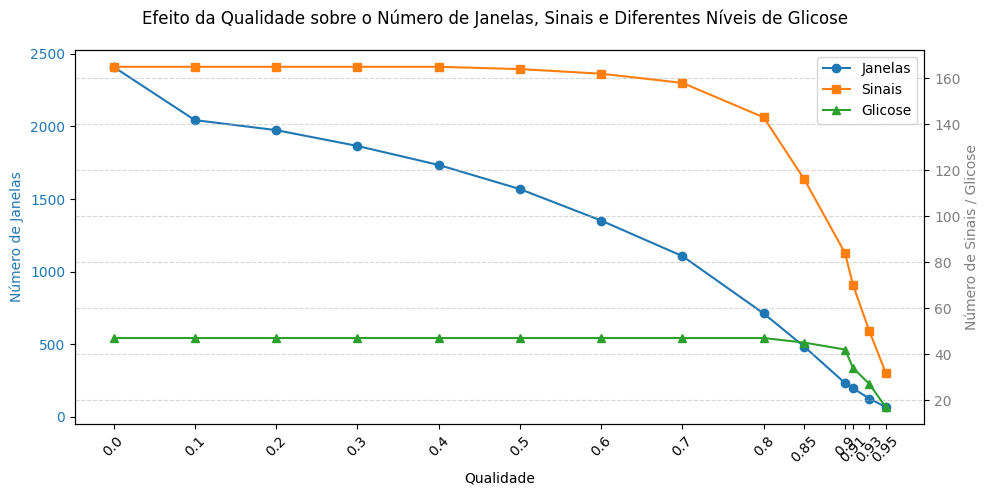

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dados
dados = {
    "qualidade": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.91, 0.93, 0.95],
    "janelas": [2411, 2044, 1975, 1866, 1735, 1569, 1352, 1107, 712, 483, 233, 196, 126, 68],
    "sinais": [165, 165, 165, 165, 165, 164, 162, 158, 143, 116, 84, 70, 50, 32],
    "glicose": [47, 47, 47, 47, 47, 47, 47, 47, 47, 45, 42, 34, 27, 17]
}

df = pd.DataFrame(dados)

# Criação do gráfico
fig, ax1 = plt.subplots(figsize=(10, 5))

# Eixo esquerdo: número de janelas
ax1.plot(df["qualidade"], df["janelas"], marker='o', color='tab:blue', label="Janelas")
ax1.set_xlabel("Qualidade")
ax1.set_ylabel("Número de Janelas", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Força todos os valores de 'qualidade' a aparecer no eixo X
ax1.set_xticks(df["qualidade"])
ax1.set_xticklabels(df["qualidade"], rotation=45)

# Eixo direito: sinais e glicose
ax2 = ax1.twinx()
ax2.plot(df["qualidade"], df["sinais"], marker='s', color='tab:orange', label="Sinais")
ax2.plot(df["qualidade"], df["glicose"], marker='^', color='tab:green', label="Glicose")
ax2.set_ylabel("Número de Sinais / Glicose", color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')

# Título e legenda
fig.suptitle("Efeito da Qualidade sobre o Número de Janelas, Sinais e Diferentes Níveis de Glicose", fontsize=12)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()





df_features_mean= (df completo)










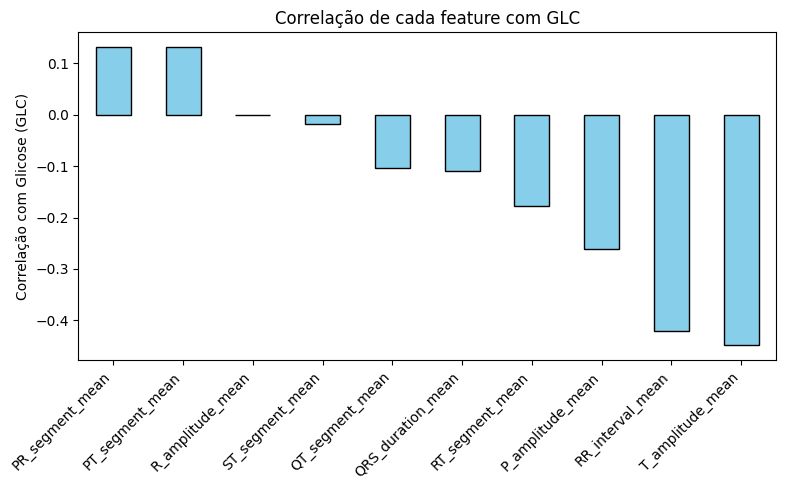

In [ ]:
# Exclui colunas que não devem participar da correlação
df_corr = df_quality.drop(columns=[ "ECG_Quality_Mean", "ECG_Quality_Min"])

# Calcula a correlação apenas nas colunas numéricas restantes
corr = df_corr.corr(numeric_only=True)

# Seleciona a correlação de cada feature com GLC
corr_glucose = corr["GLC"].sort_values(ascending=False)

# --- Gráfico ---
plt.figure(figsize=(8,5))
corr_glucose.drop("GLC").plot(kind="bar", color="skyblue", edgecolor="black")
plt.ylabel("Correlação com Glicose (GLC)")
plt.title("Correlação de cada feature com GLC")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#usar na rede neural apenas os sinais

In [ ]:
# Supondo df com colunas ['ECG_Clean', 'GLC']

# Converte listas de ECG_Clean em um DataFrame de colunas separadas
df_quality_list = pd.DataFrame(df_quality['ECG_Clean'].tolist())

df_quality = df_quality.reset_index(drop=True)

# Adiciona a coluna GLC
df_quality = pd.concat([df_quality_list, df_quality['GLC'],df_quality['janela_id']], axis=1)

# Mostra o resultado
df_quality

0         1         2         3         4         5         6  \
0    0.346616  0.357022  0.367828  0.378861  0.390004  0.401209  0.412492   
1    0.129760  0.127227  0.125203  0.124460  0.125847  0.130226  0.138456   
2    0.247312  0.244801  0.242355  0.239937  0.237543  0.235216  0.233049   
3    0.573198  0.577980  0.582593  0.587343  0.592450  0.598070  0.604235   
4    0.901342  0.901113  0.900866  0.900606  0.900332  0.900040  0.899725   
..        ...       ...       ...       ...       ...       ...       ...   
228  0.670798  0.663725  0.654628  0.643734  0.631311  0.617658  0.603085   
229  0.212231  0.212182  0.211901  0.211356  0.210588  0.209739  0.209043   
230  0.411164  0.423698  0.436341  0.449072  0.461874  0.474734  0.487636   
231  0.246764  0.247003  0.247405  0.247941  0.248569  0.249240  0.249899   
232  0.548087  0.561256  0.573557  0.584811  0.594852  0.603535  0.610744   

            7         8         9  ...       992       993       994  \
0    0.423932  0.435657  0.447832  ...  0.195363  0.195308  0.196114   
1    0.151353  0.169636  0.193891  ...  0.009479  0.011439  0.013677   
2    0.231184  0.229791  0.229049  ...  0.534620  0.550775  0.565593   
3    0.610800  0.617484  0.623895  ...  0.312314  0.302766  0.292569   
4    0.899377  0.898986  0.898544  ...  0.918826  0.918718  0.918633   
..        ...       ...       ...  ...       ...       ...       ...   
228  0.587893  0.572362  0.556733  ...  0.219436  0.216720  0.214745   
229  0.208872  0.209726  0.212279  ...  0.291729  0.301491  0.311712   
230  0.500560  0.513481  0.526366  ...  0.297293  0.296994  0.296604   
231  0.250494  0.250977  0.251309  ...  0.941461  0.944950  0.930013   
232  0.616395  0.620433  0.622839  ...  0.207166  0.207855  0.209048   

          995       996       997       998       999  GLC  janela_id  
0    0.197657  0.199745  0.202137  0.204571  0.206788  125          0  
1    0.015989  0.018162  0.019991  0.021281  0.021852   94          1  
2    0.578814  0.590251  0.599916  0.607951  0.614603   94          1  
3    0.282113  0.271828  0.262171  0.253592  0.246517   94          1  
4    0.918574  0.918546  0.918548  0.918573  0.918614   94          2  
..        ...       ...       ...       ...       ...  ...        ...  
228  0.213436  0.212689  0.212377  0.212353  0.212464  148        163  
229  0.322347  0.333344  0.344649  0.356207  0.367971  148        163  
230  0.296171  0.295750  0.295393  0.295144  0.295040  148        163  
231  0.896711  0.846115  0.780157  0.701548  0.613577  148        163  
232  0.210628  0.212449  0.214347  0.216158  0.217736  148        164  

[233 rows x 1002 columns]

In [ ]:
def interpolate_ecg(signal, num_points=50):
    # Se for lista 2D, pega a primeira
    if isinstance(signal[0], list):
        signal = signal[0]

    if len(signal) < 2:
        return [np.nan] * num_points

    x_original = np.linspace(0, len(signal)-1, len(signal))
    x_novo = np.linspace(0, len(signal)-1, num_points)
    return np.interp(x_novo, x_original, signal)



df_quality['ECG_Clean'] = df_quality['ECG_Clean'].apply(lambda x: interpolate_ecg(x, 50))




In [ ]:
# Supondo df com colunas ['ECG_Clean', 'GLC']

# Converte listas de ECG_Clean em um DataFrame de colunas separadas
df_quality_list = pd.DataFrame(df_quality['ECG_Clean'].tolist())

df_quality = df_quality.reset_index(drop=True)

# Adiciona a coluna GLC
df_quality = pd.concat([df_quality_list, df_quality], axis=1)

# Mostra o resultado
df_quality

0         1         2         3         4         5         6  \
0    0.346616  0.649425  0.825676  0.456975  0.275260  0.240398  0.213744   
1    0.129760  0.764190  0.187260  0.302389  0.384522  0.430768  0.598676   
2    0.247312  0.258470  0.245552  0.236459  0.339245  0.271961  0.185129   
3    0.573198  0.546207  0.108891  0.082732  0.012656  0.073037  0.060386   
4    0.901342  0.891183  0.906319  0.927042  0.894797  0.895651  0.902375   
..        ...       ...       ...       ...       ...       ...       ...   
228  0.670798  0.404763  0.274504  0.252570  0.272174  0.295800  0.261967   
229  0.212231  0.621623  0.196848  0.191566  0.195555  0.216138  0.272810   
230  0.411164  0.652028  0.553463  0.345018  0.300910  0.316041  0.321508   
231  0.246764  0.239663  0.227248  0.243537  0.244764  0.387195  0.217775   
232  0.548087  0.555560  0.319961  0.254677  0.235010  0.242097  0.259982   

            7         8         9  ...  QRS_duration_mean  RR_interval_mean  \
0    0.254721  0.196138  0.223130  ...           0.075000             0.764   
1    0.851274  0.606118  0.437078  ...           0.079333             0.742   
2    0.867479  0.161892  0.113480  ...           0.092667             0.744   
3    0.008925  0.051865  0.156652  ...           0.078667             0.695   
4    0.909982  0.930658  0.930360  ...           0.084000             0.767   
..        ...       ...       ...  ...                ...               ...   
228  0.259092  0.253865  0.319966  ...           0.092000             0.762   
229  0.494879  0.618101  0.364631  ...           0.088667             0.867   
230  0.326217  0.311506  0.311800  ...           0.088000             0.846   
231  0.180460  0.962071  0.047940  ...           0.079000             0.832   
232  0.241443  0.222170  0.214529  ...           0.080000             0.848   

     QT_segment_mean  ST_segment_mean  R_amplitude_mean  T_amplitude_mean  \
0              0.273         0.198000          0.904340          0.813359   
1              0.280         0.200667          0.910279          0.800957   
2              0.282         0.185000          0.954184          0.714075   
3              0.284         0.206000          0.836326          0.701003   
4              0.274         0.190000          0.953913          0.967851   
..               ...              ...               ...               ...   
228            0.313         0.221000          0.971294          0.638945   
229            0.316         0.222000          0.969453          0.631568   
230            0.313         0.225000          0.977740          0.685215   
231            0.303         0.224000          0.978928          0.621344   
232            0.300         0.220000          0.986711          0.581648   

     RT_segment_mean  PR_segment_mean  PT_segment_mean  P_amplitude_mean  
0           0.236000         0.117000         0.117000          0.291502  
1           0.240000         0.124000         0.124000          0.436105  
2           0.242000         0.142000         0.142000          0.290575  
3           0.243000         0.114667         0.114667          0.262926  
4           0.226667         0.148000         0.148000          0.915289  
..               ...              ...              ...               ...  
228         0.260000         0.116000         0.116000          0.362085  
229         0.260000         0.115000         0.115000          0.356990  
230         0.263000         0.117000         0.117000          0.415941  
231         0.262000         0.114000         0.114000          0.383231  
232         0.259000         0.117000         0.117000          0.372492  

[233 rows x 63 columns]

In [ ]:
df["ECG_Clean"].iloc[0].shape

(50,)

In [ ]:
df_quality.isna().sum()


participant_id        0
ECG_Clean             0
GLC                   0
janela_id             0
ECG_Quality_Mean      0
ECG_Quality_Min       0
QRS_duration_mean     5
RR_interval_mean     10
QT_segment_mean       5
ST_segment_mean       5
R_amplitude_mean      5
T_amplitude_mean      5
RT_segment_mean       5
PR_segment_mean       5
PT_segment_mean       5
P_amplitude_mean      5
dtype: int64

In [ ]:
df_quality = df_quality.dropna()



In [ ]:
df_quality = df_quality.drop(columns=['ECG_Quality_Mean', 'ECG_Quality_Min'])

In [ ]:
df_quality = df_quality.drop(columns=["participant_id"])

In [ ]:
df_quality = df_quality.drop(columns=["ECG_Clean"])

In [ ]:
df_quality = df_quality.drop(columns=['R_amplitude_mean','ST_segment_mean','QT_segment_mean','QRS_duration_mean','PR_segment_mean',	'PT_segment_mean'])

In [ ]:
df_quality

GLC janela_id  QRS_duration_mean  RR_interval_mean  QT_segment_mean  \
3     125         0           0.075000             0.764            0.273   
20     94         1           0.079333             0.742            0.280   
27     94         1           0.092667             0.744            0.282   
28     94         1           0.078667             0.695            0.284   
33     94         2           0.084000             0.767            0.274   
...   ...       ...                ...               ...              ...   
2455  148       163           0.092000             0.762            0.313   
2456  148       163           0.088667             0.867            0.316   
2457  148       163           0.088000             0.846            0.313   
2458  148       163           0.079000             0.832            0.303   
2468  148       164           0.080000             0.848            0.300   

      ST_segment_mean  R_amplitude_mean  T_amplitude_mean  RT_segment_mean  \
3            0.198000          0.904340          0.813359         0.236000   
20           0.200667          0.910279          0.800957         0.240000   
27           0.185000          0.954184          0.714075         0.242000   
28           0.206000          0.836326          0.701003         0.243000   
33           0.190000          0.953913          0.967851         0.226667   
...               ...               ...               ...              ...   
2455         0.221000          0.971294          0.638945         0.260000   
2456         0.222000          0.969453          0.631568         0.260000   
2457         0.225000          0.977740          0.685215         0.263000   
2458         0.224000          0.978928          0.621344         0.262000   
2468         0.220000          0.986711          0.581648         0.259000   

      PR_segment_mean  PT_segment_mean  P_amplitude_mean  
3            0.117000         0.117000          0.291502  
20           0.124000         0.124000          0.436105  
27           0.142000         0.142000          0.290575  
28           0.114667         0.114667          0.262926  
33           0.148000         0.148000          0.915289  
...               ...              ...               ...  
2455         0.116000         0.116000          0.362085  
2456         0.115000         0.115000          0.356990  
2457         0.117000         0.117000          0.415941  
2458         0.114000         0.114000          0.383231  
2468         0.117000         0.117000          0.372492  

[233 rows x 12 columns]

In [ ]:

num_janelas = df_quality['janela_id'].nunique()
print(f"Número de janela_id únicos: {num_janelas}")


Número de janela_id únicos: 88


In [ ]:
df_quality['GLC'].nunique()


42

/tmp/ipython-input-2320330070.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=janela_counts.index, y=janela_counts.values, palette='viridis')


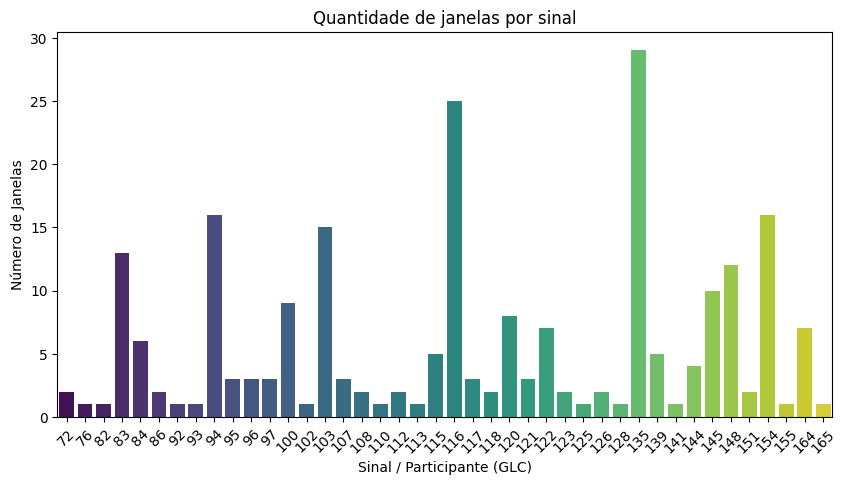

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conta quantas janelas existem por GLC
janela_counts = df_quality.groupby('GLC')['janela_id'].count()

# Cria gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=janela_counts.index, y=janela_counts.values, palette='viridis')
plt.xlabel('Sinal / Participante (GLC)')
plt.ylabel('Número de Janelas')
plt.title('Quantidade de janelas por sinal')
plt.xticks(rotation=45)
plt.show()


#Separação treino e teste

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Supondo que seu DataFrame seja df_quality
X = df_quality.drop(columns=["GLC"])  # Features
y = df_quality["GLC"]                 # Target
groups = df_quality["janela_id"]      # Grupos para o split

# Criar o split garantindo que grupos não se misturem
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Obter índices
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Criar os conjuntos
X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()

# Verificar se algum grupo está nos dois conjuntos (deve ser vazio)
print("Grupos em comum:", set(X_train['janela_id']).intersection(set(X_test['janela_id'])))

# ✅ Agora remove 'janela_id' (pois não é uma feature)
X_train = X_train.drop(columns=["janela_id"])
X_test = X_test.drop(columns=["janela_id"])

print("Conjuntos prontos!")
print("Shape treino:", X_train.shape)
print("Shape teste:", X_test.shape)


Grupos em comum: set()
Conjuntos prontos!
Shape treino: (190, 10)
Shape teste: (43, 10)


In [ ]:
X_train

QRS_duration_mean  RR_interval_mean  QT_segment_mean  ST_segment_mean  \
20             0.079333             0.742         0.280000         0.200667   
27             0.092667             0.744         0.282000         0.185000   
28             0.078667             0.695         0.284000         0.206000   
33             0.084000             0.767         0.274000         0.190000   
45             0.091000             0.606         0.497000         0.406000   
...                 ...               ...              ...              ...   
2454           0.086667             0.785         0.309333         0.222667   
2455           0.092000             0.762         0.313000         0.221000   
2456           0.088667             0.867         0.316000         0.222000   
2457           0.088000             0.846         0.313000         0.225000   
2458           0.079000             0.832         0.303000         0.224000   

      R_amplitude_mean  T_amplitude_mean  RT_segment_mean  PR_segment_mean  \
20            0.910279          0.800957         0.240000         0.124000   
27            0.954184          0.714075         0.242000         0.142000   
28            0.836326          0.701003         0.243000         0.114667   
33            0.953913          0.967851         0.226667         0.148000   
45            0.747317          0.514608         0.441000         0.097000   
...                ...               ...              ...              ...   
2454          0.981926          0.665595         0.260000         0.116667   
2455          0.971294          0.638945         0.260000         0.116000   
2456          0.969453          0.631568         0.260000         0.115000   
2457          0.977740          0.685215         0.263000         0.117000   
2458          0.978928          0.621344         0.262000         0.114000   

      PT_segment_mean  P_amplitude_mean  
20           0.124000          0.436105  
27           0.142000          0.290575  
28           0.114667          0.262926  
33           0.148000          0.915289  
45           0.097000          0.478448  
...               ...               ...  
2454         0.116667          0.372030  
2455         0.116000          0.362085  
2456         0.115000          0.356990  
2457         0.117000          0.415941  
2458         0.114000          0.383231  

[190 rows x 10 columns]

In [ ]:
y_train

1       94
2       94
3       94
4       94
5      120
      ... 
227    148
228    148
229    148
230    148
231    148
Name: GLC, Length: 190, dtype: int64

#Clark

In [ ]:
import matplotlib.pyplot as plt

def clarke_error_grid(ref_values, pred_values, title_string):
    assert (len(ref_values) == len(pred_values)), \
        f"Listas de tamanhos diferentes (referência: {len(ref_values)}, predição: {len(pred_values)})"

    plt.clf()
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " - Clarke Error Grid")
    plt.xlabel("Valor de Referência (mg/dL)")
    plt.ylabel("Valor Predito (mg/dL)")
    plt.xticks(np.arange(0, 450, 50))
    plt.yticks(np.arange(0, 450, 50))
    plt.xlim([0, 400])
    plt.ylim([0, 400])
    plt.gca().set_aspect('equal', adjustable='box')

    # Linhas das zonas
    plt.plot([0,400],[0,400],':',c='black')
    plt.plot([0,175/3],[70,70],'-',c='black')
    plt.plot([175/3,400/1.2],[70,400],'-',c='black')
    plt.plot([70,70],[84,400],'-',c='black')
    plt.plot([0,70],[180,180],'-',c='black')
    plt.plot([70,290],[180,400],'-',c='black')
    plt.plot([70,70],[0,56],'-',c='black')
    plt.plot([70,400],[56,320],'-',c='black')
    plt.plot([180,180],[0,70],'-',c='black')
    plt.plot([180,400],[70,70],'-',c='black')
    plt.plot([240,240],[70,180],'-',c='black')
    plt.plot([240,400],[180,180],'-',c='black')
    plt.plot([130,180],[0,70],'-',c='black')

    # Títulos das zonas
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    # Estatísticas de zonas
    zone = [0] * 5
    for i in range(len(ref_values)):
        ref = ref_values[i]
        pred = pred_values[i]
        if (ref <= 70 and pred <= 70) or (pred <= 1.2 * ref and pred >= 0.8 * ref):
            zone[0] += 1
        elif (ref >= 180 and pred <= 70) or (ref <= 70 and pred >= 180):
            zone[4] += 1
        elif ((ref >= 70 and ref <= 290) and pred >= ref + 110) or \
             ((ref >= 130 and ref <= 180) and (pred <= (7/5) * ref - 182)):
            zone[2] += 1
        elif (ref >= 240 and (pred >= 70 and pred <= 180)) or \
             (ref <= 175/3 and pred <= 180 and pred >= 70) or \
             ((ref >= 175/3 and ref <= 70) and pred >= (6/5) * ref):
            zone[3] += 1
        else:
            zone[1] += 1

    return plt, zone


#svm


===== SVM =====
Mean Error (ME): -5.992
Mean Absolute Error (MAE): 17.044
Mean Absolute Percentage Error (MAPE): 16.99%
Root Mean Squared Error (RMSE): 26.925
R² (Coeficiente de Determinação): -1.035

Amostra dos resultados:
    GCL_real  GCL_predito
0        125    97.204095
1        115    93.579243
2        115    90.463274
3        103   110.154826
4        103   103.211297
5         94   113.651795
6        107   118.315450
7        107   116.441101
8        107   107.688804
9         95    84.339301
10        95    86.030066
11       100    92.468102
12       100    92.939357
13       100   104.215678
14       100   101.336960
15       100   124.411025
16        84   171.983548
17        84    97.608249
18        84    70.470501
19        84   116.691944
20        84   157.351824
21        84    81.664893
22       135   122.033489
23       135   135.588976
24       135   131.638778
25       135   129.938169
26       135   128.087725
27       135   137.228463
28       135   135.1

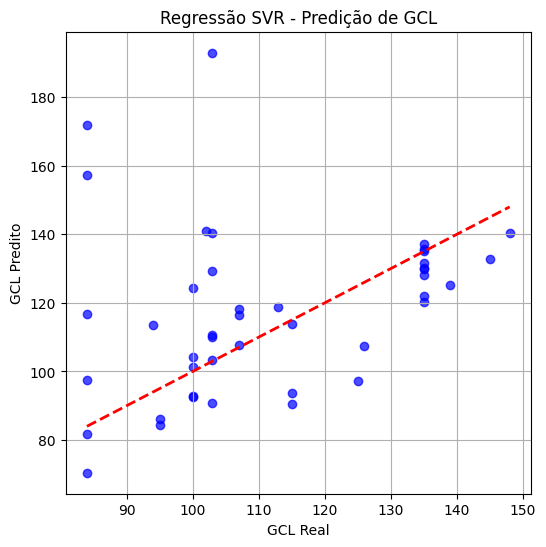

In [ ]:




# ==============================================
# 2. Normalizar os dados
# ==============================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y precisa ser 2D para o scaler
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# ==============================================
# 3. Treinar o modelo SVR
# ==============================================
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model.fit(X_train_scaled, y_train_scaled)

# ==============================================
# 4. Fazer predições
# ==============================================
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ==============================================
# 5. Avaliação do modelo
# ==============================================
# Mean Error (ME)
ME = np.mean(y_test.values - y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100

# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

# Coefficient of Determination (R²)
R2 = r2_score(y_test, y_pred)

# ==============================================
# 6. Exibir resultados
# ==============================================
print("\n===== SVM =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")

# ==============================================
# 7. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print("\nAmostra dos resultados:")
print(df_resultado)

# ==============================================
# 8. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Regressão SVR - Predição de GCL')
plt.grid(True)
plt.show()


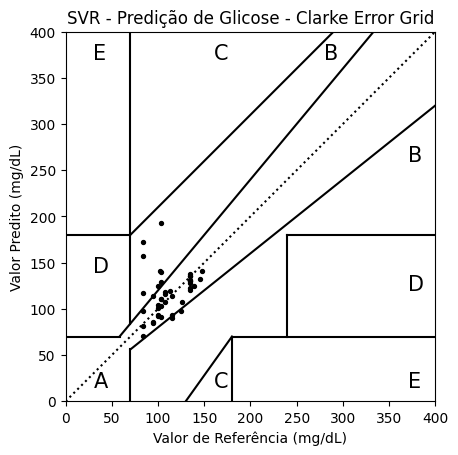


Contagem de pontos em cada zona (A, B, C, D, E):
[32, 11, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# ===============================================================
# 1. OBJETIVO DO OPTUNA → minimizar RMSE usando 5-Fold CV
# ===============================================================
def objective(trial):

    # Hiperparâmetros do SVM a serem otimizados
    params = {
        "C": trial.suggest_float("C", 1e-2, 1e3, log=True),
        "epsilon": trial.suggest_float("epsilon", 1e-3, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-4, 1.0, log=True),
        "kernel": "rbf"
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train):

        # Divisão dos folds
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Reescalar dentro de cada fold
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_tr_scaled = scaler_X.fit_transform(X_tr)
        X_val_scaled = scaler_X.transform(X_val)

        y_tr_scaled = scaler_y.fit_transform(y_tr.values.reshape(-1, 1)).ravel()

        # Modelo
        model = SVR(**params)
        model.fit(X_tr_scaled, y_tr_scaled)

        # Predição e inversão do scaler
        y_val_pred_scaled = model.predict(X_val_scaled)
        y_val_pred = scaler_y.inverse_transform(
            y_val_pred_scaled.reshape(-1, 1)
        ).ravel()

        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmses.append(rmse)

    return np.mean(rmses)


# ===============================================================
# 2. RODAR OPTUNA
# ===============================================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\n======================")
print("MELHORES PARÂMETROS SVM:")
print("======================")
print(study.best_params)

best_params = study.best_params


# ===============================================================
# 3. TREINAR MODELO FINAL COM OS MELHORES HIPERPARÂMETROS
# ===============================================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

final_model = SVR(**best_params)
final_model.fit(X_train_scaled, y_train_scaled)

# Predição
y_pred_scaled = final_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


# ===============================================================
# 4. CALCULAR MÉTRICAS
# ===============================================================
ME = np.mean(y_test.values - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)


# ===============================================================
# 5. RESULTADOS
# ===============================================================
print("\n=========== RESULTADOS FINAIS SVM ===========")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")
print("==============================================")

# Mostrar primeiras predições
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})

print("\nAmostra das predições:")
print(df_resultado.head())


[I 2025-11-19 03:17:30,880] A new study created in memory with name: no-name-7897e087-3cbc-4d2b-a220-e4a85c95c74b
[I 2025-11-19 03:17:30,945] Trial 0 finished with value: 18.983342177427996 and parameters: {'C': 2.7340868128351854, 'epsilon': 0.9567733159264846, 'gamma': 0.01958772893260773}. Best is trial 0 with value: 18.983342177427996.
[I 2025-11-19 03:17:31,022] Trial 1 finished with value: 23.83482594452736 and parameters: {'C': 0.014207229383803973, 'epsilon': 0.0022319106763382134, 'gamma': 0.8572592995307272}. Best is trial 0 with value: 18.983342177427996.
[I 2025-11-19 03:17:31,109] Trial 2 finished with value: 22.380505210141592 and parameters: {'C': 1.8493826120029446, 'epsilon': 0.0127289618104797, 'gamma': 0.0005129962155359903}. Best is trial 0 with value: 18.983342177427996.
[I 2025-11-19 03:17:31,193] Trial 3 finished with value: 20.275069418748235 and parameters: {'C': 16.595457438460702, 'epsilon': 0.1155324255226709, 'gamma': 0.01242151676891742}. Best is trial 0 w


MELHORES PARÂMETROS SVM:
{'C': 5.683724819371621, 'epsilon': 0.05299522934173948, 'gamma': 0.28321944152244005}

=========== RESULTADOS FINAIS SVM ===========
Mean Error (ME): -4.954
Mean Absolute Error (MAE): 13.780
Mean Absolute Percentage Error (MAPE): 13.49%
Root Mean Squared Error (RMSE): 18.419
R² (Coeficiente de Determinação): 0.048

Amostra das predições:
   GCL_real  GCL_predito
0       125    96.925138
1       115    98.580921
2       115   100.051277
3       103   111.400065
4       103   101.941399


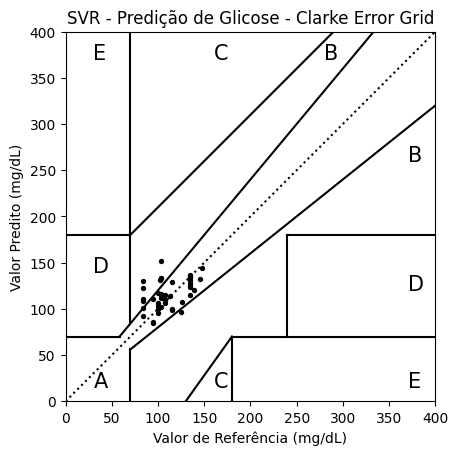


Contagem de pontos em cada zona (A, B, C, D, E):
[33, 10, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


===== SVM =====
Mean Error (ME): -4.953
Mean Absolute Error (MAE): 13.780
Mean Absolute Percentage Error (MAPE): 13.49%
Root Mean Squared Error (RMSE): 18.418
R² (Coeficiente de Determinação): 0.048

Amostra dos resultados:
    GCL_real  GCL_predito
0        125    96.926585
1        115    98.578006
2        115   100.042610
3        103   111.400447
4        103   101.945743
5         94   110.260676
6        107   114.459688
7        107   109.097046
8        107   106.497497
9         95    86.044640
10        95    84.590644
11       100   100.041208
12       100    95.750455
13       100   106.681782
14       100   103.549330
15       100   117.027928
16        84   129.924550
17        84   101.237378
18        84   108.827927
19        84   110.096831
20        84   122.175572
21        84    92.437596
22       135   115.338000
23       135   134.427073
24       135   124.111301
25       135   127.622816
26       135   125.725091
27       135   131.446896
28       135   136.11

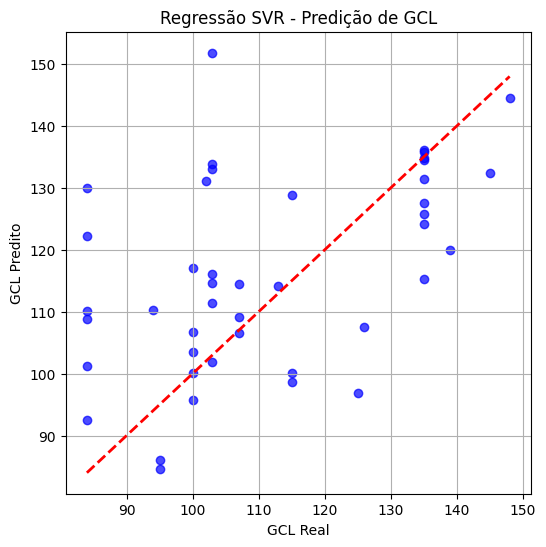

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



# ==============================================
# 2. Normalizar os dados
# ==============================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y precisa ser 2D para o scaler
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# ==============================================
# 3. Treinar o modelo SVR
# ==============================================
model = SVR(kernel='rbf', C=5.683724, gamma=0.283219, epsilon=0.052995)
model.fit(X_train_scaled, y_train_scaled)

# ==============================================
# 4. Fazer predições
# ==============================================
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ==============================================
# 5. Avaliação do modelo
# ==============================================
# Mean Error (ME)
ME = np.mean(y_test.values - y_pred)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100

# Root Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

# Coefficient of Determination (R²)
R2 = r2_score(y_test, y_pred)

# ==============================================
# 6. Exibir resultados
# ==============================================
print("\n===== SVM =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")

# ==============================================
# 7. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print("\nAmostra dos resultados:")
print(df_resultado)

# ==============================================
# 8. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Regressão SVR - Predição de GCL')
plt.grid(True)
plt.show()


# regressao linear


===== RESULTADOS DO MODELO (Regressão Linear) =====
Mean Error (ME): -8.080
Mean Absolute Error (MAE): 12.006
Mean Absolute Percentage Error (MAPE): 11.55%
Root Mean Squared Error (RMSE): 14.981
R² (Coeficiente de Determinação): 0.370

   GLC_real  GLC_predito
0       125   116.144959
1       115   117.147411
2       115   126.584203
3       103   112.091055
4       103   127.390055


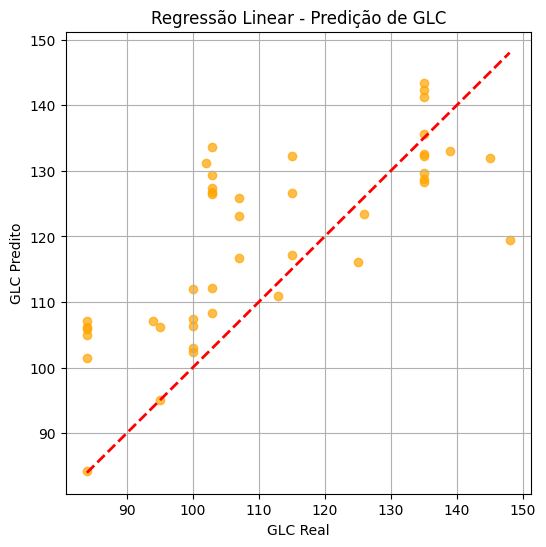

In [ ]:
# ==============================================
# Regressão Linear para prever GLC a partir das features de df_unido
# ==============================================



# ==============================================
# 4. Normalizar os dados
# ==============================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# ==============================================
# 5. Treinar o modelo Linear Regression
# ==============================================
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

# ==============================================
# 6. Fazer predições
# ==============================================
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# ==============================================
# 7. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== RESULTADOS DO MODELO (Regressão Linear) =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 8. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GLC_real": y_test.values,
    "GLC_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 9. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GLC Real')
plt.ylabel('GLC Predito')
plt.title('Regressão Linear - Predição de GLC')
plt.grid(True)
plt.show()


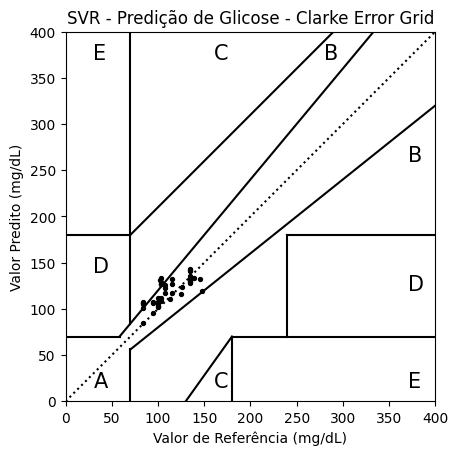


Contagem de pontos em cada zona (A, B, C, D, E):
[32, 11, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


[I 2025-11-18 13:58:09,335] A new study created in memory with name: no-name-273c7039-5400-40a3-9eb6-10bb089efb6d
[I 2025-11-18 13:58:09,352] Trial 0 finished with value: 0.7842092758043704 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.7842092758043704.
[I 2025-11-18 13:58:09,368] Trial 1 finished with value: 0.7842092758043704 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.7842092758043704.
[I 2025-11-18 13:58:09,384] Trial 2 finished with value: 0.7842092758043704 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.7842092758043704.
[I 2025-11-18 13:58:09,400] Trial 3 finished with value: 0.7842092758043704 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.7842092758043704.
[I 2025-11-18 13:58:09,416] Trial 4 finished with value: 0.7794657584121237 and parameters: {'fit_intercept': False}. Best is trial 4 with value: 0.7794657584121237.
[I 2025-11-18 13:58:09,433] Trial 5 finished with value: 0.7


MELHORES PARÂMETROS:
{'fit_intercept': False}

===== RESULTADOS FINAIS (Linear Regression) =====
Mean Error (ME): -8.080
Mean Absolute Error (MAE): 12.006
Mean Absolute Percentage Error (MAPE): 11.55%
Root Mean Squared Error (RMSE): 14.981
R² (Coeficiente de Determinação): 0.370


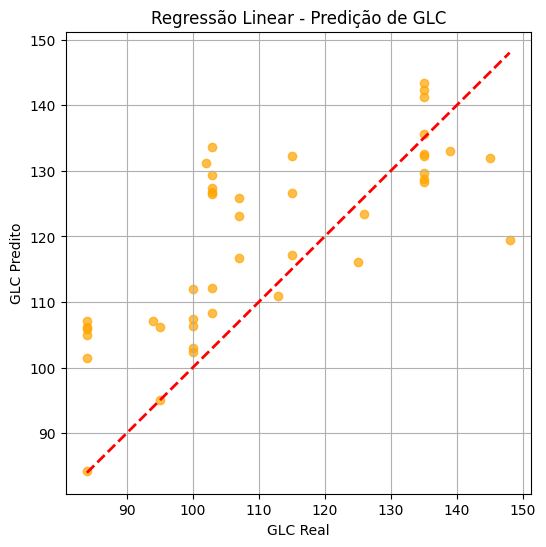

In [ ]:


# Escalar dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Função objetivo do Optuna
def objective(trial):
    # Hiperparâmetros possíveis
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    model = LinearRegression(fit_intercept=fit_intercept)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_scaled[train_idx], y_train_scaled[val_idx]

        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmses.append(rmse)

    return np.mean(rmses)

# Rodar Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Linear é rápido, não precisa de muitas trials

print("\n======================")
print("MELHORES PARÂMETROS:")
print(study.best_params)
best_params = study.best_params

# Treinar modelo final
final_model = LinearRegression(**best_params)
final_model.fit(X_train_scaled, y_train_scaled)

# Predição no teste
y_pred_scaled = final_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

# Avaliação
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== RESULTADOS FINAIS (Linear Regression) =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")

# Visualização
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GLC Real')
plt.ylabel('GLC Predito')
plt.title('Regressão Linear - Predição de GLC')
plt.grid(True)
plt.show()


#random forest


===== Random Forest Regressor - Resultados =====
Mean Error (ME): -3.606
Mean Absolute Error (MAE): 9.157
Mean Absolute Percentage Error (MAPE): 8.95%
Root Mean Squared Error (RMSE): 11.912
R² (Coeficiente de Determinação): 0.602

   GCL_real  GCL_predito
0       125     115.4750
1       115     117.5350
2       115     116.9300
3       103     103.8695
4       103     107.3230


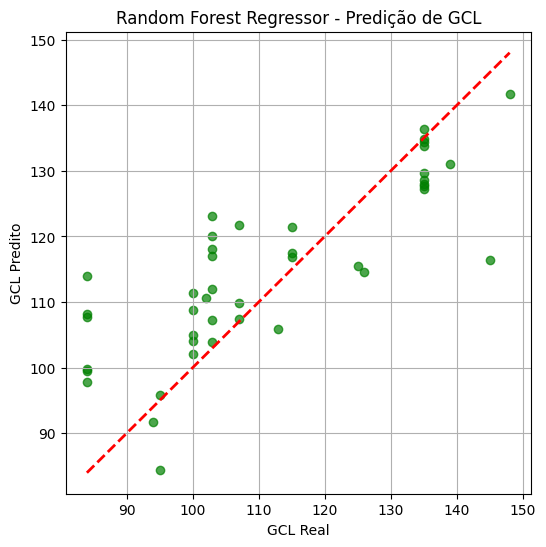

In [ ]:
# ==============================================
# Random Forest Regressor para prever GCL
# ==============================================


)

# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = rf_model.predict(X_test)

# ==============================================
# 4. Avaliação
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== Random Forest Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Gráfico real vs predito
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Random Forest Regressor - Predição de GCL')
plt.grid(True)
plt.show()


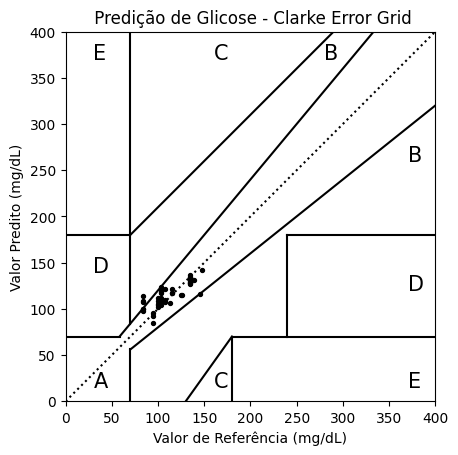


Contagem de pontos em cada zona (A, B, C, D, E):
[40, 3, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, " Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


[I 2025-11-18 14:29:16,316] A new study created in memory with name: no-name-2a935f76-0da1-469a-a975-3941bec282c6
/tmp/ipython-input-2351243883.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  "n_estimators": trial.suggest_int("n_estimators",5, 500, 10),
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced with [5, 495].
  warnings.warn(
/tmp/ipython-input-2351243883.py:15: FutureWarning: suggest_int() got {'step'} as positional arguments but they were e


MELHORES PARÂMETROS:
{'n_estimators': 285, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}

===== Random Forest Regressor - Resultados Finais =====
Mean Error (ME): -3.223
Mean Absolute Error (MAE): 8.873
Mean Absolute Percentage Error (MAPE): 8.63%
Root Mean Squared Error (RMSE): 11.295
R² (Coeficiente de Determinação): 0.642

   GCL_real  GCL_predito
0       125   115.671777
1       115   117.491685
2       115   115.781533
3       103   103.132627
4       103   108.444951


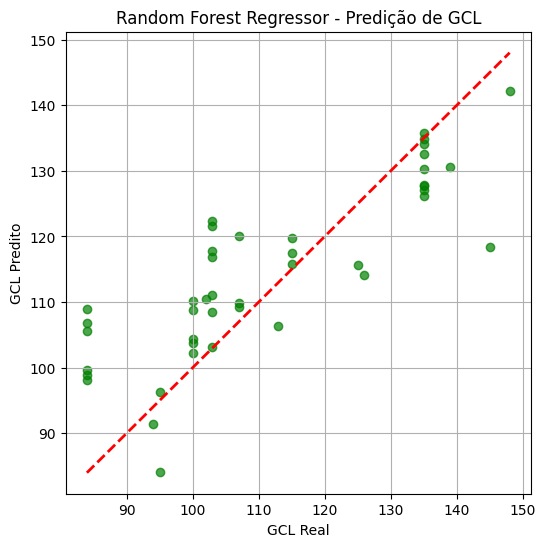

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ===============================================================
# 1. Função objetivo do Optuna
# ===============================================================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators",5, 500, 10),
        "max_depth": trial.suggest_int("max_depth", 1, 50,3),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20,1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20,1),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmses.append(rmse)

    return np.mean(rmses)

# ===============================================================
# 2. Rodar Optuna
# ===============================================================
study = optuna.create_study(direction="minimize")  # Minimiza RMSE
study.optimize(objective, n_trials=50)

print("\n======================")
print("MELHORES PARÂMETROS:")
print("======================")
print(study.best_params)
best_params = study.best_params

# ===============================================================
# 3. Treinar modelo final com os melhores parâmetros
# ===============================================================
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Predição no teste
y_pred = final_model.predict(X_test)

# ===============================================================
# 4. Avaliação do modelo
# ===============================================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== Random Forest Regressor - Resultados Finais =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ===============================================================
# 5. Comparação entre valores reais e preditos
# ===============================================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ===============================================================
# 6. Gráfico Real vs Predito
# ===============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Random Forest Regressor - Predição de GCL')
plt.grid(True)
plt.show()


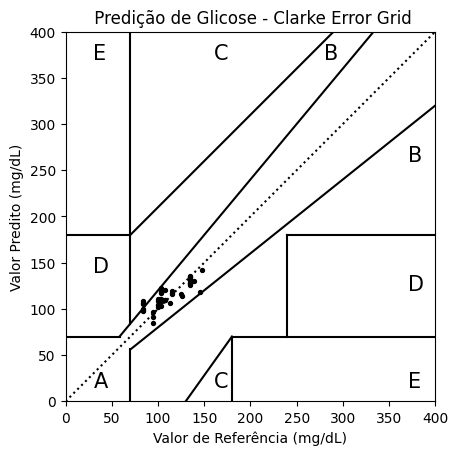


Contagem de pontos em cada zona (A, B, C, D, E):
[40, 3, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, " Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


===== Random Forest Regressor - Resultados =====
Mean Error (ME): -3.223
Mean Absolute Error (MAE): 8.873
Mean Absolute Percentage Error (MAPE): 8.63%
Root Mean Squared Error (RMSE): 11.295
R² (Coeficiente de Determinação): 0.642

   GCL_real  GCL_predito
0       125   115.671777
1       115   117.491685
2       115   115.781533
3       103   103.132627
4       103   108.444951


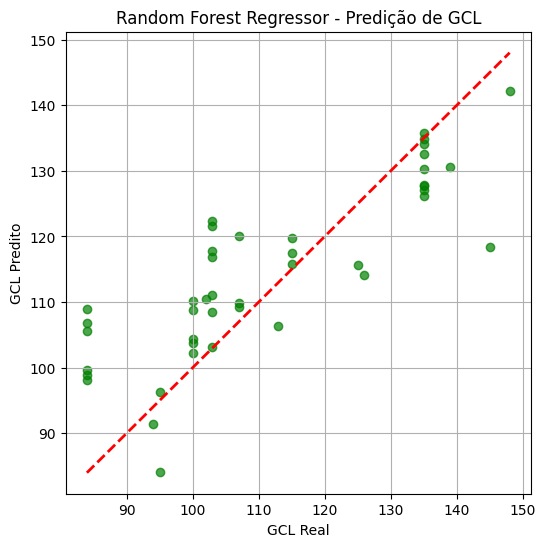

In [ ]:
# ==============================================
# Random Forest Regressor para prever GCL
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
rf_model = RandomForestRegressor(
    n_estimators=285,
    max_depth=46,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features=None,
    random_state=42
)
rf_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = rf_model.predict(X_test)

# ==============================================
# 4. Avaliação
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== Random Forest Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Gráfico real vs predito
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Random Forest Regressor - Predição de GCL')
plt.grid(True)
plt.show()


#gradient boosting


===== Gradient Boosting Regressor - Resultados =====
Mean Error (ME): -3.667
Mean Absolute Error (MAE): 10.344
Mean Absolute Percentage Error (MAPE): 10.27%
Root Mean Squared Error (RMSE): 14.269
R² (Coeficiente de Determinação): 0.428

   GCL_real  GCL_predito
0       125   107.481520
1       115   118.385798
2       115   119.621709
3       103   100.848333
4       103   106.288524


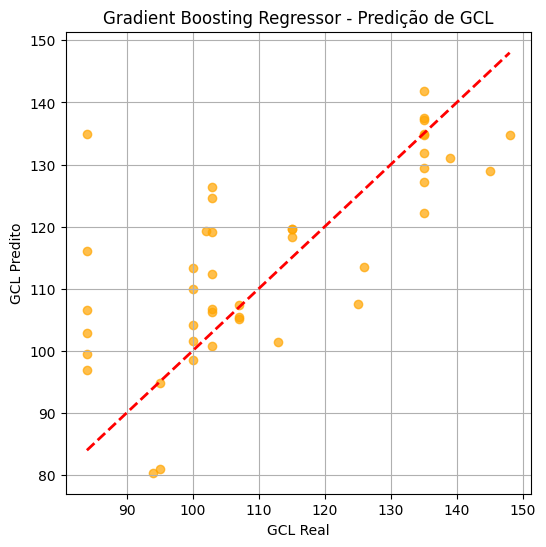

In [ ]:


# ==============================================
# Gradient Boosting Regressor para prever GCL
# ==============================================



# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = gb_model.predict(X_test)

# ==============================================
# 4. Avaliação
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== Gradient Boosting Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Gráfico real vs predito
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Gradient Boosting Regressor - Predição de GCL')
plt.grid(True)
plt.show()


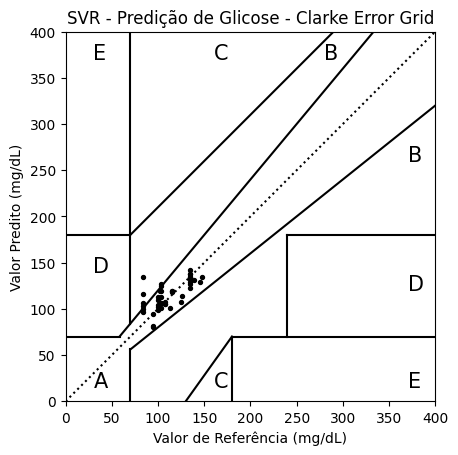


Contagem de pontos em cada zona (A, B, C, D, E):
[37, 6, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


[I 2025-11-18 14:33:09,651] A new study created in memory with name: no-name-5eb5bdf6-f721-4b88-a0bc-1252e52975ed
[I 2025-11-18 14:33:16,096] Trial 0 finished with value: 17.43350046365871 and parameters: {'n_estimators': 520, 'learning_rate': 0.0207861068760541, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 18, 'subsample': 0.5352654542015978, 'max_features': 'sqrt'}. Best is trial 0 with value: 17.43350046365871.
[I 2025-11-18 14:33:26,411] Trial 1 finished with value: 16.577170361070525 and parameters: {'n_estimators': 597, 'learning_rate': 0.018231492297915288, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 20, 'subsample': 0.7685378794327054, 'max_features': 'log2'}. Best is trial 1 with value: 16.577170361070525.
[I 2025-11-18 14:33:30,450] Trial 2 finished with value: 16.47505953194989 and parameters: {'n_estimators': 481, 'learning_rate': 0.04227111981907351, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 17, 'subsample': 0.741734051465


MELHORES PARÂMETROS:
{'n_estimators': 391, 'learning_rate': 0.013410863450766248, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.5634226298025776, 'max_features': None}

===== Gradient Boosting Regressor - Resultados Finais =====
Mean Error (ME): -3.598
Mean Absolute Error (MAE): 9.366
Mean Absolute Percentage Error (MAPE): 9.09%
Root Mean Squared Error (RMSE): 11.768
R² (Coeficiente de Determinação): 0.611

   GCL_real  GCL_predito
0       125   111.955886
1       115   116.872569
2       115   118.949575
3       103   101.941478
4       103   105.505925


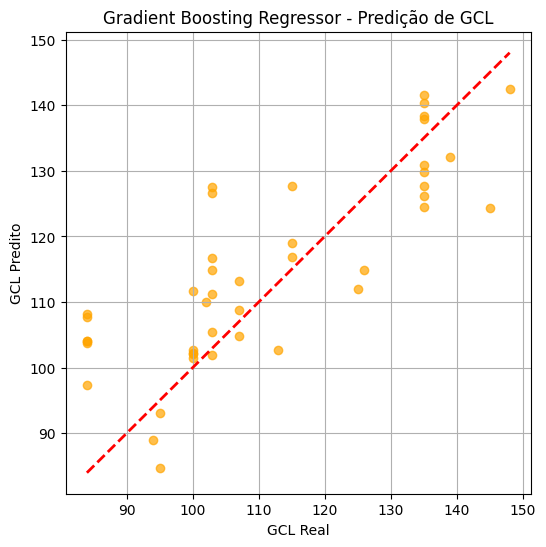

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ===============================================================
# 1. Função objetivo do Optuna
# ===============================================================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = GradientBoostingRegressor(**params, random_state=42)
        model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmses.append(rmse)

    return np.mean(rmses)

# ===============================================================
# 2. Rodar Optuna
# ===============================================================
study = optuna.create_study(direction="minimize")  # Minimiza RMSE
study.optimize(objective, n_trials=50)

print("\n======================")
print("MELHORES PARÂMETROS:")
print("======================")
print(study.best_params)
best_params = study.best_params

# ===============================================================
# 3. Treinar modelo final com os melhores parâmetros
# ===============================================================
final_model = GradientBoostingRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Predição no conjunto de teste
y_pred = final_model.predict(X_test)

# ===============================================================
# 4. Avaliação do modelo
# ===============================================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== Gradient Boosting Regressor - Resultados Finais =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ===============================================================
# 5. Comparação entre valores reais e preditos
# ===============================================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ===============================================================
# 6. Gráfico Real vs Predito
# ===============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Gradient Boosting Regressor - Predição de GCL')
plt.grid(True)
plt.show()


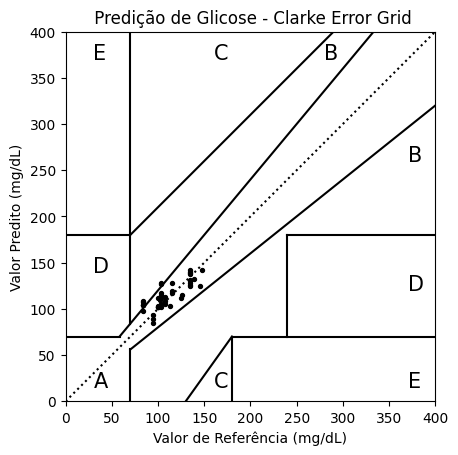


Contagem de pontos em cada zona (A, B, C, D, E):
[36, 7, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, " Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


===== Gradient Boosting Regressor - Resultados =====
Mean Error (ME): -3.598
Mean Absolute Error (MAE): 9.366
Mean Absolute Percentage Error (MAPE): 9.09%
Root Mean Squared Error (RMSE): 11.768
R² (Coeficiente de Determinação): 0.611

   GCL_real  GCL_predito
0       125   111.955886
1       115   116.872569
2       115   118.949575
3       103   101.941478
4       103   105.505925


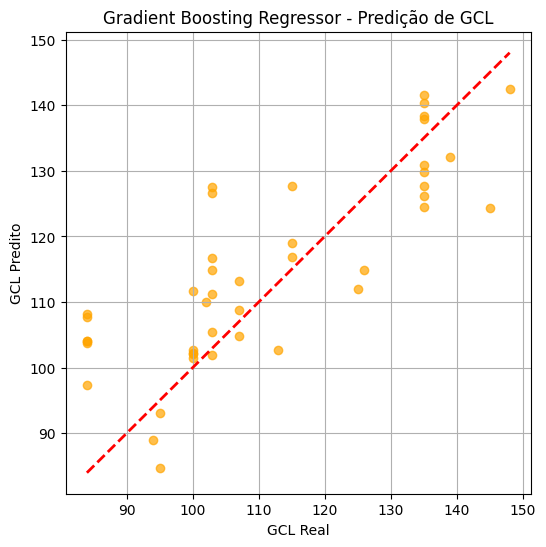

In [ ]:


# ==============================================
# Gradient Boosting Regressor para prever GCL
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
gb_model = GradientBoostingRegressor(
    n_estimators=391,
    learning_rate=0.013410863450766248,
    max_depth= 6,
    min_samples_split= 8,
    min_samples_leaf= 3,
    subsample= 0.5634226298025776,
    max_features= None,
    random_state=42
)
gb_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = gb_model.predict(X_test)

# ==============================================
# 4. Avaliação
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== Gradient Boosting Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Gráfico real vs predito
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('Gradient Boosting Regressor - Predição de GCL')
plt.grid(True)
plt.show()


#knn


===== KNN Regressor - Resultados =====
Mean Error (ME): -6.033
Mean Absolute Error (MAE): 12.851
Mean Absolute Percentage Error (MAPE): 12.45%
Root Mean Squared Error (RMSE): 16.447
R² (Coeficiente de Determinação): 0.241

   GCL_real  GCL_predito
0       125        105.6
1       115        105.2
2       115        110.8
3       103        116.2
4       103        129.8


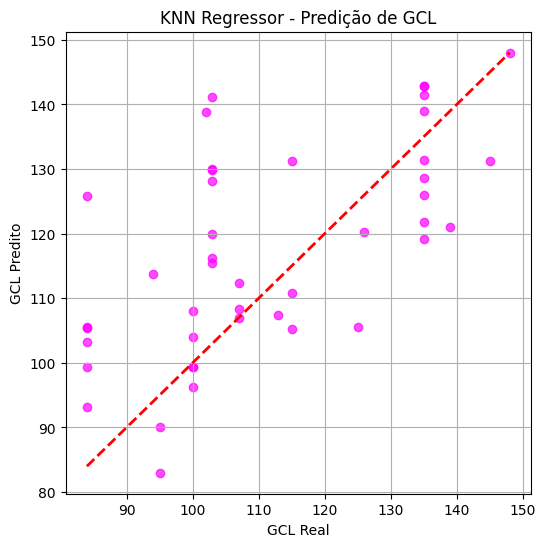

In [ ]:
# ==============================================
# K-Nearest Neighbors Regressor para prever GCL
# ==============================================



# ==============================================
# 1. Normalização (essencial para KNN)
# ==============================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()

# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_scaled)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred_scaled = knn_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

# ==============================================
# 4. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== KNN Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='magenta', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('KNN Regressor - Predição de GCL')
plt.grid(True)
plt.show()


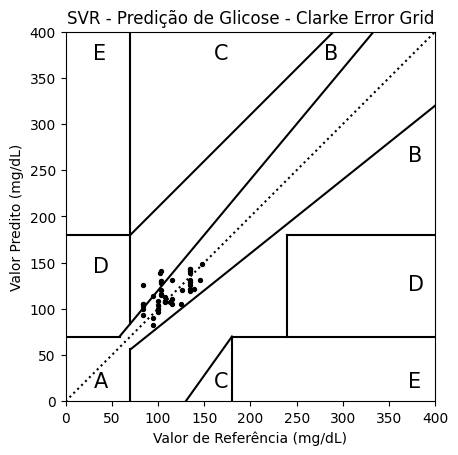


Contagem de pontos em cada zona (A, B, C, D, E):
[33, 10, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


[I 2025-11-18 14:39:12,961] A new study created in memory with name: no-name-5bde3773-82cb-4599-a0ec-fc054aa781ee
/tmp/ipython-input-1070120719.py:28: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
Positional arguments ['self', 'name', 'low', 'high', 'step', 'log'] in suggest_int() have been deprecated since v3.5.0. They will be replaced with the corresponding keyword arguments in v5.0.0, so please use the keyword specification instead. See https://github.com/optuna/optuna/releases/tag/v3.5.0 for details.
  "p": trial.suggest_int("p", 1, 2,4)
/usr/local/lib/python3.12/dist-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [1, 2] and step=4, but the range is not divisible by `step`. It will be replaced with [1, 1].
  warnings.warn(
[I 2025-11-18 14:39:12,986] Trial 0 finished with value: 0.9122075956235829 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 1}. Best i


MELHORES PARÂMETROS:
{'n_neighbors': 4, 'weights': 'distance', 'p': 1}

===== KNN Regressor - Resultados Finais =====
Mean Error (ME): -5.845
Mean Absolute Error (MAE): 12.051
Mean Absolute Percentage Error (MAPE): 11.67%
Root Mean Squared Error (RMSE): 15.742
R² (Coeficiente de Determinação): 0.304

   GCL_real  GCL_predito
0       125   114.693259
1       115   112.232339
2       115   114.710476
3       103   116.461733
4       103   120.266041


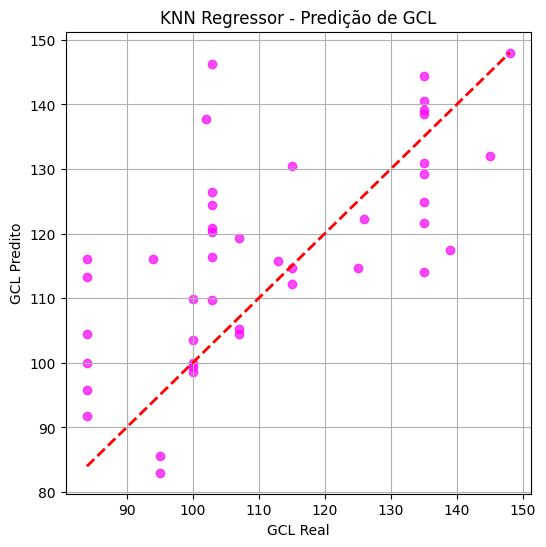

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ==============================================
# 1. Escalar dados
# ==============================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()

# ==============================================
# 2. Função objetivo do Optuna
# ==============================================
def objective(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2,4)
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train_scaled[train_idx], y_train_scaled[val_idx]

        model = KNeighborsRegressor(**params)
        model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmses.append(rmse)

    return np.mean(rmses)

# ==============================================
# 3. Rodar Optuna
# ==============================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\n======================")
print("MELHORES PARÂMETROS:")
print("======================")
print(study.best_params)
best_params = study.best_params

# ==============================================
# 4. Treinar modelo final
# ==============================================
final_model = KNeighborsRegressor(**best_params)
final_model.fit(X_train_scaled, y_train_scaled)

# Predição no teste
y_pred_scaled = final_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

# ==============================================
# 5. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== KNN Regressor - Resultados Finais =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 6. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 7. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='magenta', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('KNN Regressor - Predição de GCL')
plt.grid(True)
plt.show()


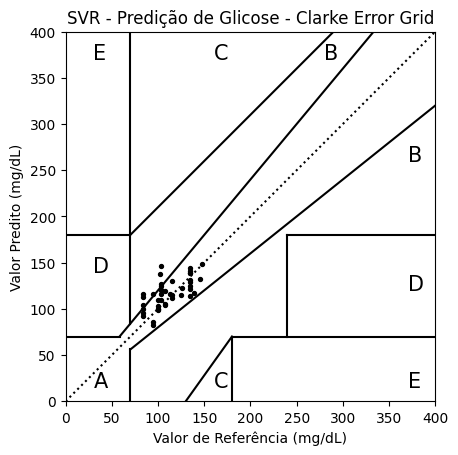


Contagem de pontos em cada zona (A, B, C, D, E):
[35, 8, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)

#catboost

0:	learn: 23.4061861	total: 55ms	remaining: 27.5s
100:	learn: 8.7351990	total: 214ms	remaining: 844ms
200:	learn: 5.4790320	total: 370ms	remaining: 550ms
300:	learn: 3.6474394	total: 518ms	remaining: 343ms
400:	learn: 2.7562090	total: 678ms	remaining: 168ms
499:	learn: 2.1944331	total: 866ms	remaining: 0us

===== CatBoost Regressor - Resultados =====
Mean Error (ME): -4.891
Mean Absolute Error (MAE): 9.797
Mean Absolute Percentage Error (MAPE): 9.58%
Root Mean Squared Error (RMSE): 12.613
R² (Coeficiente de Determinação): 0.553

   GCL_real  GCL_predito
0       125   110.047597
1       115   113.760450
2       115   116.439881
3       103   101.057379
4       103   106.807202


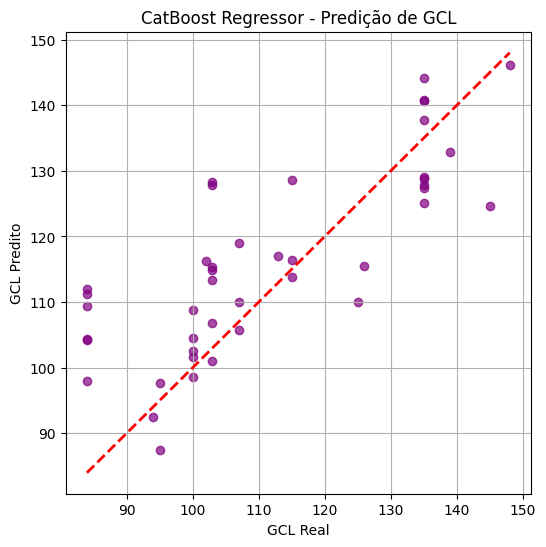

In [ ]:
# ==============================================
# CatBoost Regressor para prever GCL
# ==============================================



# ==============================================




# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = cat_model.predict(X_test)


# ==============================================
# 4. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== CatBoost Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('CatBoost Regressor - Predição de GCL')
plt.grid(True)
plt.show()


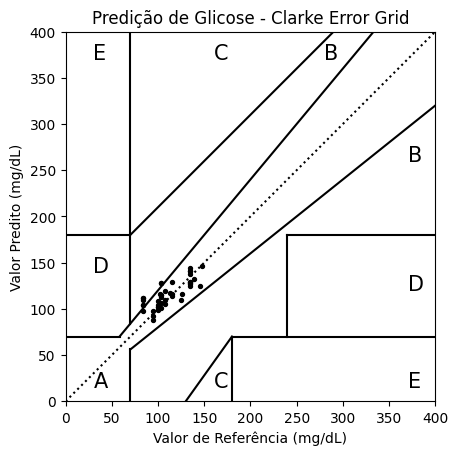


Contagem de pontos em cada zona (A, B, C, D, E):
[36, 7, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


[I 2025-11-19 14:43:57,250] A new study created in memory with name: no-name-d1a12818-8e10-43b5-8bd4-e7bd6677a439
[I 2025-11-19 14:44:57,191] Trial 0 finished with value: 16.523509227488127 and parameters: {'iterations': 1366, 'learning_rate': 0.16483687411235962, 'depth': 9, 'l2_leaf_reg': 4.714614556725732, 'random_strength': 4.100345750877851, 'bagging_temperature': 0.8007175347821548, 'border_count': 118}. Best is trial 0 with value: 16.523509227488127.
[I 2025-11-19 14:52:31,269] Trial 1 finished with value: 17.990253018951712 and parameters: {'iterations': 612, 'learning_rate': 0.059484777489316736, 'depth': 15, 'l2_leaf_reg': 6.565944389276147, 'random_strength': 8.685286051952085, 'bagging_temperature': 0.9670892679839412, 'border_count': 39}. Best is trial 0 with value: 16.523509227488127.
[I 2025-11-19 15:42:24,943] Trial 2 finished with value: 18.052511881637784 and parameters: {'iterations': 1703, 'learning_rate': 0.01222500412441877, 'depth': 15, 'l2_leaf_reg': 9.252217275


MELHORES PARÂMETROS:
{'iterations': 725, 'learning_rate': 0.022621406290511088, 'depth': 4, 'l2_leaf_reg': 6.579153150324447, 'random_strength': 9.963556831509493, 'bagging_temperature': 0.05474293563761779, 'border_count': 241}
0:	learn: 23.8041586	total: 2.68ms	remaining: 1.94s
100:	learn: 18.5552720	total: 120ms	remaining: 738ms
200:	learn: 15.9247547	total: 324ms	remaining: 845ms
300:	learn: 13.6587247	total: 417ms	remaining: 587ms
400:	learn: 11.5611538	total: 552ms	remaining: 446ms
500:	learn: 10.1923347	total: 754ms	remaining: 337ms
600:	learn: 9.2399309	total: 948ms	remaining: 196ms
700:	learn: 8.2956276	total: 1.15s	remaining: 39.3ms
724:	learn: 8.1186970	total: 1.19s	remaining: 0us

===== CatBoost Regressor - Resultados Finais =====
Mean Error (ME): -4.977
Mean Absolute Error (MAE): 9.715
Mean Absolute Percentage Error (MAPE): 9.53%
Root Mean Squared Error (RMSE): 12.521
R² (Coeficiente de Determinação): 0.560

   GCL_real  GCL_predito
0       125   111.404408
1       115   

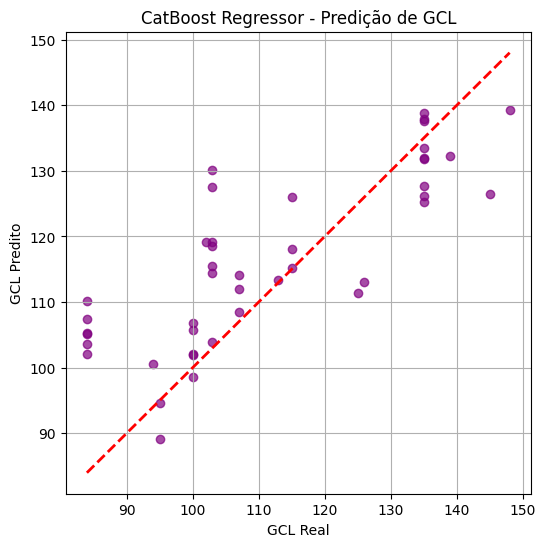

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# ==============================================
# 1. Função objetivo do Optuna
# ==============================================
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3, log=True),
        "depth": trial.suggest_int("depth", 3, 15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
         "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "loss_function": "RMSE",
        "random_seed": 42,
        "verbose": 0
    }




    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmses.append(rmse)

    return np.mean(rmses)

# ==============================================
# 2. Rodar Optuna
# ==============================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\n======================")
print("MELHORES PARÂMETROS:")
print("======================")
print(study.best_params)
best_params = study.best_params

# ==============================================
# 3. Treinar modelo final com melhores parâmetros
# ==============================================
final_model = CatBoostRegressor(**best_params, loss_function='RMSE', random_seed=42, verbose=100)
final_model.fit(X_train, y_train)

# Predição no conjunto de teste
y_pred = final_model.predict(X_test)

# ==============================================
# 4. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== CatBoost Regressor - Resultados Finais =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Gráfico Real vs Predito
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('CatBoost Regressor - Predição de GCL')
plt.grid(True)
plt.show()


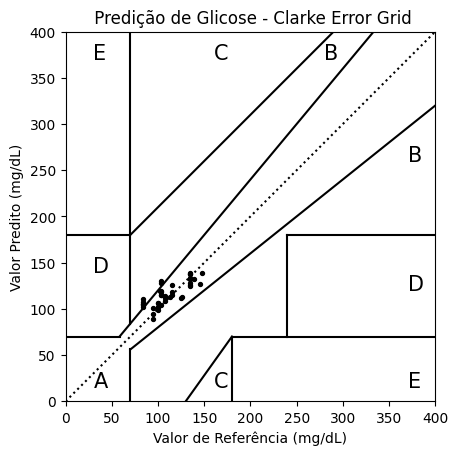


Contagem de pontos em cada zona (A, B, C, D, E):
[35, 8, 0, 0, 0]


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, " Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


0:	learn: 23.8041598	total: 4.58ms	remaining: 3.31s
100:	learn: 18.5553306	total: 202ms	remaining: 1.25s
200:	learn: 15.9248233	total: 461ms	remaining: 1.2s
300:	learn: 13.6587931	total: 823ms	remaining: 1.16s
400:	learn: 11.5612153	total: 1.06s	remaining: 855ms
500:	learn: 10.1923908	total: 1.18s	remaining: 527ms
600:	learn: 9.2399855	total: 1.33s	remaining: 275ms
700:	learn: 8.2956824	total: 1.44s	remaining: 49.5ms
724:	learn: 8.1187519	total: 1.47s	remaining: 0us

===== CatBoost Regressor - Resultados =====
Mean Error (ME): -4.977
Mean Absolute Error (MAE): 9.715
Mean Absolute Percentage Error (MAPE): 9.53%
Root Mean Squared Error (RMSE): 12.521
R² (Coeficiente de Determinação): 0.560

   GCL_real  GCL_predito
0       125   111.404505
1       115   115.200310
2       115   118.025628
3       103   103.885237
4       103   114.452979


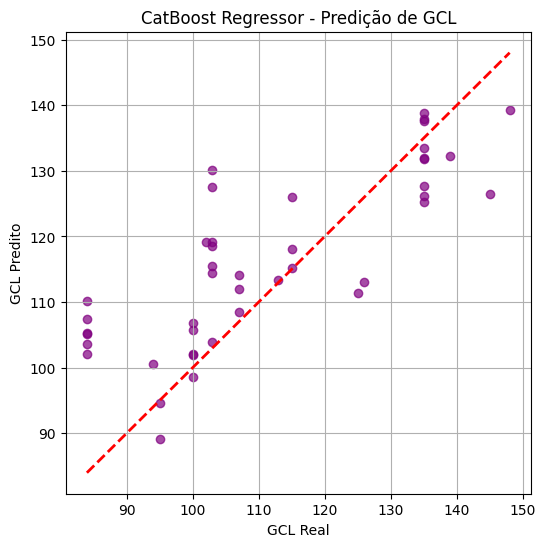

In [ ]:
# ==============================================
# CatBoost Regressor para prever GCL
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
from catboost import CatBoostRegressor

# ==============================================




# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
cat_model = CatBoostRegressor(
    iterations=725,
    learning_rate=0.022621,
    l2_leaf_reg = 6.5791,
    depth=4,
    random_strength= 9.9635568,
    bagging_temperature = 0.05474,
    border_count =  241,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = cat_model.predict(X_test)


# ==============================================
# 4. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== CatBoost Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('CatBoost Regressor - Predição de GCL')
plt.grid(True)
plt.show()


#exboost


===== XGBoost Regressor - Resultados =====
Mean Error (ME): -5.416
Mean Absolute Error (MAE): 11.288
Mean Absolute Percentage Error (MAPE): 11.10%
Root Mean Squared Error (RMSE): 14.100
R² (Coeficiente de Determinação): 0.442

   GCL_real  GCL_predito
0       125   112.235634
1       115   123.639412
2       115   120.164124
3       103    99.084656
4       103   105.752205


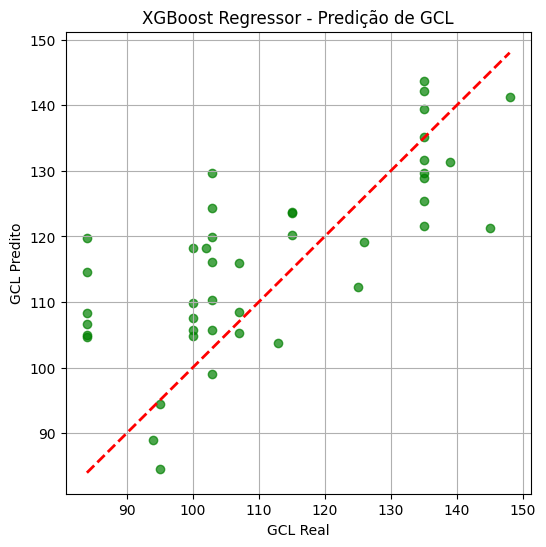

In [ ]:
# ==============================================
# XGBoost Regressor para prever GCL
# ==============================================








# ==============================================
# 2. Criar e treinar o modelo
# ==============================================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# ==============================================
# 3. Fazer predições
# ==============================================
y_pred = xgb_model.predict(X_test)


# ==============================================
# 4. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== XGBoost Regressor - Resultados =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Visualização gráfica
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('XGBoost Regressor - Predição de GCL')
plt.grid(True)
plt.show()


In [ ]:
# ==============================================
# 9. Clarke Error Grid para seus dados
# ==============================================
plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "SVR - Predição de Glicose")
plt_fig.show()

# Mostrar contagem de pontos por zona
print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)


[I 2025-11-20 17:40:54,442] A new study created in memory with name: no-name-63eb1389-d4ab-4a8a-8ff9-1a01d8377e6c
[I 2025-11-20 17:41:38,520] Trial 0 finished with value: 16.4450783111201 and parameters: {'n_estimators': 402, 'learning_rate': 0.29035420883060276, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.1784296882187031, 'subsample': 0.3992736336165708, 'colsample_bytree': 0.9198999100355492, 'colsample_bylevel': 0.6011096841022555, 'lambda': 0.7035571103014185, 'alpha': 0.0006989776016764789, 'booster': 'dart', 'rate_drop': 0.013530662184153053, 'max_delta_step': 3}. Best is trial 0 with value: 16.4450783111201.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:41:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "rate_drop" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:41:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "rate_dr


MELHORES PARÂMETROS:
{'n_estimators': 758, 'learning_rate': 0.034067894418489605, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 3.251849855935211, 'subsample': 0.44261518485837364, 'colsample_bytree': 0.8306120452529742, 'colsample_bylevel': 0.30711061407982393, 'lambda': 0.0005024178632012258, 'alpha': 0.31923905502060285, 'booster': 'gbtree', 'rate_drop': 0.25185968471098186, 'max_delta_step': 9}

===== XGBoost Regressor - Resultados Finais =====
Mean Error (ME): -5.822
Mean Absolute Error (MAE): 11.173
Mean Absolute Percentage Error (MAPE): 10.99%
Root Mean Squared Error (RMSE): 14.005
R² (Coeficiente de Determinação): 0.449

   GCL_real  GCL_predito
0       125    99.329498
1       115   127.169365
2       115   129.422607
3       103    97.037827
4       103   108.308113


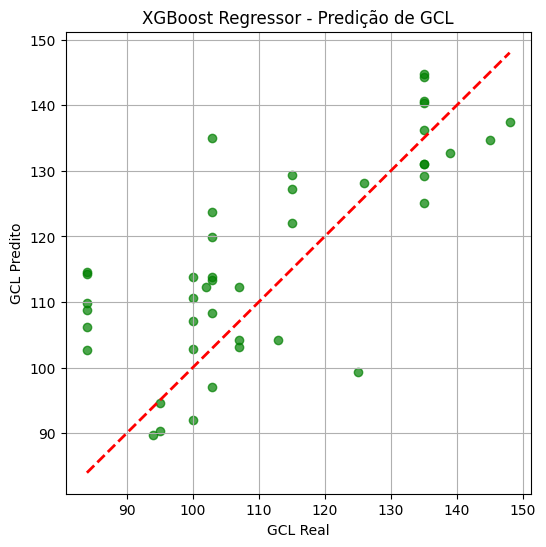

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ==============================================
# 1. Função objetivo do Optuna
# ==============================================
def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 200, 2000),

    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),

    "max_depth": trial.suggest_int("max_depth", 2, 15),

    "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),

    "gamma": trial.suggest_float("gamma", 0, 10),

    "subsample": trial.suggest_float("subsample", 0.3, 1.0),

    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),


    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1.0),


    "lambda": trial.suggest_float("lambda", 1e-4, 10.0, log=True),


    "alpha": trial.suggest_float("alpha", 1e-4, 10.0, log=True),


    "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),


    "rate_drop": trial.suggest_float("rate_drop", 0.0, 0.3),


    "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
}


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr)

        y_pred_val = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        rmses.append(rmse)

    return np.mean(rmses)

# ==============================================
# 2. Rodar Optuna
# ==============================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\n======================")
print("MELHORES PARÂMETROS:")
print("======================")
print(study.best_params)
best_params = study.best_params

# ==============================================
# 3. Treinar modelo final com melhores parâmetros
# ==============================================
final_model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# Predição no conjunto de teste
y_pred = final_model.predict(X_test)

# ==============================================
# 4. Avaliação do modelo
# ==============================================
ME = np.mean(y_test - y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("\n===== XGBoost Regressor - Resultados Finais =====")
print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}\n")

# ==============================================
# 5. Comparação entre valores reais e preditos
# ==============================================
df_resultado = pd.DataFrame({
    "GCL_real": y_test.values,
    "GCL_predito": y_pred
})
print(df_resultado.head())

# ==============================================
# 6. Gráfico Real vs Predito
# ==============================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('GCL Real')
plt.ylabel('GCL Predito')
plt.title('XGBoost Regressor - Predição de GCL')
plt.grid(True)
plt.show()


#rede

In [ ]:



X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)




#treino com features

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 122.9360 - mae: 122.9360 - val_loss: 119.3021 - val_mae: 119.3021
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 124.6724 - mae: 124.6724 - val_loss: 119.2727 - val_mae: 119.2727
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 124.9589 - mae: 124.9589 - val_loss: 119.2358 - val_mae: 119.2358
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 123.9934 - mae: 123.9934 - val_loss: 119.1873 - val_mae: 119.1873
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 120.7748 - mae: 120.7748 - val_loss: 119.1234 - val_mae: 119.1234
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 121.0964 - mae: 121.0964 - val_loss: 119.0381 - val_mae: 119.0381
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 121.6028 - mae: 121.6028 - val_loss: 118.9218 - val_mae: 118.9218
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 121.1979 - mae: 121.1979 - val_loss: 118.7621 - val_mae: 118.7621
Epoch 9

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Error (ME): -9.808
Mean Absolute Error (MAE): 18.513
Mean Absolute Percentage Error (MAPE): 18.34%
Root Mean Squared Error (RMSE): 22.325
R² (Coeficiente de Determinação): -0.399


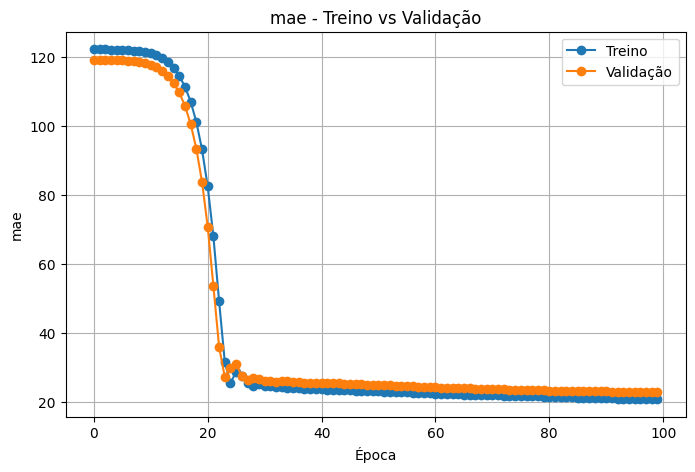

In [ ]:
model = models.Sequential([

    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='linear')

])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae'])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True)

y_pred_probs = model.predict(X_test)
y_pred = model.predict(X_test).flatten()


y_true = y_test.values

ME = np.mean(y_true - y_pred)
MAE = np.mean(np.abs(y_true - y_pred))
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
R2 = r2_score(y_true, y_pred)


print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")




plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Treino', marker='o')
plt.plot(history.history['val_mae'], label='Validação', marker='o')
plt.title('mae - Treino vs Validação')
plt.xlabel('Época')
plt.ylabel('mae')
plt.legend()
plt.grid(True)
plt.show()




#treino com sinal completo

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 121.9533 - mae: 121.9533 - val_loss: 119.2843 - val_mae: 119.2843
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 121.7846 - mae: 121.7846 - val_loss: 119.0946 - val_mae: 119.0946
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 120.7403 - mae: 120.7403 - val_loss: 118.7797 - val_mae: 118.7797
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 121.7872 - mae: 121.7872 - val_loss: 118.2559 - val_mae: 118.2559
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 120.1012 - mae: 120.1012 - val_loss: 117.4086 - val_mae: 117.4086
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 120.2932 - mae: 120.2932 - val_loss: 116.0737 - val_mae: 116.0737
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 119.1482 - mae: 119.1482 - val_loss: 113.9936 - val_mae: 113.9936
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 116.5983 - mae: 116.5983 - val_loss: 110.7809 - val_mae: 110.7809
Epoch 

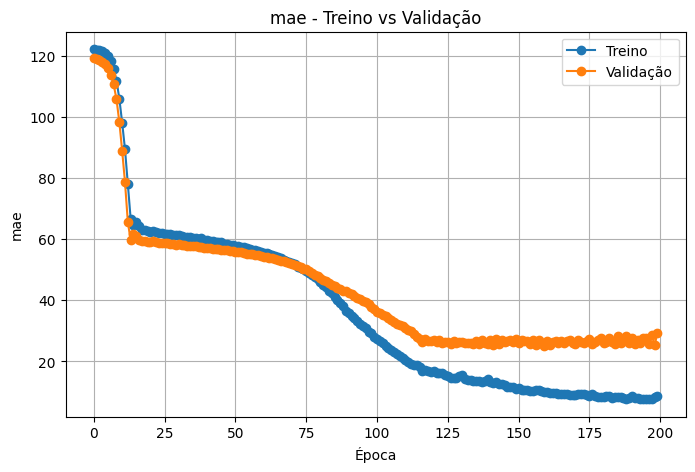

In [ ]:
model = models.Sequential([

    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae'])

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True)

y_pred_probs = model.predict(X_test)
y_pred = model.predict(X_test).flatten()


y_true = y_test.values

ME = np.mean(y_true - y_pred)
MAE = np.mean(np.abs(y_true - y_pred))
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
R2 = r2_score(y_true, y_pred)


print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")




plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Treino', marker='o')
plt.plot(history.history['val_mae'], label='Validação', marker='o')
plt.title('mae - Treino vs Validação')
plt.xlabel('Época')
plt.ylabel('mae')
plt.legend()
plt.grid(True)
plt.show()




#treino 50 pontos + features

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 122.2413 - mae: 122.2413 - val_loss: 118.9666 - val_mae: 118.9666
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 121.2618 - mae: 121.2618 - val_loss: 118.5853 - val_mae: 118.5853
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 122.5459 - mae: 122.5459 - val_loss: 118.0443 - val_mae: 118.0443
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 122.7492 - mae: 122.7492 - val_loss: 117.2958 - val_mae: 117.2958
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 121.6204 - mae: 121.6204 - val_loss: 116.2327 - val_mae: 116.2327
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 117.7551 - mae: 117.7551 - val_loss: 114.6723 - val_mae: 114.6723
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 117.7988 - mae: 117.7988 - val_loss: 112.3473 - val_mae: 112.3473
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 116.0321 - mae: 116.0321 - val_loss: 108.8816 - val_mae: 108.8816
Epoch 9/

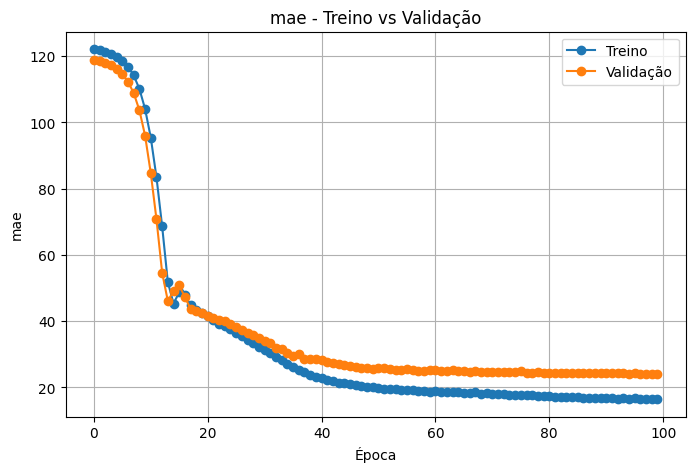

In [ ]:
model = models.Sequential([

    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae'])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True)

y_pred_probs = model.predict(X_test)
y_pred = model.predict(X_test).flatten()


y_true = y_test.values

ME = np.mean(y_true - y_pred)
MAE = np.mean(np.abs(y_true - y_pred))
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
R2 = r2_score(y_true, y_pred)


print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")




plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Treino', marker='o')
plt.plot(history.history['val_mae'], label='Validação', marker='o')
plt.title('mae - Treino vs Validação')
plt.xlabel('Época')
plt.ylabel('mae')
plt.legend()
plt.grid(True)
plt.show()




#testando otimizadores


Treinando com Adam...

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

Treinando com SGD...

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

Treinando com RMSprop...

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


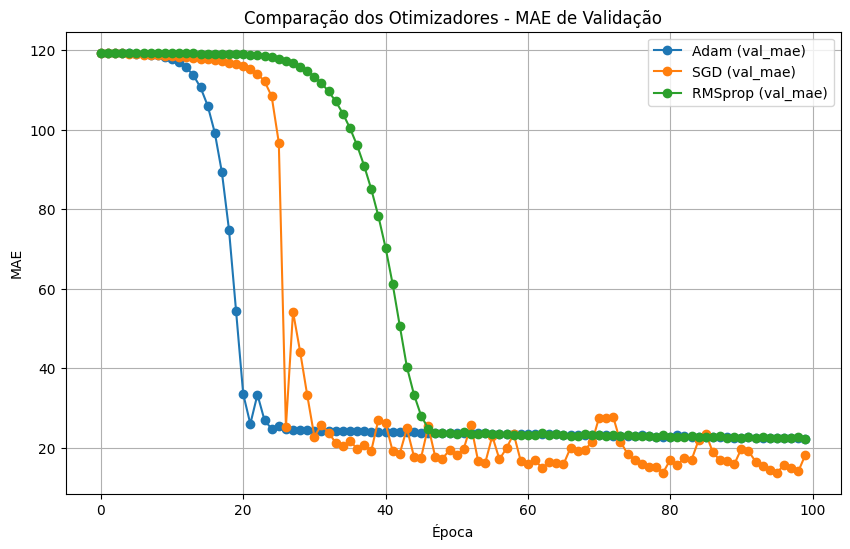

In [ ]:
def criar_modelo():
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(5, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    return model



otimizadores = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.001, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001)
}

historicos = {}
resultados = {}


for nome, opt in otimizadores.items():

    print(f"\nTreinando com {nome}...\n")

    model = criar_modelo()
    model.compile(optimizer=opt, loss='mae', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        shuffle=True,
        verbose=0
    )

    historicos[nome] = history


    y_pred = model.predict(X_test).flatten()
    y_true = y_test.values

    resultados[nome] = {
        "ME": np.mean(y_true - y_pred),
        "MAE": np.mean(np.abs(y_true - y_pred)),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        "RMSE": np.sqrt(np.mean((y_true - y_pred)**2)),
        "R2": r2_score(y_true, y_pred)
    }




plt.figure(figsize=(10,6))

for nome, history in historicos.items():
    plt.plot(history.history['val_mae'], marker='o', label=f"{nome} (val_mae)")

plt.title("Comparação dos Otimizadores - MAE de Validação")
plt.xlabel("Época")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()


#testando learnign rates


Treinando modelo com learning rate = 0.0001

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
MAE: 111.024, MAPE: 99.70%, RMSE: 112.618, R²: -34.603

Treinando modelo com learning rate = 0.001

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
MAE: 28.235, MAPE: 28.41%, RMSE: 33.946, R²: -2.235

Treinando modelo com learning rate = 0.01

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
MAE: 16.812, MAPE: 16.51%, RMSE: 20.954, R²: -0.233

Treinando modelo com learning rate = 0.1

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
MAE: 15.157, MAPE: 12.57%, RMSE: 20.367, R²: -0.164

Tabela resumida dos resultados:

   Learning Rate          ME         MAE   MAPE (%)        RMSE         R²
0         0.0001  111.023802  111.023802  99.698527  112.617764 -34.603020
1         0.0010  -19.414413   28.234957  28.411813   33.946265  -2.234871
2         0.0100   -7.510236   16.811514  16.505387   20.953739  -0.232526
3         0.1000    9.866132   15.157374  12.570395   20.366873  -0.164452


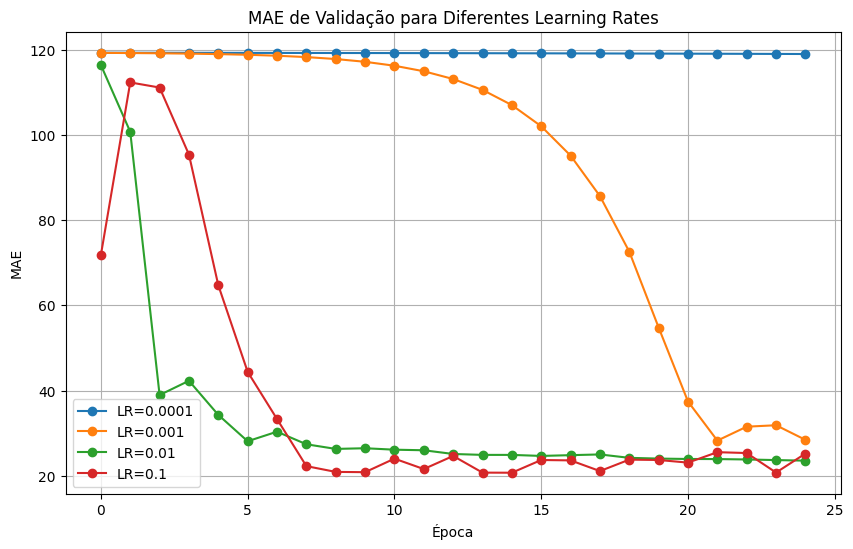

In [ ]:


learning_rates = [0.0001, 0.001, 0.01, 0.1]


histories = {}
results = []

for lr in learning_rates:
    print(f"\nTreinando modelo com learning rate = {lr}\n")


    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(5, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='linear')
    ])


    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mae',
                  metrics=['mae'])


    history = model.fit(X_train, y_train,
                        epochs=25,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        shuffle=True,
                        verbose=0)

    histories[lr] = history


    y_pred = model.predict(X_test).flatten()
    y_true = y_test.values

    ME = np.mean(y_true - y_pred)
    MAE = np.mean(np.abs(y_true - y_pred))
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
    R2 = r2_score(y_true, y_pred)

    results.append({
        'Learning Rate': lr,
        'ME': ME,
        'MAE': MAE,
        'MAPE (%)': MAPE,
        'RMSE': RMSE,
        'R²': R2
    })

    print(f"MAE: {MAE:.3f}, MAPE: {MAPE:.2f}%, RMSE: {RMSE:.3f}, R²: {R2:.3f}")


results_df = pd.DataFrame(results)
print("\nTabela resumida dos resultados:\n")
print(results_df)


plt.figure(figsize=(10,6))
for lr, history in histories.items():
    plt.plot(history.history['val_mae'], label=f'LR={lr}', marker='o')
plt.title('MAE de Validação para Diferentes Learning Rates')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


#Batch Size


Treinando modelo com batch size = 8

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
MAE: 12.652, MAPE: 12.30%, RMSE: 15.396, R²: 0.335

Treinando modelo com batch size = 16

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
MAE: 11.761, MAPE: 11.17%, RMSE: 15.004, R²: 0.368

Treinando modelo com batch size = 32

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
MAE: 20.781, MAPE: 20.81%, RMSE: 24.901, R²: -0.741

Treinando modelo com batch size = 64

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
MAE: 18.268, MAPE: 18.22%, RMSE: 21.814, R²: -0.336

Treinando modelo com batch size = 128

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
MAE: 30.148, MAPE: 30.81%, RMSE: 36.135, R²: -2.665

Treinando modelo com batch size = 512

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
MAE: 55.599, MAPE: 55.56%, RMSE: 62.523, R²: -9.974

Tabela resumida dos resultados por Batch Size:

   Batch Size         ME        MAE   MAPE (%)       RMSE        R²
0           8  -5.366071  12.652039  12.299409  15.395818  0.334607
1          16  -3.331115  11.760593  11.

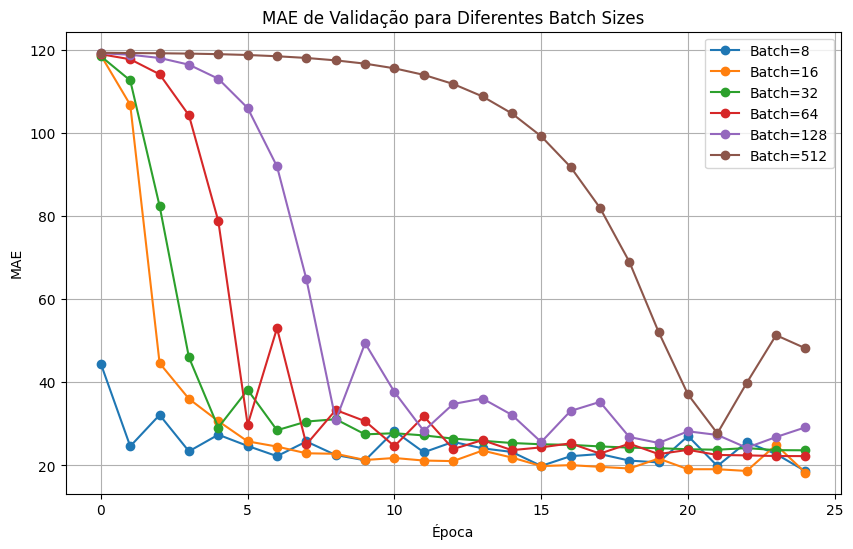

In [ ]:

batch_sizes = [8,16, 32, 64, 128,512]


histories = {}
results = []

for batch in batch_sizes:
    print(f"\nTreinando modelo com batch size = {batch}\n")

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(5, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='linear')
    ])


    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='mae',
                  metrics=['mae'])


    history = model.fit(X_train, y_train,
                        epochs=25,
                        batch_size=batch,
                        validation_data=(X_val, y_val),
                        shuffle=True,
                        verbose=0)

    histories[batch] = history


    y_pred = model.predict(X_test).flatten()
    y_true = y_test.values

    ME = np.mean(y_true - y_pred)
    MAE = np.mean(np.abs(y_true - y_pred))
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
    R2 = r2_score(y_true, y_pred)

    results.append({
        'Batch Size': batch,
        'ME': ME,
        'MAE': MAE,
        'MAPE (%)': MAPE,
        'RMSE': RMSE,
        'R²': R2
    })

    print(f"MAE: {MAE:.3f}, MAPE: {MAPE:.2f}%, RMSE: {RMSE:.3f}, R²: {R2:.3f}")


results_df = pd.DataFrame(results)
print("\nTabela resumida dos resultados por Batch Size:\n")
print(results_df)


plt.figure(figsize=(10,6))
for batch, history in histories.items():
    plt.plot(history.history['val_mae'], label=f'Batch={batch}', marker='o')
plt.title('MAE de Validação para Diferentes Batch Sizes')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


#nr camadas e neuronios


Modelos a serem testados:
 - Modelo_1: [5, 10, 30, 50, 30, 10, 5]
 - Modelo_2: [5, 30, 50, 10, 5]
 - Modelo_3: [5, 5, 10, 10, 30, 30, 50, 50, 30, 30, 10, 10, 5, 5]
 - Modelo_4: [8, 16, 32, 64, 128, 64, 32, 16, 8]

Treinando modelo: Modelo_1 - [5, 10, 30, 50, 30, 10, 5]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
MAE: 20.942, MAPE: 20.06%, RMSE: 24.055, R²: -0.624

Treinando modelo: Modelo_2 - [5, 30, 50, 10, 5]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
MAE: 101.349, MAPE: 90.76%, RMSE: 103.091, R²: -28.834

Treinando modelo: Modelo_3 - [5, 5, 10, 10, 30, 30, 50, 50, 30, 30, 10, 10, 5, 5]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MAE: 26.625, MAPE: 25.36%, RMSE: 29.429, R²: -1.431

Treinando modelo: Modelo_4 - [8, 16, 32, 64, 128, 64, 32, 16, 8]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MAE: 13.218, MAPE: 12.62%, RMSE: 16.048, R²: 0.277

Resumo final:

  Arquitetura          ME         MAE   MAPE (%)        RMSE         R²
0    Modelo_1  -20.209438   20.942212  20.059717   24.054621  -0.624314
1  

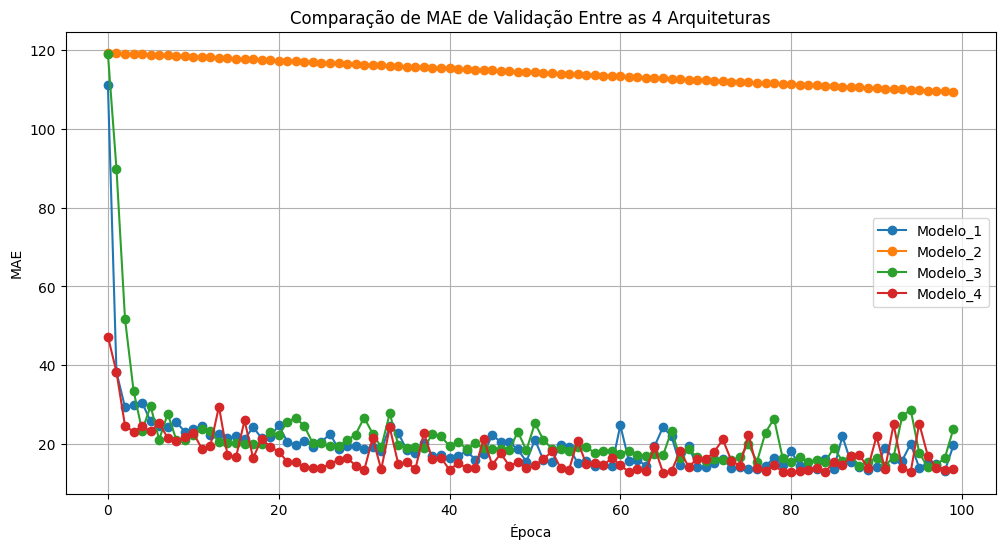

In [ ]:


architectures = {
    "Modelo_1": [5, 10, 30, 50, 30, 10, 5],
    "Modelo_2": [5,  30, 50,  10, 5],
    "Modelo_3": [5,5, 10,10, 30,30,50, 50,30, 30,10, 10,5, 5],
    "Modelo_4": [8, 16, 32,64,128,64,32, 16, 8]
}



batch_size = 16
learning_rate = 0.01
epochs = 100

histories = {}
results = []

print("\nModelos a serem testados:")
for name, arch in architectures.items():
    print(f" - {name}: {arch}")


for name, arch in architectures.items():
    print(f"\nTreinando modelo: {name} - {arch}\n")

    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))


    for neurons in arch:
        model.add(layers.Dense(neurons, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))  # saída final


    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae']
    )


    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        shuffle=True,
        verbose=0
    )

    histories[name] = history


    y_pred = model.predict(X_test).flatten()
    y_true = y_test.values


    ME = np.mean(y_true - y_pred)
    MAE = np.mean(np.abs(y_true - y_pred))
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
    R2 = r2_score(y_true, y_pred)

    results.append({
        'Arquitetura': name,
        'ME': ME,
        'MAE': MAE,
        'MAPE (%)': MAPE,
        'RMSE': RMSE,
        'R²': R2
    })

    print(f"MAE: {MAE:.3f}, MAPE: {MAPE:.2f}%, RMSE: {RMSE:.3f}, R²: {R2:.3f}")


results_df = pd.DataFrame(results)
print("\nResumo final:\n")
print(results_df)


plt.figure(figsize=(12,6))
for name, history in histories.items():
    plt.plot(history.history['val_mae'], label=name, marker='o')
plt.title('Comparação de MAE de Validação Entre as 4 Arquiteturas')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()


#final

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 122.6734 - mae: 122.6734 - val_loss: 118.5017 - val_mae: 118.5017
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 118.5706 - mae: 118.5706 - val_loss: 104.7595 - val_mae: 104.7595
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 85.9047 - mae: 85.9047 - val_loss: 48.8739 - val_mae: 48.8739
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 33.4711 - mae: 33.4711 - val_loss: 30.1604 - val_mae: 30.1604
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 27.9837 - mae: 27.9837 - val_loss: 26.4140 - val_mae: 26.4140
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23.1436 - mae: 23.1436 - val_loss: 27.0029 - val_mae: 27.0029
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 22.3089 - mae: 22.3089 - val_loss: 28.6567 - val_mae: 28.6567
Epoch 8/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23.9750 - mae: 23.9750 - val_loss: 23.0273 - val_mae: 23.0273
Epoch 9/300
10/1

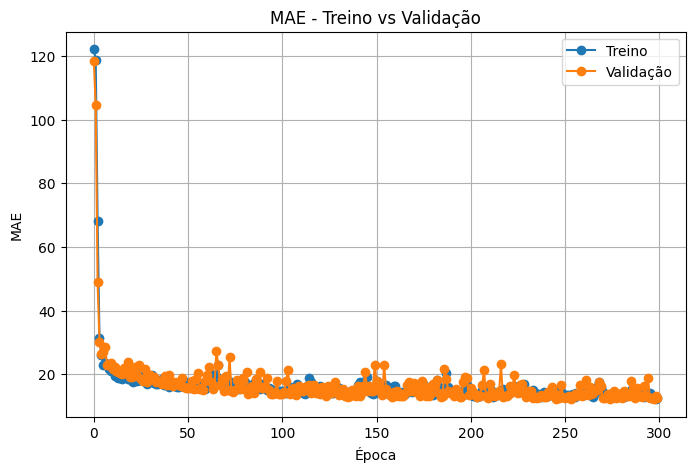

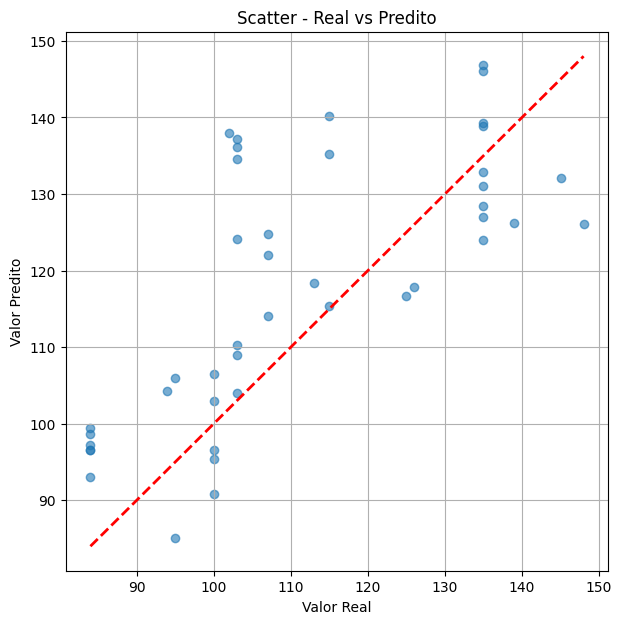

In [ ]:
model = models.Sequential([

    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(5, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mae',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val, y_val),
    shuffle=True
)


y_pred_probs = model.predict(X_test)
y_pred = model.predict(X_test).flatten()
y_true = y_test.values


ME = np.mean(y_true - y_pred)
MAE = np.mean(np.abs(y_true - y_pred))
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
R2 = r2_score(y_true, y_pred)

print(f"Mean Error (ME): {ME:.3f}")
print(f"Mean Absolute Error (MAE): {MAE:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")
print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
print(f"R² (Coeficiente de Determinação): {R2:.3f}")



plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Treino', marker='o')
plt.plot(history.history['val_mae'], label='Validação', marker='o')
plt.title('MAE - Treino vs Validação')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(7,7))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Scatter - Real vs Predito")
plt.grid(True)
plt.show()




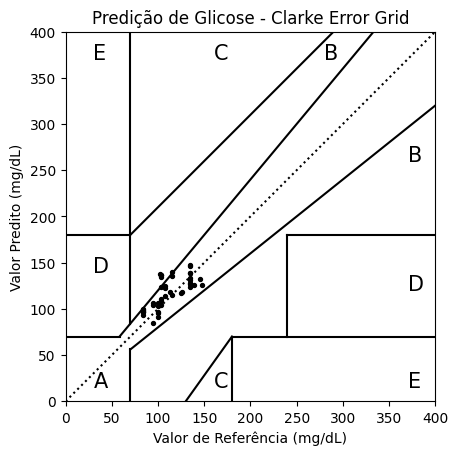


Contagem de pontos em cada zona (A, B, C, D, E):
[37, 6, 0, 0, 0]


In [ ]:

plt_fig, zonas = clarke_error_grid(y_test.values, y_pred, "Predição de Glicose")
plt_fig.show()


print("\nContagem de pontos em cada zona (A, B, C, D, E):")
print(zonas)
